In [1]:
import numpy as np, matplotlib.pyplot as plt
import os
from scipy import interpolate
from astropy.convolution import convolve_fft, Gaussian1DKernel
from glob import glob

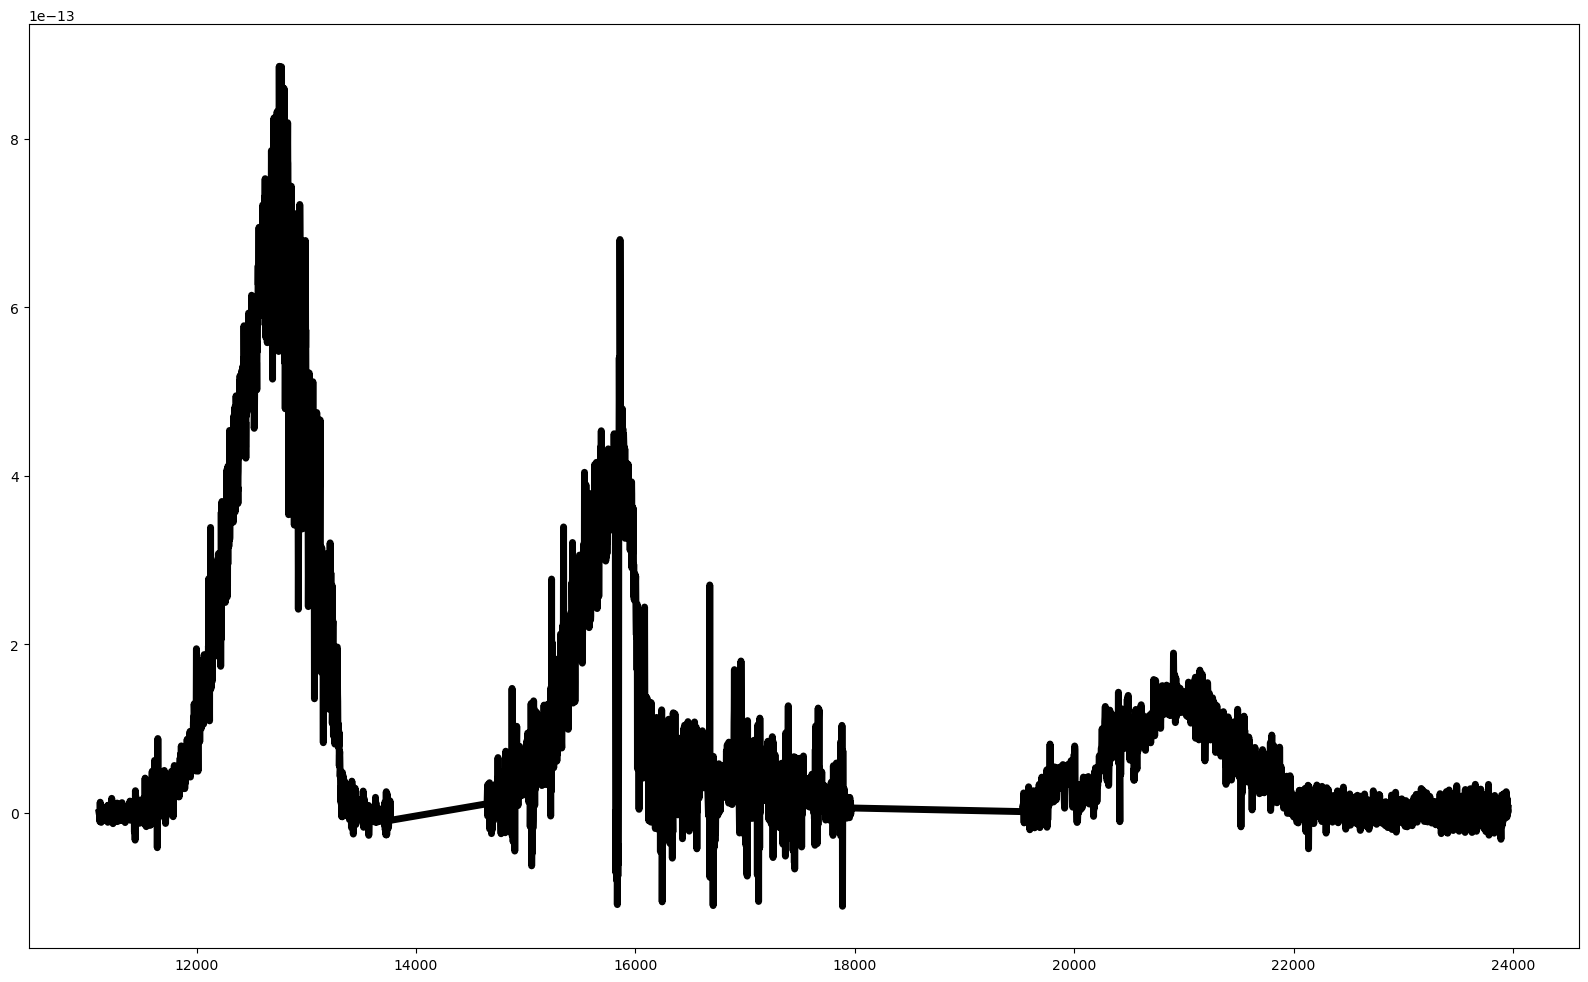

In [2]:
############################################################################################
## Read in the MOSFIRE data and plot the basics                                           ##
## I used both np.loadtxt() and open() to guarantee they did the same thing (they do lol) ##
############################################################################################

msfire = np.loadtxt('Flux_cal_JHK_2M2255-3118.txt')
wave = msfire[:, 0] # Å
wave_um = msfire[:, 0] * 1e-4 # µm
flux = msfire[:, 1]
unc = msfire[:, 2]
'''
with open('Flux_cal_JHK_2M2255-3118.txt', 'r') as f1:
    rows = f1.readlines()

data = []
for row in rows:
    row = row.strip('\n')
    cols = row.split('\t')
    data.append(cols)

w = []
f = []
u = []
for i in range(len(data)):
    w.append(data[0][i])
    f.append(data[1][i])
    u.append(data[2][i])

wave1 = [eval(i) for i in w]
flux1 = [eval(i) for i in f]
unc1 = [eval(i) for i in u]
'''
plt.figure(figsize = (20, 12))
plt.plot(wave, flux, color = 'black', linewidth = 5)
#plt.plot(wave1, flux1, color = 'blue', linewidth = 0.5)

In [3]:
########################################################################
## Define all the necessary variables and calculate any needed values ##
########################################################################

target = 'WISE J225540.75-311842.0'
target_short = 'WISE J225540'

file_name = '/Users/bseamons/Documents/Research/Flux_cal_JHK_2M2255-3118.txt'

bt_path = '/Users/bseamons/Documents/Research/models_1717611630/bt-settl_models/'
bt_models = glob(os.path.join(bt_path, '*.7.dat.txt'))

atmo_path = '/Users/bseamons/Documents/Research/atmo_models/'
atmo_models = glob(os.path.join(atmo_path, '*.dat'))

spex_path = '/Users/bseamons/Documents/Research/SpeX_archived_spectra/'
spex_models = glob(os.path.join(spex_path, '*.txt'))

parallax = 0.0704 # arcseconds
r_jup_km = 69911 # km
r_jup_A = r_jup_km * 1e13 # Å
d_ly = 1 / parallax # distance to target, LY
d_km = d_ly * 9.461e12 # distance to target, km
d_A = d_km * 1e13 # distance to target, Å
scale_km = (r_jup_km ** 2) / (d_km ** 2) # scale factor (r ** 2 / d ** 2), km
scale_A = (r_jup_A ** 2) / (d_A ** 2) # scale factor, Å

RJ = 3318
RH = 3660
RK = 3610
R_array = np.array([RJ, RH, RK])
R = np.average(R_array)

print(f'* Target distance in light-years: {d_ly} ly\n* Target distance in kilometers:  {d_km} km\n* Target distance in angstroms:   {d_A} Å\n')
print(f'* Scaling constant (km):          {scale_km}\n* Scaling constant (Å):           {scale_A}\n')
print(f'* Average resolution:             {R}')

* Target distance in light-years: 14.204545454545453 ly
* Target distance in kilometers:  134389204545454.53 km
* Target distance in angstroms:   1.3438920454545454e+27 Å

* Scaling constant (km):          2.7062147816281133e-19
* Scaling constant (Å):           2.7062147816281133e-19

* Average resolution:             3529.3333333333335


In [4]:
def convolve_v2(spec, R, sample):
    '''
    This will convolve a model spectrum with a gaussian kernel to the given resolution of the observations [R].
    * Parameters:
        * spec: source spectrum (the object that will be convolved)
        * R: int (the resolution (dL/L) to convolve to)
        * sample: int (oversampling factor for smoothing)
    * Returns:
        * smooth_spec: the convolved spectrum (and possibly the original grid)
    * Notes:
        * Built to work in tandem with bestfit_[model]()
        * Needs numpy as np and convolve_fft, Gaussian1DKernel from astropy.convolution
    '''
    ## Define the model wavelength and flux grids
    w_grid = spec[0, :]
    f_grid = spec[1, :]

    ## Define a logarithmic wavelength grid
    w_logmin = np.log10(np.nanmin(w_grid))
    w_logmax = np.log10(np.nanmax(w_grid))
    N = np.size(w_grid) * sample
    w_loggrid = np.logspace(w_logmin, w_logmax, num = N)

    ## Calculate the standard deviation of the Gaussian kernel
    R_grid = (w_loggrid[1:-1] + w_loggrid[0:-2]) / (w_loggrid[1:-1] - w_loggrid[0:-2]) / 2
    sigma = np.median(R_grid) / R
    if sigma < 1:
        sigma = 1

    ## Interpolate the models onto the log grid, convolve them, and interpolate the results onto the original grid
    f_log = np.interp(w_loggrid, w_grid, f_grid)
    gauss = Gaussian1DKernel(stddev = sigma)
    f_conv = convolve_fft(f_log, gauss)
    f_smooth = np.interp(w_grid, w_loggrid, f_conv)
    smooth_spec = np.vstack([w_grid, f_smooth])

    return smooth_spec

/var/folders/36/1_bs4p6d4t73n8bdrm6msfsr0005tr/T/ipykernel_84913/893156429.py:60: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  modindex = int(where_Gmin[0])


Minimum C value:         [0.23653329]
Minimum G value:         0.0003162713486609106
Best fit BT-Settl model: /Users/bseamons/Documents/Research/models_1717611630/bt-settl_models/lte006-3.5-0.0.BT-Settl.7.dat.txt


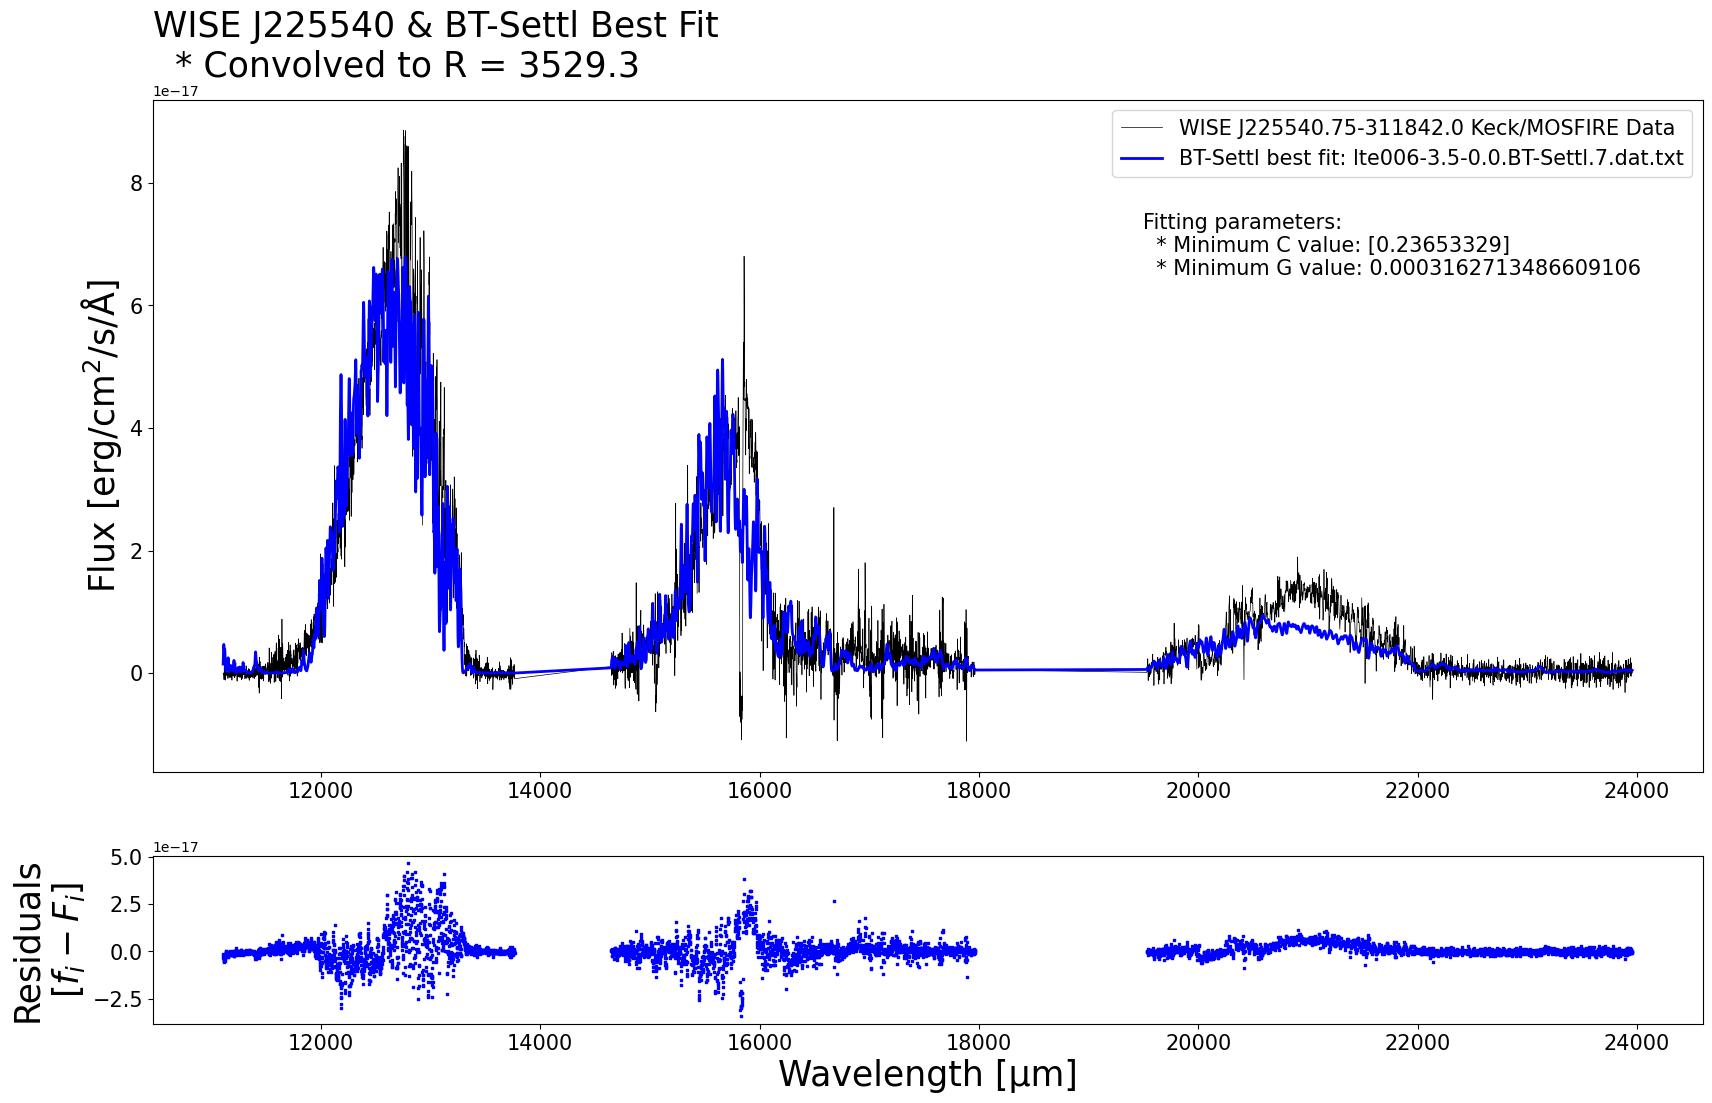

In [5]:
def bestfit_bt(obs_path, mod_path, t, res, modelname):
    '''
    This function takes the observation file path and the model file path, defines the observation wavelength grid,
    convolves the model wavelengths onto that grid, finds the best fit, and plots the observations and best fit together.
    I wish it was more generally parametized, but C'est la vie.
    * Parameters:
        * obs_path: str - the file path to the observed data (pre-defined)
        * mod_path: str - the file path to the model data (pre-defined)
        * t: str - the given name of the observed target (pre-defined)
        * res: int - the instrument resolution for the models to be convolved to (pre-defined)
        * modelname: int - the given name of the model in use (i.e., BT-Settl, ATMO, etc.)
    * Returns:
        * Cmin: arr - the minimum C value of the fit
        * Gmin: int - the minimum G value of the fit
        * bestmodel: str - the file path for the best fit model
        * plot: plot - observational data and the best fit model plotted together
    * Notes:
        * Built to work in tandem with convolve_v2()
        * Data files should be shaped as (wavelength, flux, uncertainty (optional))
        * bestfit_bt is written to work with any models[i].txt file and will plot the best fit in blue.
        * Needs numpy as np, matplotlib.pyplot as plt, and os, glob from glob
    '''
    ## Read in and sort the observational data, and define the resolution for convolve()
    obs = np.loadtxt(obs_path)
    wave_obs = obs[:, 0]
    #flux_obs = obs[:, 1] # original MOSFIRE units
    flux_obs = obs[:, 1] * 1e-4 # units matched to BT-Settl models
    unc_obs = obs[:, 2]

    ## Define the full file path to the models
    models = glob(os.path.join(mod_path, '*.txt'))
    spec = models

    ## Define the C and G grids and loop through the models to interpolate and convolve them
    C = np.zeros(len(models))
    G = np.zeros(len(models))
    low_mod = np.zeros((len(models), 2, (len(wave_obs))))
                           
    for i in range(len(models)):
        data = np.loadtxt(models[i])
        wave = np.where((data[:, 0] > wave_obs[0]) & (data[:, 0] < wave_obs[-1]))

        wl = data[wave, 0][0]
        #flux = data[wave, 1][0] * 1e4
        flux = data[wave, 1][0] * scale_A

        interp_flux = np.interp(wave_obs, wl, flux)
        range_data = np.vstack([wave_obs, interp_flux])
        low_mod[i, :, :] = convolve_v2(range_data, R, 1)

        C[i] = (np.nansum((low_mod[i, 1, :] * flux_obs) / unc_obs ** 2)) / (np.nansum(low_mod[i, 1, :] ** 2 / unc_obs ** 2))
        G[i] = np.nansum(((flux_obs - C[i] * low_mod[i, 1, :]) / unc_obs) ** 2)

    ## Calculate the minima in C and G
    Gmin = np.min(G)
    where_Gmin = np.where(G == Gmin)
    Cmin = C[where_Gmin]

    ## Index minG to the correct model
    modindex = int(where_Gmin[0])
    bestfit = np.loadtxt(models[modindex])
    bestmodel = models[modindex]
    residuals = flux_obs - low_mod[modindex, 1, :] * Cmin

    ## Print the minimum C and G values and the best fit model
    print(f'Minimum C value:         {Cmin}')
    print(f'Minimum G value:         {Gmin}')
    print(f'Best fit {modelname} model: {bestmodel}')

    ## Write the best-fit data to a .txt file
    outfile1 = f'{modelname}_data{[modindex]}.txt'
    outfile2 = f'{modelname}_minC&G{[modindex]}.txt'
    np.savetxt(outfile1, [low_mod[modindex, 0, :], low_mod[modindex, 1, :] * Cmin, residuals])
    np.savetxt(outfile2, [Cmin[0], Gmin])

    ## Plot the best fit model with the observational data
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (20, 12), gridspec_kw = {'height_ratios': [4, 1]})
    ax1.plot(wave_obs, flux_obs, color = 'black', linewidth = 0.5, label = f'{target} Keck/MOSFIRE Data')
    ax1.plot(low_mod[modindex, 0, :], low_mod[modindex, 1, :] * Cmin, color = 'blue', linewidth = 2, label = f'{modelname} best fit: {bestmodel[69:]}')
    ax1.set_title(t + f' & {modelname} Best Fit\n  * Convolved to R = {np.round(R, 1)}', loc = 'left', fontsize = 25)
    ax1.set_ylabel('Flux [erg/cm$^2$/s/Å]', fontsize = 25)
    ax1.tick_params(axis = 'both', which = 'major', labelsize = 15)
    ax1.legend(loc = 'upper right', fontsize = 15, fancybox = True)
    ax1.annotate(f'Fitting parameters:\n  * Minimum C value: {Cmin}\n  * Minimum G value: {Gmin}', (19500, 6.5e-17), fontsize = 15)

    ax2.scatter(wave_obs, residuals, color = 'blue', marker = ',', s = 1)
    ax2.set_xlabel('Wavelength [µm]', fontsize = 25)
    ax2.set_ylabel(f'Residuals\n'r'$[f_i - F_i]$', fontsize=25)
    ax2.tick_params(axis = 'both', which = 'major', labelsize = 15)
    plt.savefig('WISE + BT-Settl Best Fit')

    return

bestfit_bt(file_name, bt_path, target_short, R, 'BT-Settl') 

/var/folders/36/1_bs4p6d4t73n8bdrm6msfsr0005tr/T/ipykernel_84913/1816895485.py:58: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  modindex = int(where_Gmin[0])


Minimum C value:       [135.84343124]
Minimum G value:       0.0376098245220547
Best fit SpeX spectra: /Users/bseamons/Documents/Research/SpeX_archived_spectra/spex-prism_2MASSJ16150413+1340079_20060902_T6.spex.txt


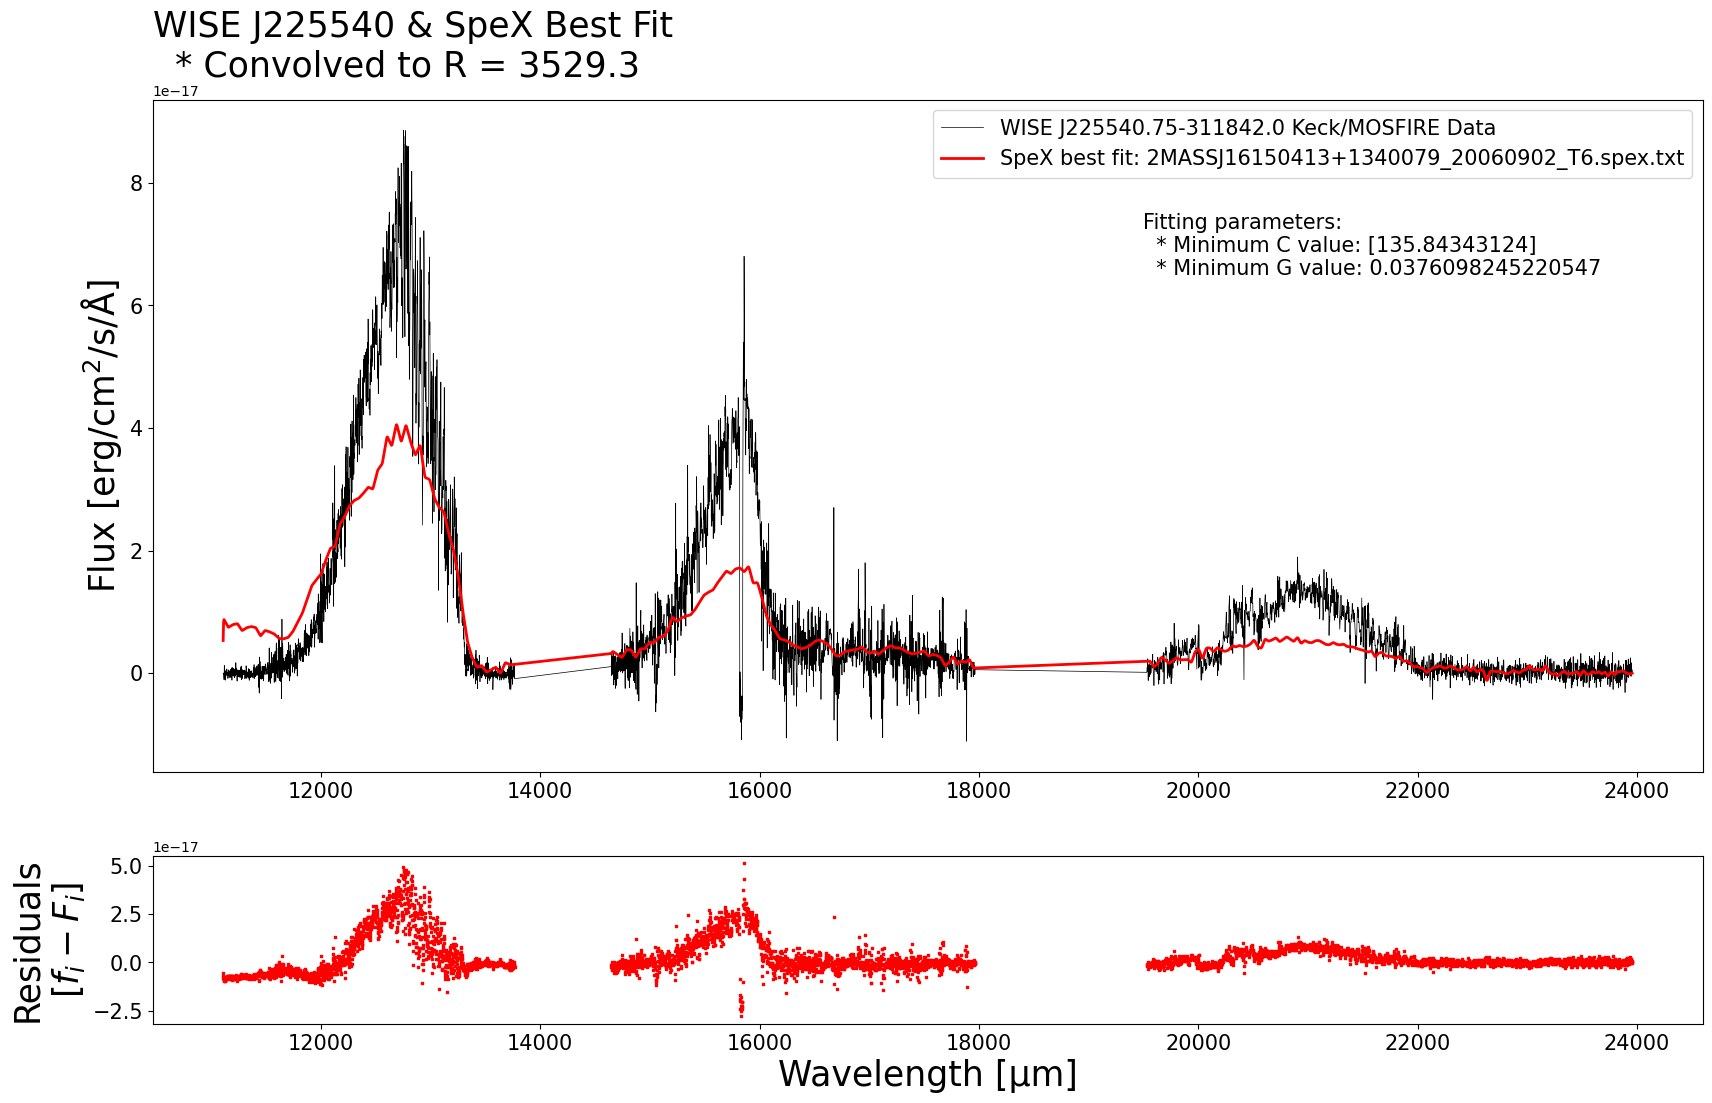

In [6]:
def bestfit_spex(obs_path, mod_path, t, res, modelname):
    '''
    This function takes the observation file path and the model file path, defines the observation wavelength grid,
    convolves the model wavelengths onto that grid, finds the best fit, and plots the observations and best fit together.
    I wish it was more generally parametized, but C'est la vie.
    * Parameters:
        * obs_path: str - the file path to the observed data (pre-defined)
        * mod_path: str - the file path to the model data (pre-defined)
        * t: str - the given name of the observed target (pre-defined)
        * res: int - the instrument resolution for the models to be convolved to (pre-defined)
        * modelname: int - the given name of the model in use (i.e., BT-Settl, ATMO, etc.)
    * Returns:
        * Cmin: arr - the minimum C value of the fit
        * Gmin: int - the minimum G value of the fit
        * bestmodel: str - the file path for the best fit model
        * plot: plot - observational data and the best fit model plotted together
    * Notes:
        * Built to work in tandem with convolve_v2()
        * Data files should be shaped as (wavelength, flux, uncertainty (optional))
        * bestfit_spex is written to work with any models[i].txt file and will plot the best fit in red.
        * Needs numpy as np, matplotlib.pyplot as plt, and os, glob from glob
    '''
    ## Read in and sort the observational data, and define the resolution for convolve()
    obs = np.loadtxt(obs_path)
    wave_obs = obs[:, 0]
    flux_obs = obs[:, 1] * 1e-4
    unc_obs = obs[:, 2]

    ## Define the full file path to the models
    models = glob(os.path.join(mod_path, '*.txt'))
    spec = models

    ## Define the C and G grids and loop through the models to interpolate and convolve them
    C = np.zeros(len(models))
    G = np.zeros(len(models))
    low_mod = np.zeros((len(models), 2, (len(wave_obs))))

    for i in range(len(models)):
        data = np.loadtxt(models[i])

        wl = data[:, 0] * 1e4
        #flux = data[:,1] * 1e4
        flux = data[:, 1] * scale_A

        interp_flux = np.interp(wave_obs, wl, flux)
        range_data = np.vstack([wave_obs, interp_flux])
        low_mod[i, :, :] = convolve_v2(range_data, R, 1)

        C[i] = (np.nansum((low_mod[i, 1, :] * flux_obs) / unc_obs ** 2)) / (np.nansum(low_mod[i, 1, :] ** 2 / unc_obs ** 2))
        G[i] = np.nansum(((flux_obs[i] - C[i] * low_mod[i, 1, :]) / unc_obs[i]) ** 2)

    ## Calculate the minima in C and G
    Gmin = np.min(G)
    where_Gmin = np.where(G == Gmin)
    Cmin = C[where_Gmin]

    ## Index minG to the correct model
    modindex = int(where_Gmin[0])
    bestfit = np.loadtxt(models[modindex])
    bestmodel = models[modindex]
    residuals = flux_obs - low_mod[modindex, 1, :] * Cmin

    ## Print the minimum C and G values and the best fit model
    print(f'Minimum C value:       {Cmin}')
    print(f'Minimum G value:       {Gmin}')
    print(f'Best fit {modelname} spectra: {bestmodel}')

    ## Write the best-fit data to a .txt file
    outfile1 = f'{modelname}_data{[modindex]}.txt'
    outfile2 = f'{modelname}_minC&G{[modindex]}.txt'
    np.savetxt(outfile1, [low_mod[modindex, 0, :], low_mod[modindex, 1, :] * Cmin, residuals])
    np.savetxt(outfile2, [Cmin[0], Gmin])
    
    ## Plot the best fit model with the observational data
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (20, 12), gridspec_kw = {'height_ratios': [4, 1]})
    ax1.plot(wave_obs, flux_obs, color = 'black', linewidth = 0.5, label = f'{target} Keck/MOSFIRE Data')
    ax1.plot(low_mod[modindex, 0, :], low_mod[modindex, 1, :] * Cmin, color = 'red', linewidth = 2, label = f'{modelname} best fit: {bestmodel[68:]}')
    ax1.set_title(t + f' & {modelname} Best Fit\n  * Convolved to R = {np.round(R, 1)}', loc = 'left', fontsize = 25)
    ax1.set_ylabel('Flux [erg/cm$^2$/s/Å]', fontsize = 25)
    ax1.tick_params(axis = 'both', which = 'major', labelsize = 15)
    ax1.legend(loc = 'upper right', fontsize = 15, fancybox = True)
    ax1.annotate(f'Fitting parameters:\n  * Minimum C value: {Cmin}\n  * Minimum G value: {Gmin}', (19500, 6.5e-17), fontsize = 15)

    ax2.scatter(wave_obs, residuals, color = 'red', marker = ',', s = 1)
    ax2.set_xlabel('Wavelength [µm]', fontsize = 25)
    ax2.set_ylabel(f'Residuals\n'r'$[f_i - F_i]$', fontsize=25)
    ax2.tick_params(axis = 'both', which = 'major', labelsize = 15)
    plt.savefig('WISE + SpeX Best Fit')

    #plt.annotate(f'{bestmodel[68:]}:\n  * Optical spectral type: T7\n  * NIR spectral type: T6p\n  * J mag = 14.648\n  * H mag = 14.703\n  * Ks mag = 15.267\n  * Minimum C value: {Cmin}\n  * Minimum G value: {Gmin}', (17300, 2.5e-17), fontsize = 15)

    return

bestfit_spex(file_name, spex_path, target_short, R, 'SpeX')

/var/folders/36/1_bs4p6d4t73n8bdrm6msfsr0005tr/T/ipykernel_84913/2028493293.py:58: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  modindex = int(where_Gmin[0])


Minimum C value:     [4.67087164e+18]
Minimum G value:     0.07001984344658284
Best fit ATMO model: /Users/bseamons/Documents/Research/atmo_models/spec_jwst_t500_g5.5_p0_kg_g1.25.dat


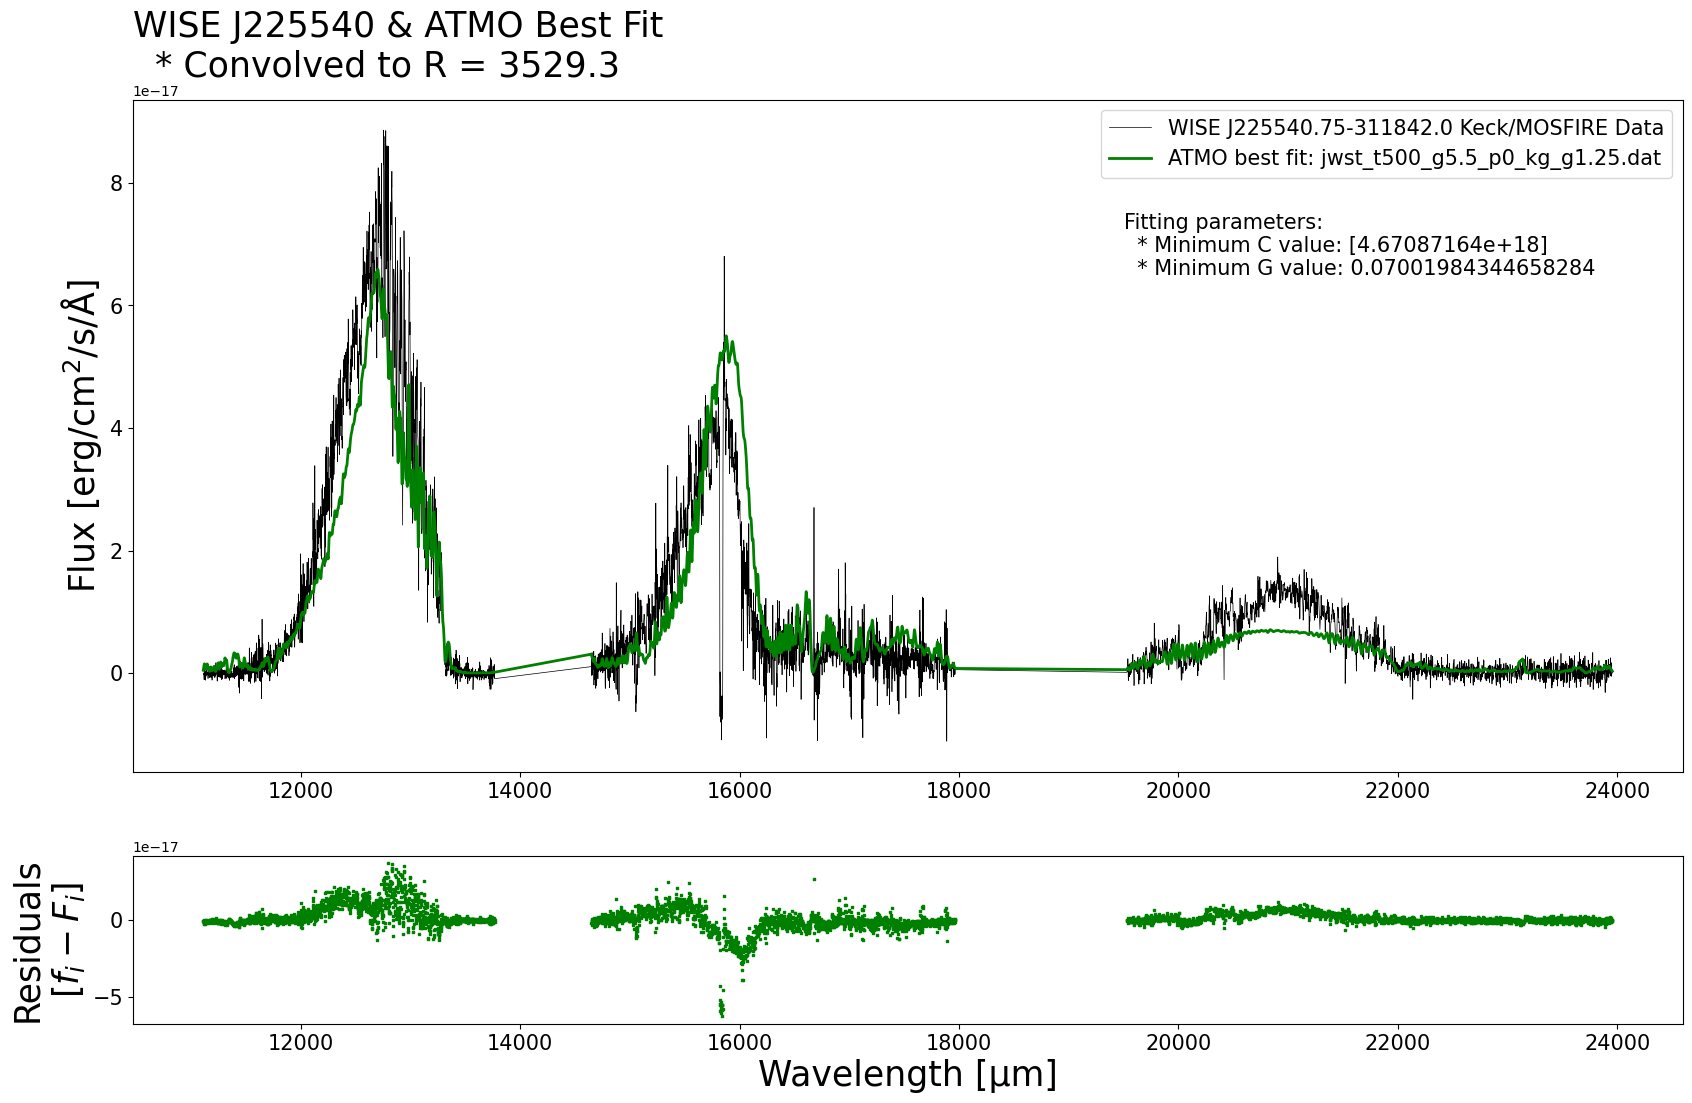

In [7]:
def bestfit_atmo(obs_path, mod_path, t, res, modelname):
    '''
    This function takes the observation file path and the model file path, defines the observation wavelength grid,
    convolves the model wavelengths onto that grid, finds the best fit, and plots the observations and best fit together.
    I wish it was more generally parametized, but C'est la vie.
    * Parameters:
        * obs_path: str - the file path to the observed data (pre-defined)
        * mod_path: str - the file path to the model data (pre-defined)
        * t: str - the given name of the observed target (pre-defined)
        * res: int - the instrument resolution for the models to be convolved to (pre-defined)
        * modelname: int - the given name of the model in use (i.e., BT-Settl, ATMO, etc.)
    * Returns:
        * Cmin: arr - the minimum C value of the fit
        * Gmin: int - the minimum G value of the fit
        * bestmodel: str - the file path for the best fit model
        * plot: plot - observational data and the best fit model plotted together
    * Notes:
        * Built to work in tandem with convolve_v2()
        * Data files should be shaped as (wavelength, flux, uncertainty (optional))
        * bestfit_atmo is written to work with any models[i].dat file and will plot the best fit in green.
        * Needs numpy as np, matplotlib.pyplot as plt, and os, glob from glob
    '''
    ## Read in and sort the observational data, and define the resolution for convolve()
    obs = np.loadtxt(obs_path)
    wave_obs = obs[:, 0]
    flux_obs = obs[:, 1] * 1e-4
    unc_obs = obs[:, 2]

    ## Define the full file path to the models
    models = glob(os.path.join(mod_path, '*.dat'))
    spec = models

    ## Define the C and G grids and loop through the models to interpolate and convolve them
    C = np.zeros(len(models))
    G = np.zeros(len(models))
    low_mod = np.zeros((len(models), 2, (len(wave_obs))))
    
    for i in range(len(models)):
        data = np.loadtxt(models[i])

        wl = data[:, 0] * 1e4
        #flux = data[:,1] * 1e4
        flux = data[:, 1] * scale_A

        interp_flux = np.interp(wave_obs, wl, flux)
        range_data = np.vstack([wave_obs, interp_flux])
        low_mod[i, :, :] = convolve_v2(range_data, R, 1)

        C[i] = (np.nansum((low_mod[i, 1, :] * flux_obs) / unc_obs ** 2)) / (np.nansum(low_mod[i, 1, :] ** 2 / unc_obs ** 2))
        G[i] = np.nansum(((flux_obs[i] - C[i] * low_mod[i, 1, :]) / unc_obs[i]) ** 2)

    ## Calculate the minima in C and G
    Gmin = np.min(G)
    where_Gmin = np.where(G == Gmin)
    Cmin = C[where_Gmin]

    ## Index minG to the correct model
    modindex = int(where_Gmin[0])
    bestfit = np.loadtxt(models[modindex])
    bestmodel = models[modindex]
    residuals = flux_obs - low_mod[modindex, 1, :] * Cmin


    ## Print the minimum C and G values and the best fit model
    print(f'Minimum C value:     {Cmin}')
    print(f'Minimum G value:     {Gmin}')
    print(f'Best fit {modelname} model: {bestmodel}')

    ## Write the best-fit data to a .txt file
    outfile1 = f'{modelname}_data{[modindex]}.txt'
    outfile2 = f'{modelname}_minC&G{[modindex]}.txt'
    np.savetxt(outfile1, [low_mod[modindex, 0, :], low_mod[modindex, 1, :] * Cmin, residuals])
    np.savetxt(outfile2, [Cmin[0], Gmin])

    ## Plot the best fit model with the observational data
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (20, 12), gridspec_kw = {'height_ratios': [4, 1]})
    ax1.plot(wave_obs, flux_obs, color = 'black', linewidth = 0.5, label = f'{target} Keck/MOSFIRE Data')
    ax1.plot(low_mod[modindex, 0, :], low_mod[modindex, 1, :] * Cmin, color = 'green', linewidth = 2, label = f'{modelname} best fit: {bestmodel[52:]}')
    ax1.set_title(t + f' & {modelname} Best Fit\n  * Convolved to R = {np.round(R, 1)}', loc = 'left', fontsize = 25)
    ax1.set_ylabel('Flux [erg/cm$^2$/s/Å]', fontsize = 25)
    ax1.tick_params(axis = 'both', which = 'major', labelsize = 15)
    ax1.legend(loc = 'upper right', fontsize = 15, fancybox = True)
    ax1.annotate(f'Fitting parameters:\n  * Minimum C value: {Cmin}\n  * Minimum G value: {Gmin}', (19500, 6.5e-17), fontsize = 15)


    ax2.scatter(wave_obs, residuals, color = 'green', marker = ',', s = 1)
    ax2.set_xlabel('Wavelength [µm]', fontsize = 25)
    ax2.set_ylabel(f'Residuals\n'r'$[f_i - F_i]$', fontsize=25)
    ax2.tick_params(axis = 'both', which = 'major', labelsize = 15)
    plt.savefig('WISE + ATMO Best Fit')

    #plt.annotate(f'{bestmodel[52:]}:\n  * t$_e$$_f$$_f$ = 400 K\n  * logg = 4.5\n\n  * Minimum C value: {Cmin}\n  * Minimum G value: {Gmin}', (18000, 2.5e-17), fontsize = 25)

    return

bestfit_atmo(file_name, atmo_path, target_short, R, 'ATMO')

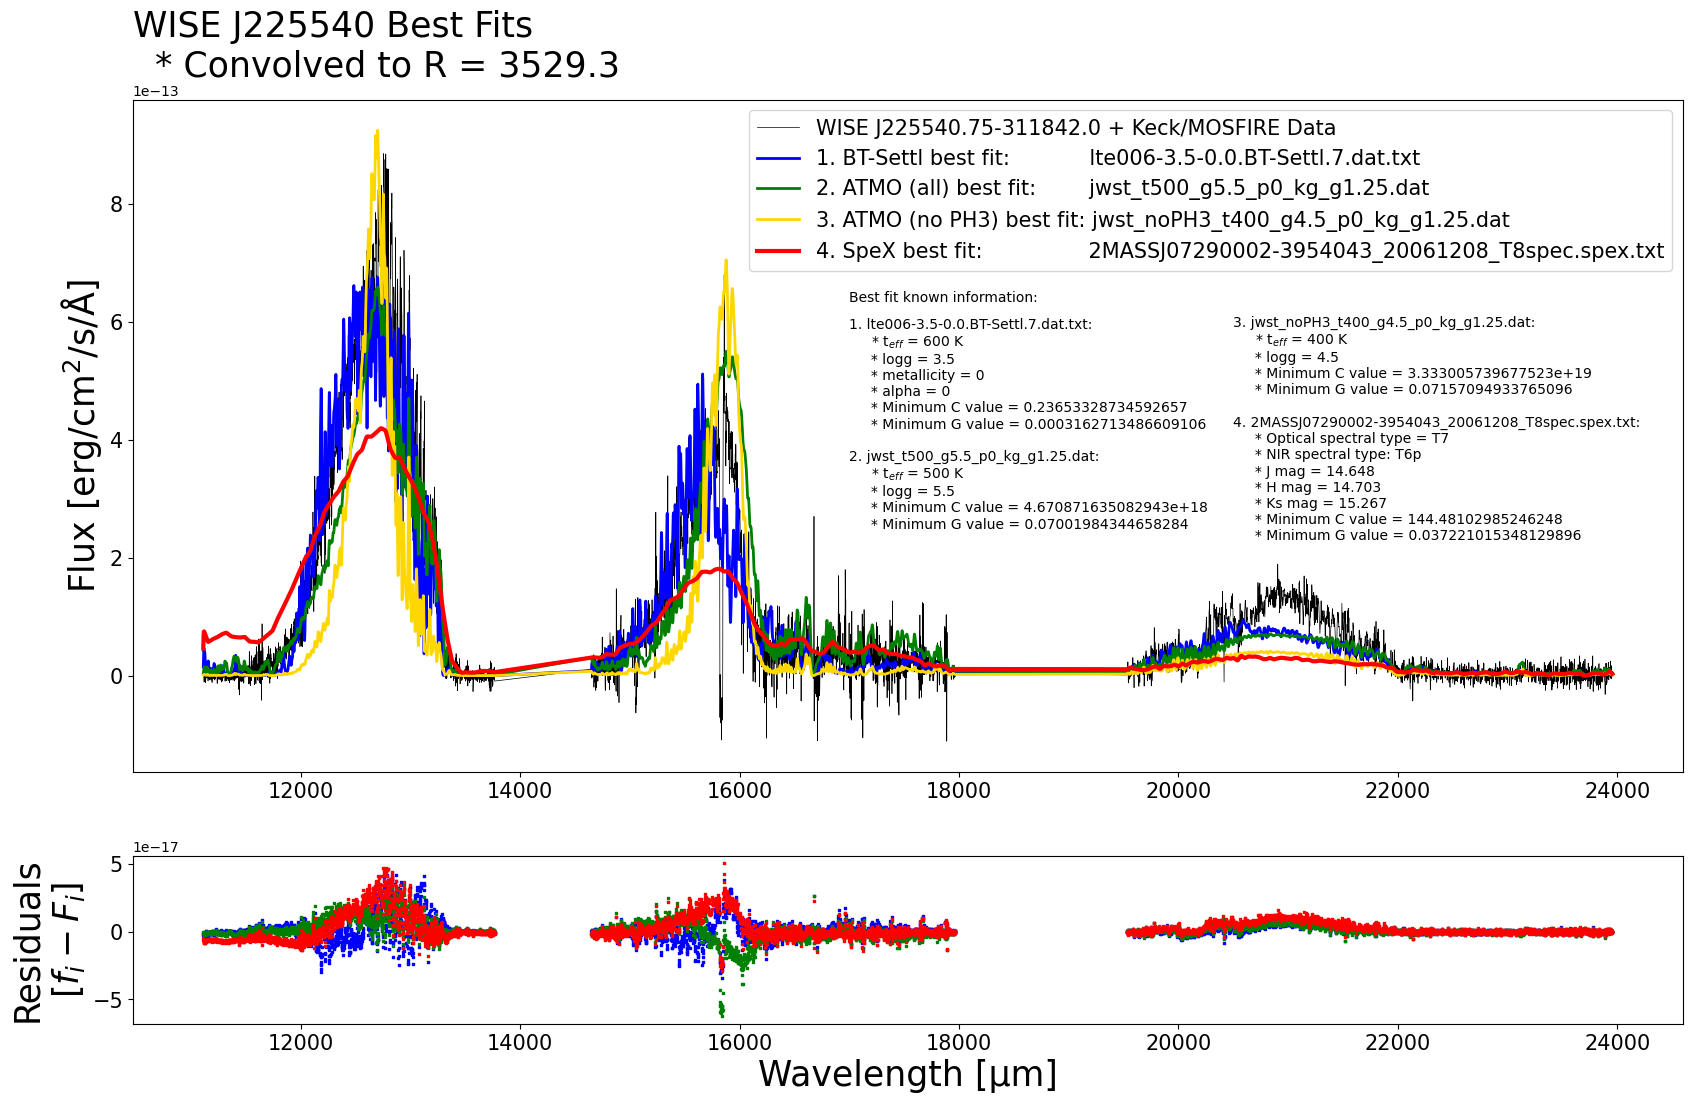

In [8]:
bdat = np.loadtxt('BT-Settl_data[27].txt')
b_CG = np.loadtxt('BT-Settl_minC&G[27].txt')
bwave = bdat[0, :]
bflux = bdat[1, :] * 1e4
bresiduals = bdat[2, :]
bC = b_CG[0]
bG = b_CG[1]

adat = np.loadtxt('ATMO_data[6].txt')
a_CG = np.loadtxt('ATMO_minC&G[6].txt')
awave = adat[0, :]
aflux = adat[1, :]
aresiduals = adat[2, :]
aC = a_CG[0]
aG = a_CG[1]

adat_noPH3 = np.loadtxt('ATMO no PH3_data[12].txt')
adat_noPH3_CG = np.loadtxt('ATMO no PH3_minC&G[12].txt')
anoPH3_wave = adat_noPH3[0, :]
anoPH3_flux = adat_noPH3[1, :]
anoPH3C = adat_noPH3_CG[0]
anoPH3G = adat_noPH3_CG[1]

sdat = np.loadtxt('SpeX_data[20].txt')
s_CG = np.loadtxt('SpeX_minC&G[20].txt')
swave = sdat[0, :]
sflux = sdat[1, :]
sresiduals = sdat[2, :]
sC = s_CG[0]
sG = s_CG[1]

string1 = f'{bt_models[27][69:]}:\n     * t$_e$$_f$$_f$ = 600 K\n     * logg = 3.5\n     * metallicity = 0\n     * alpha = 0\n     * Minimum C value = {bC}\n     * Minimum G value = {bG}\n\n'
string2 = f'{atmo_models[6][52:]}:\n     * t$_e$$_f$$_f$ = 500 K\n     * logg = 5.5\n     * Minimum C value = {aC}\n     * Minimum G value = {aG}'
string3 = f'{atmo_models[25][52:]}:\n     * t$_e$$_f$$_f$ = 400 K\n     * logg = 4.5\n     * Minimum C value = {anoPH3C}\n     * Minimum G value = {anoPH3G}\n\n'
string4 = f'{spex_models[20][68:]}:\n     * Optical spectral type = T7\n     * NIR spectral type: T6p\n     * J mag = 14.648\n     * H mag = 14.703\n     * Ks mag = 15.267\n     * Minimum C value = {sC}\n     * Minimum G value = {sG}'

fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (20, 12), gridspec_kw = {'height_ratios': [4, 1]})
ax1.plot(wave, flux, color = 'black', linewidth = 0.5, label = f'{target} + Keck/MOSFIRE Data')
ax1.plot(bwave, bflux, color = 'blue', linewidth = 2, label = f'1. BT-Settl best fit:            {bt_models[27][69:]}')
ax1.plot(awave, aflux * 1e4, color = 'green', linewidth = 2, label = f'2. ATMO (all) best fit:        {atmo_models[6][52:]}')
ax1.plot(anoPH3_wave, anoPH3_flux * 1e4, color = 'gold', linewidth = 2, label = f'3. ATMO (no PH3) best fit: {atmo_models[25][52:]}')
ax1.plot(swave, sflux * 1e4, color = 'red', linewidth = 3, label = f'4. SpeX best fit:                {spex_models[20][68:]}')
ax1.set_title(f'{target_short} Best Fits\n  * Convolved to R = {np.round(R, 1)}', loc = 'left', fontsize = 25)
ax1.set_ylabel(f'Flux [erg/cm$^2$/s/Å]', fontsize = 25)
ax1.tick_params(axis = 'both', which = 'major', labelsize = 15)
ax1.legend(loc = 'upper right', fontsize = 15, fancybox = True)
ax1.annotate(f'Best fit known information:\n\n', (17000, 5.8e-13), fontsize = 10)
ax1.annotate(f'1. {string1}2. {string2}', (17000, 2.5e-13), fontsize = 10)
ax1.annotate(f'3. {string3}4. {string4}', (20500, 2.3e-13), fontsize = 10)

ax2.scatter(wave, bresiduals, color = 'blue', marker = ',', s = 1)
ax2.scatter(wave, aresiduals, color = 'green', marker = ',', s = 1)
ax2.scatter(wave, sresiduals, color = 'red', marker = ',', s = 1)
ax2.set_xlabel('Wavelength [µm]', fontsize = 25)
ax2.set_ylabel(f'Residuals\n'r'$[f_i - F_i]$', fontsize=25)
ax2.tick_params(axis = 'both', which = 'major', labelsize = 15)

#plt.savefig('WISE + All Best Fits')

/var/folders/36/1_bs4p6d4t73n8bdrm6msfsr0005tr/T/ipykernel_84913/1240339318.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  modindex = int(where_Gmin[0])


Minimum C value:     [135.84343124]
Minimum G value:     0.0376098245220547
Best fit SpeX All model: /Users/bseamons/Documents/Research/SpeX_archived_spectra/spex-prism_2MASSJ16150413+1340079_20060902_T6.spex.txt


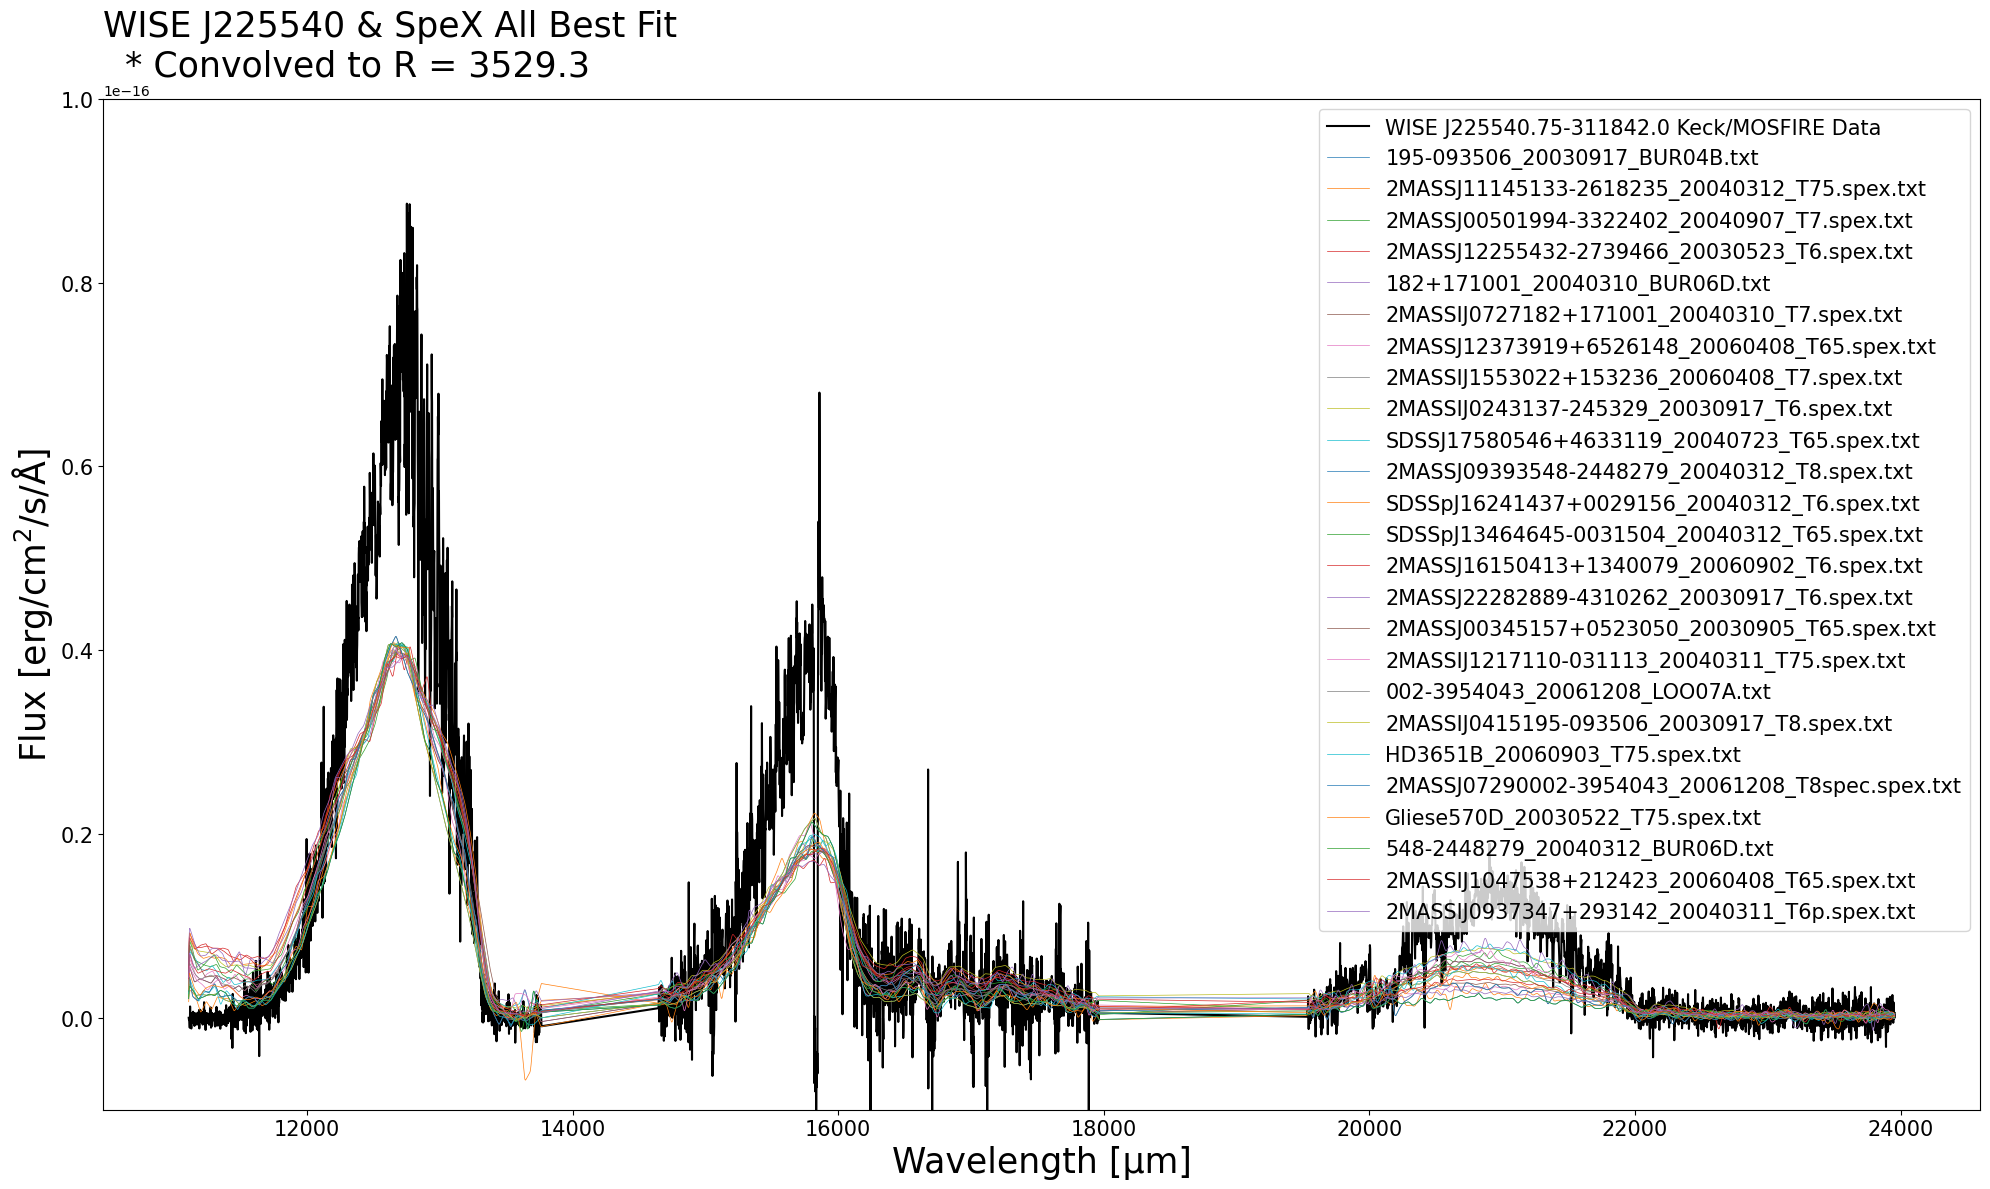

In [9]:
def bestfit_spexall(obs_path, mod_path, t, res, modelname):
    '''
    This function takes the observation file path and the model file path, defines the observation wavelength grid,
    convolves the model wavelengths onto that grid, finds the best fit, and plots the observations and best fit together.
    I wish it was more generally parametized, but C'est la vie.
    * Parameters:
        * obs_path: str - the file path to the observed data (pre-defined)
        * mod_path: str - the file path to the model data (pre-defined)
        * t: str - the given name of the observed target (pre-defined)
        * res: int - the instrument resolution for the models to be convolved to (pre-defined)
        * modelname: int - the given name of the model in use (i.e., BT-Settl, ATMO, etc.)
    * Returns:
        * Cmin: arr - the minimum C value of the fit
        * Gmin: int - the minimum G value of the fit
        * bestmodel: str - the file path for the best fit model
        * plot: plot - observational data and the best fit model plotted together
    * Notes:
        * Built to work in tandem with convolve_v2()
        * Data files should be shaped as (wavelength, flux, uncertainty (optional))
        * bestfit_atmo is written to work with any models[i].dat file and will plot the best fit in green.
        * Needs numpy as np, matplotlib.pyplot as plt, and os, glob from glob
    '''
    ## Read in and sort the observational data, and define the resolution for convolve()
    obs = np.loadtxt(obs_path)
    wave_obs = obs[:, 0]
    flux_obs = obs[:, 1] * 1e-4
    unc_obs = obs[:, 2]

    ## Define the full file path to the models
    models = glob(os.path.join(mod_path, '*.txt'))
    spec = models

    ## Define the C and G grids and loop through the models to interpolate and convolve them
    C = np.zeros(len(models))
    G = np.zeros(len(models))
    low_mod = np.zeros((len(models), 2, (len(wave_obs))))
    
    output_files = []
    for i in range(len(models)):
        data = np.loadtxt(models[i])

        wl = data[:, 0] * 1e4
        #flux = data[:,1] * 1e4
        flux = data[:, 1] * scale_A

        interp_flux = np.interp(wave_obs, wl, flux)
        range_data = np.vstack([wave_obs, interp_flux])
        low_mod[i, :, :] = convolve_v2(range_data, R, 1)

        C[i] = (np.nansum((low_mod[i, 1, :] * flux_obs) / unc_obs ** 2)) / (np.nansum(low_mod[i, 1, :] ** 2 / unc_obs ** 2))
        G[i] = np.nansum(((flux_obs[i] - C[i] * low_mod[i, 1, :]) / unc_obs[i]) ** 2)

    ## Calculate the minima in C and G
    Gmin = np.min(G)
    where_Gmin = np.where(G == Gmin)
    Cmin = C[where_Gmin]

    ## Index minG to the correct model
    modindex = int(where_Gmin[0])
    bestfit = np.loadtxt(models[modindex])
    bestmodel = models[modindex]

    ## Print the minimum C and G values and the best fit model
    print(f'Minimum C value:     {Cmin}')
    print(f'Minimum G value:     {Gmin}')
    print(f'Best fit {modelname} model: {bestmodel}')

    ## Write the best-fit data to a .txt file
    outfile1 = f'{modelname}_data{[modindex]}.txt'
    outfile2 = f'{modelname}_minC&G{[modindex]}.txt'
    np.savetxt(outfile1, [low_mod[modindex, 0, :], low_mod[modindex, 1, :] * Cmin])
    np.savetxt(outfile2, [Cmin[0], Gmin])

    ## Plot the best fit model with the observational data
    plt.figure(figsize = (20, 12))
    
    plt.plot(wave_obs, flux_obs, color = 'black', label = f'{target} Keck/MOSFIRE Data')
    for i in range(len(models)):
        plt.plot(low_mod[i, 0, :], low_mod[i, 1, :] * Cmin, linewidth = 0.5, label = f'{spextra[i][68:]}')

    plt.title(t + f' & {modelname} Best Fit\n  * Convolved to R = {np.round(R, 1)}', loc = 'left', fontsize = 25)
    plt.xlabel('Wavelength [µm]', fontsize = 25)
    plt.ylabel('Flux [erg/cm$^2$/s/Å]', fontsize = 25)
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)
    plt.legend(loc = 'upper right', fontsize = 15, fancybox = True)
    plt.ylim(-1e-17, 1e-16)
    #plt.annotate(f'{bestmodel[52:]}:\n  * t$_e$$_f$$_f$ = 400 K\n  * logg = 4.5\n\n  * Minimum C value: {Cmin}\n  * Minimum G value: {Gmin}', (18000, 2.5e-17), fontsize = 25)
    plt.tight_layout()
    #plt.savefig('WISE + ATMO Best Fit')

    return


s_path = '/Users/bseamons/Documents/Research/SpeX_archived_spectra/'
spextra = glob(os.path.join(s_path, '*.txt'))

bestfit_spexall(file_name, s_path, target_short, R, 'SpeX All')

In [10]:
spex_T6_path = '/Users/bseamons/Documents/Research/SpeX_archived_spectra/Grouped/T6/'
spex_T6 = glob(os.path.join(spex_T6_path, '*.txt'))

spex_T65_path = '/Users/bseamons/Documents/Research/SpeX_archived_spectra/Grouped/T6.5/'
spex_T65 = glob(os.path.join(spex_T65_path, '*.txt'))

spex_T7_path = '/Users/bseamons/Documents/Research/SpeX_archived_spectra/Grouped/T7/'
spex_T7 = glob(os.path.join(spex_T7_path, '*.txt'))

spex_T75_path = '/Users/bseamons/Documents/Research/SpeX_archived_spectra/Grouped/T7.5/'
spex_T75 = glob(os.path.join(spex_T75_path, '*.txt'))

spex_T8_path = '/Users/bseamons/Documents/Research/SpeX_archived_spectra/Grouped/T8/'
spex_T8 = glob(os.path.join(spex_T8_path, '*.txt'))

/var/folders/36/1_bs4p6d4t73n8bdrm6msfsr0005tr/T/ipykernel_84913/3257286022.py:48: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  modindex1 = int(where_G1min[0])
/var/folders/36/1_bs4p6d4t73n8bdrm6msfsr0005tr/T/ipykernel_84913/3257286022.py:76: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  modindex2 = int(where_G2min[0])
/var/folders/36/1_bs4p6d4t73n8bdrm6msfsr0005tr/T/ipykernel_84913/3257286022.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  modindex3 = int(w

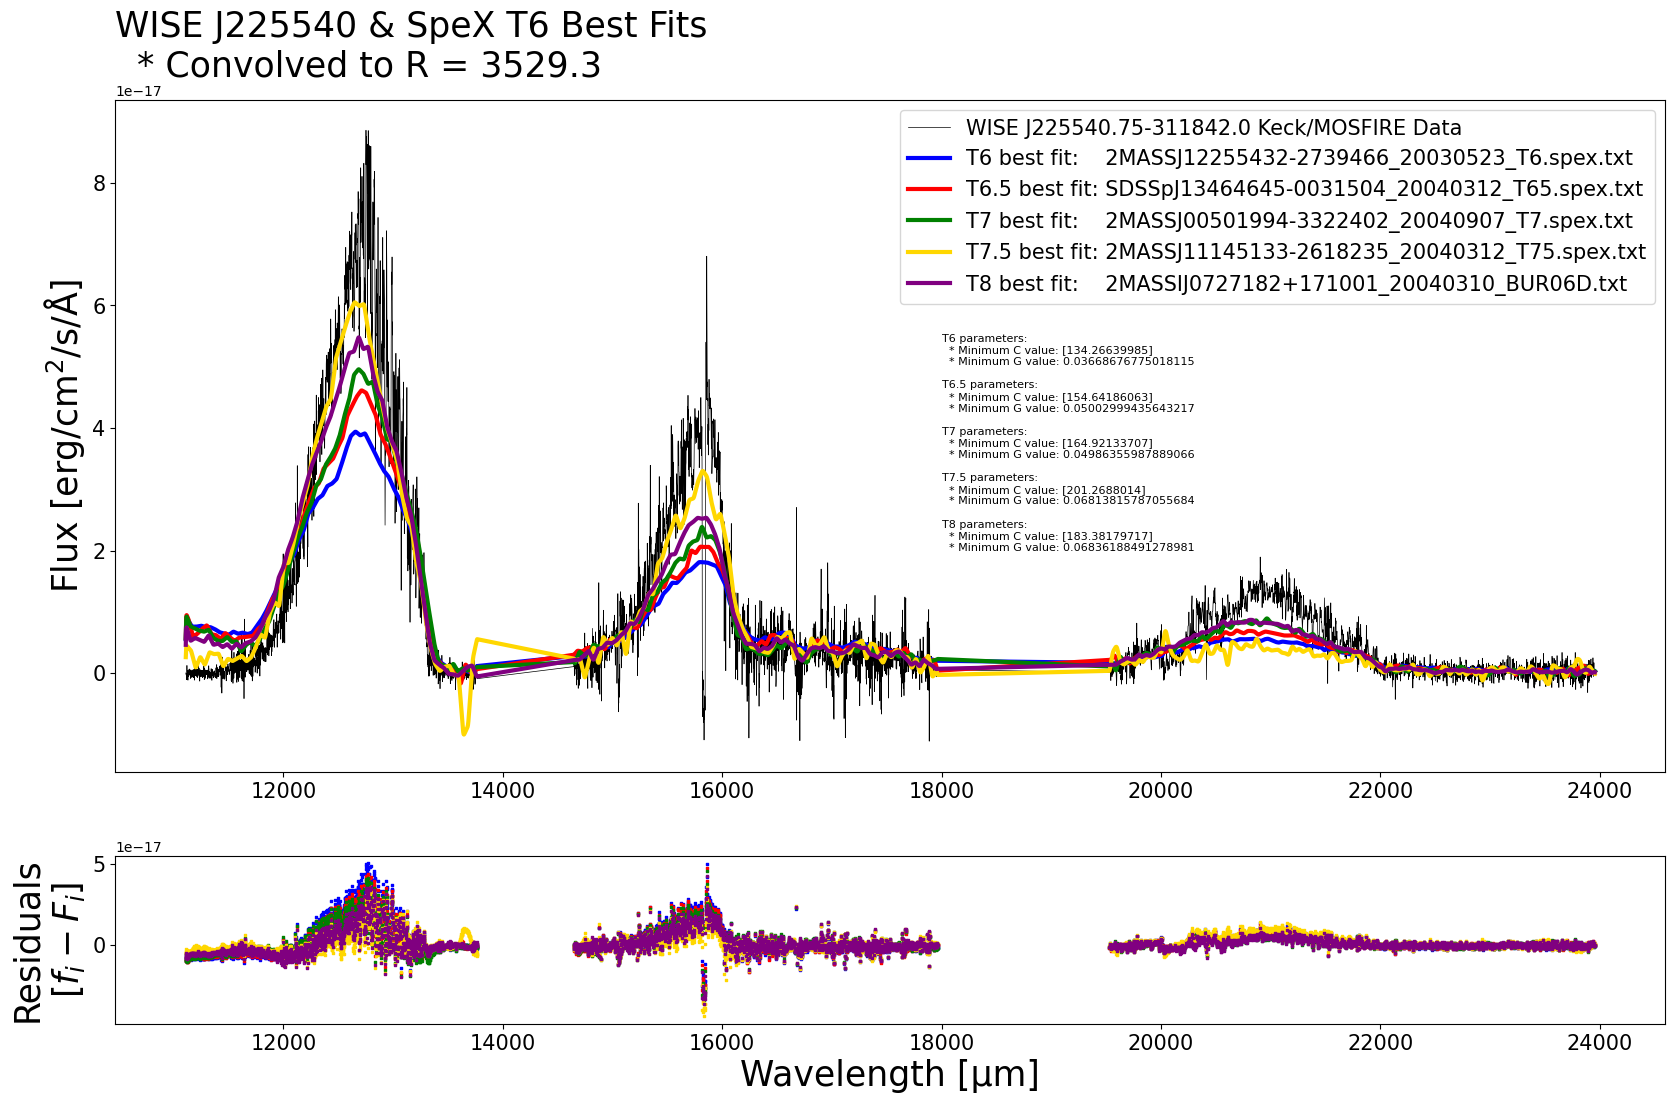

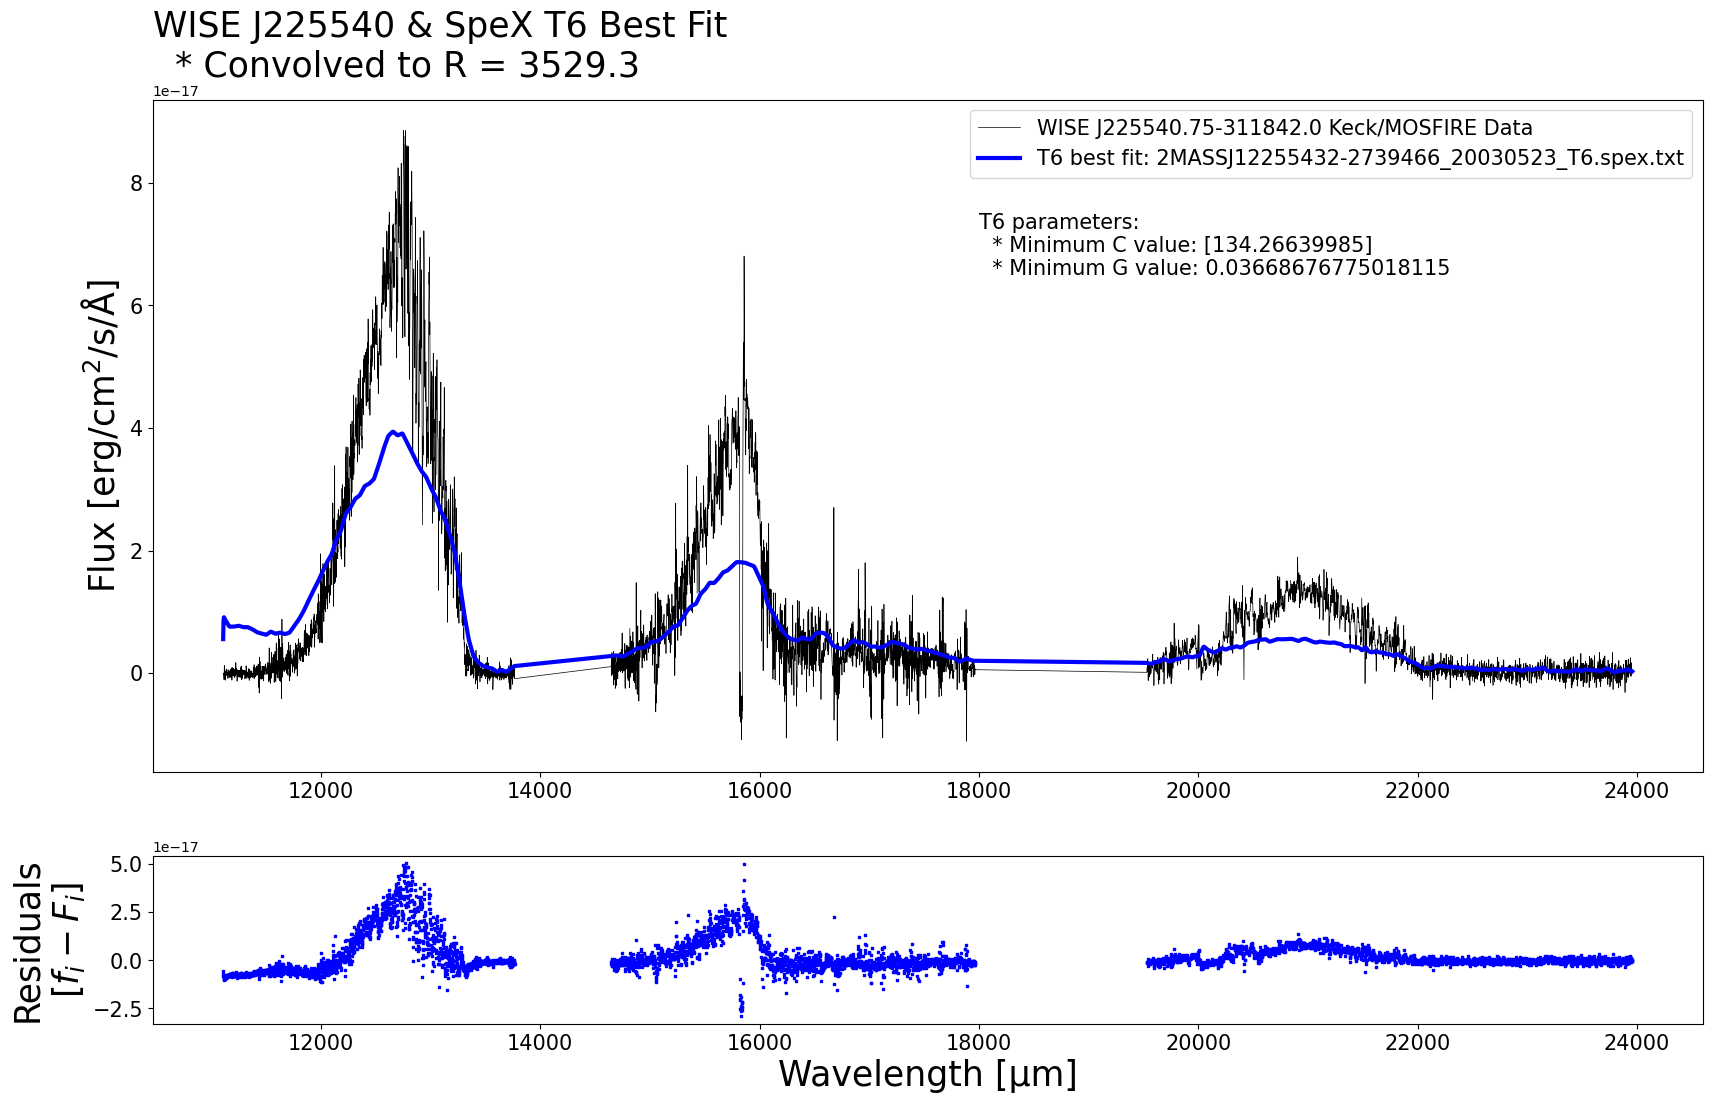

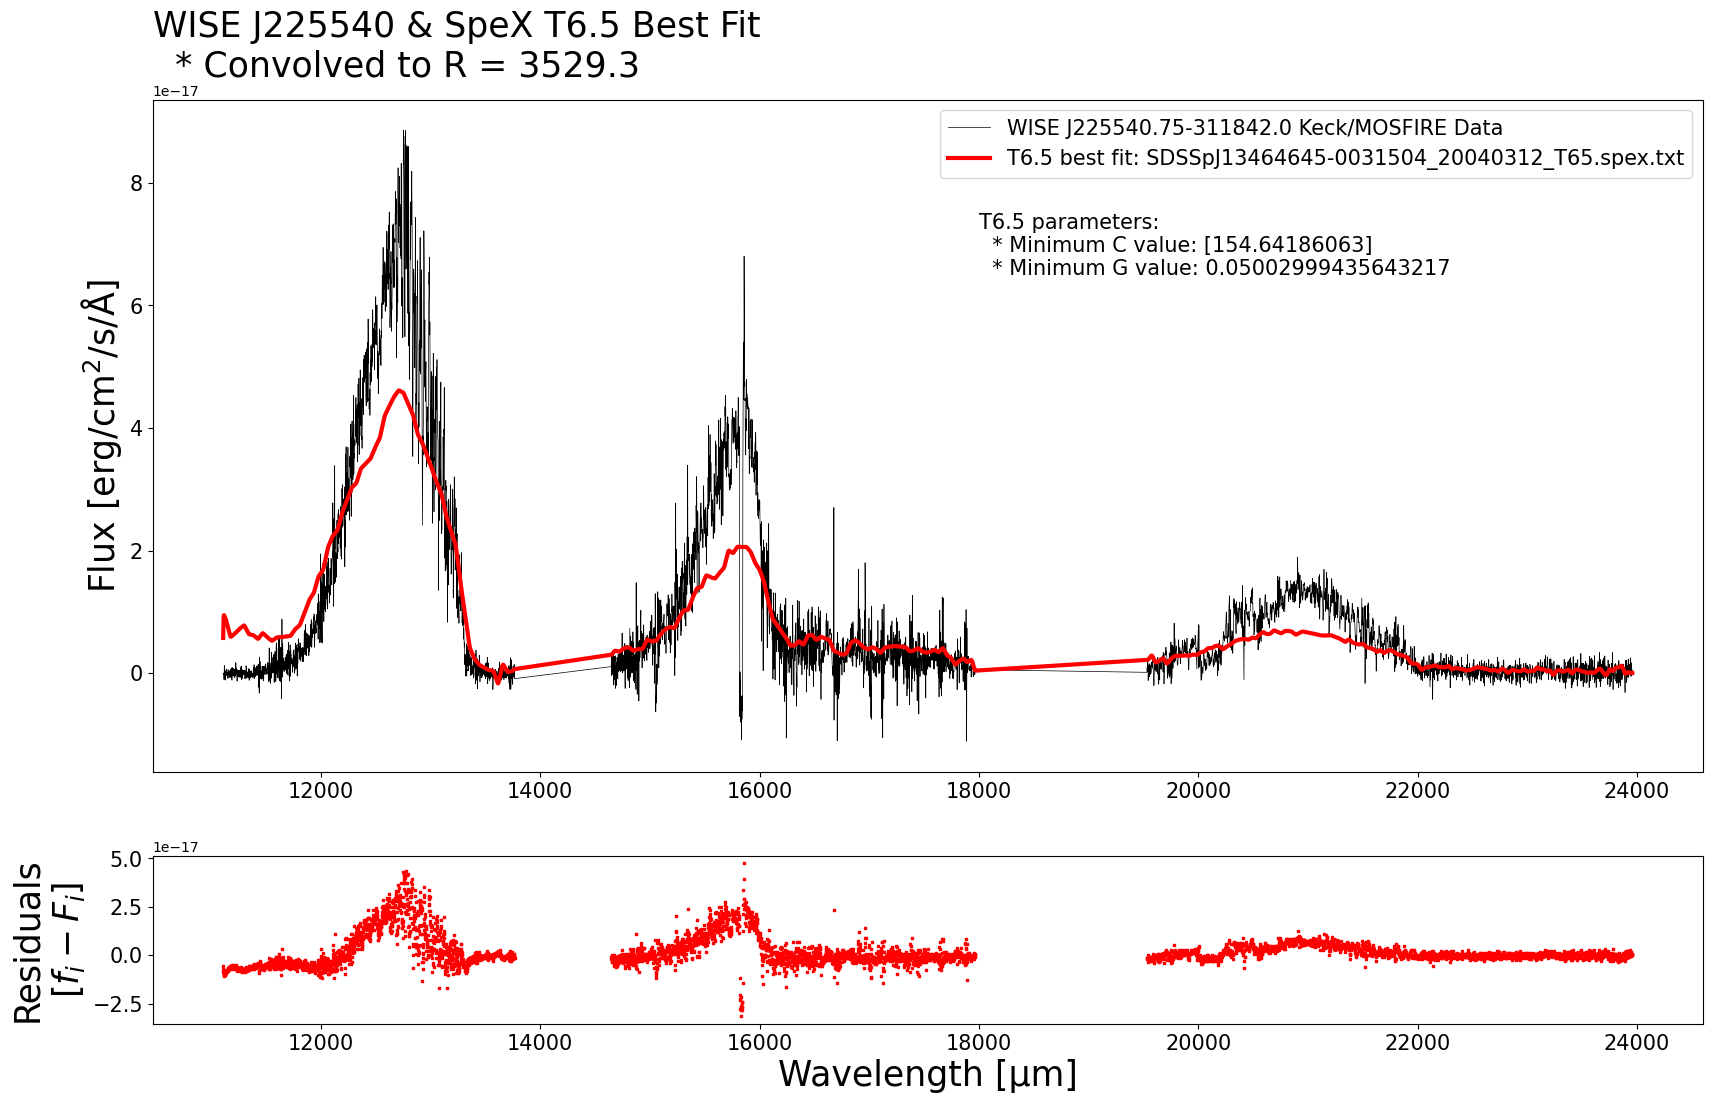

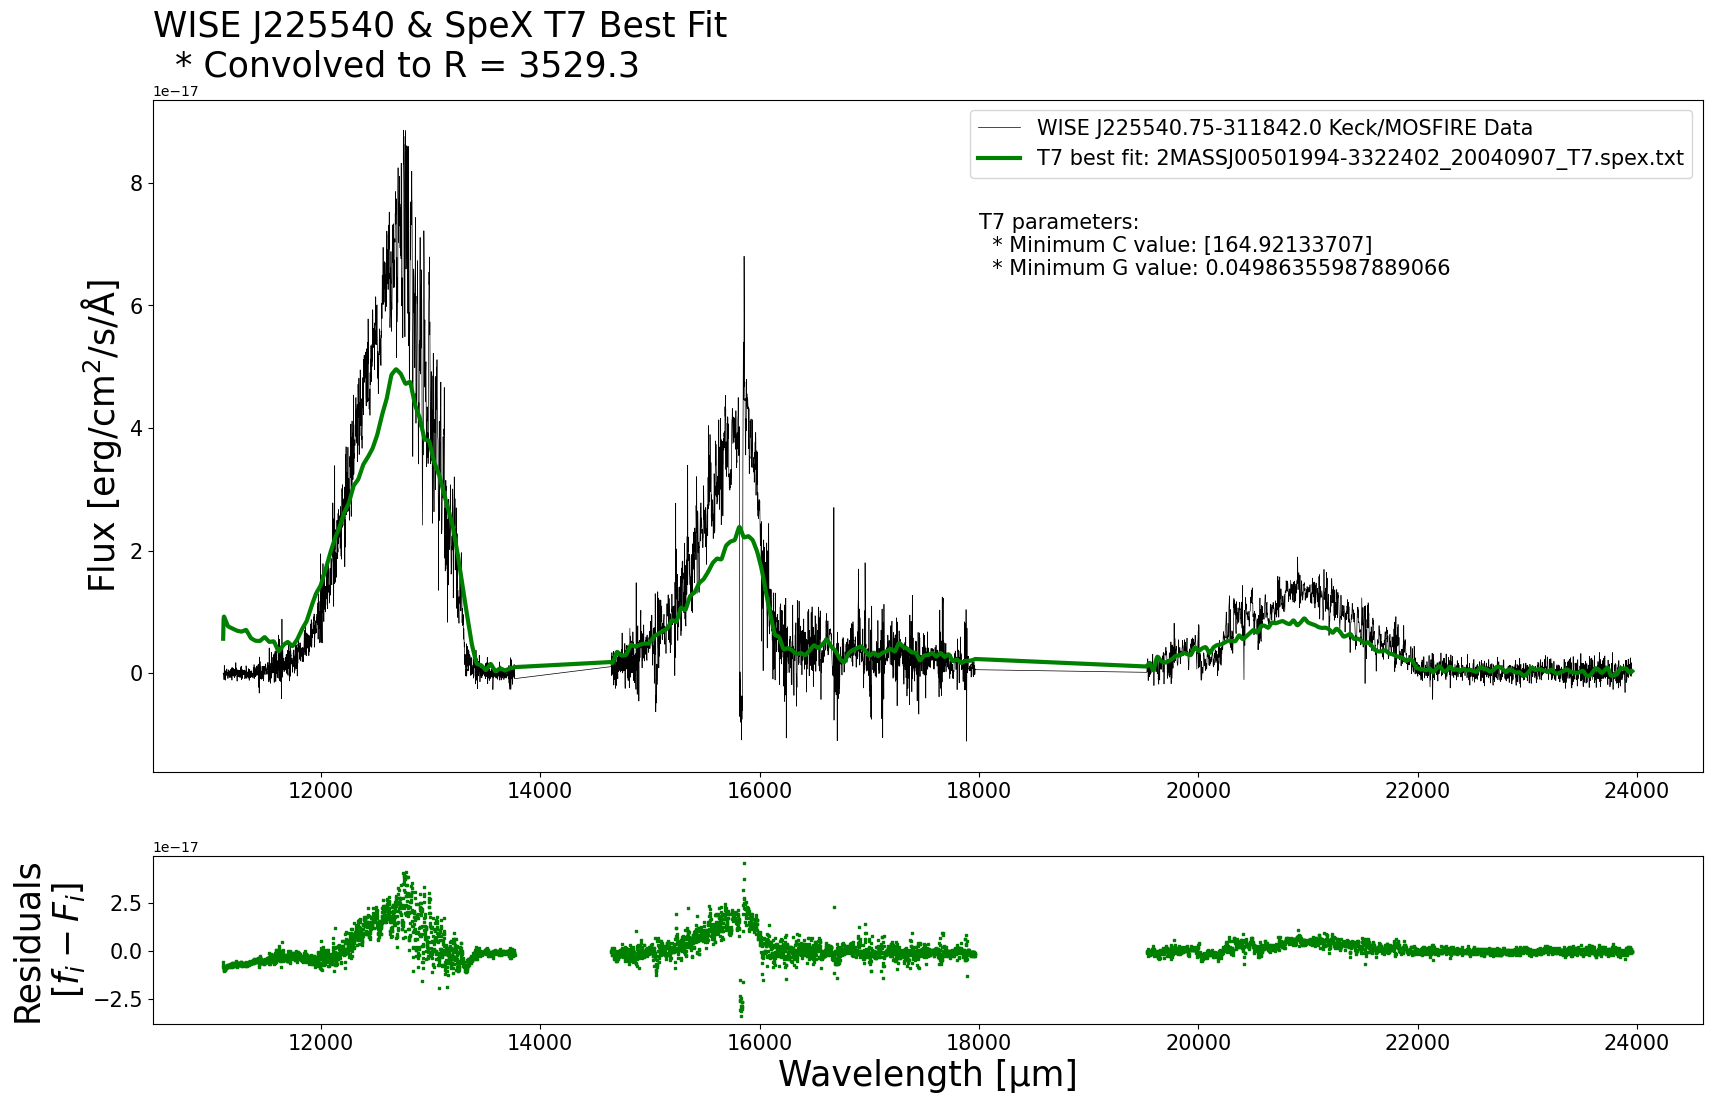

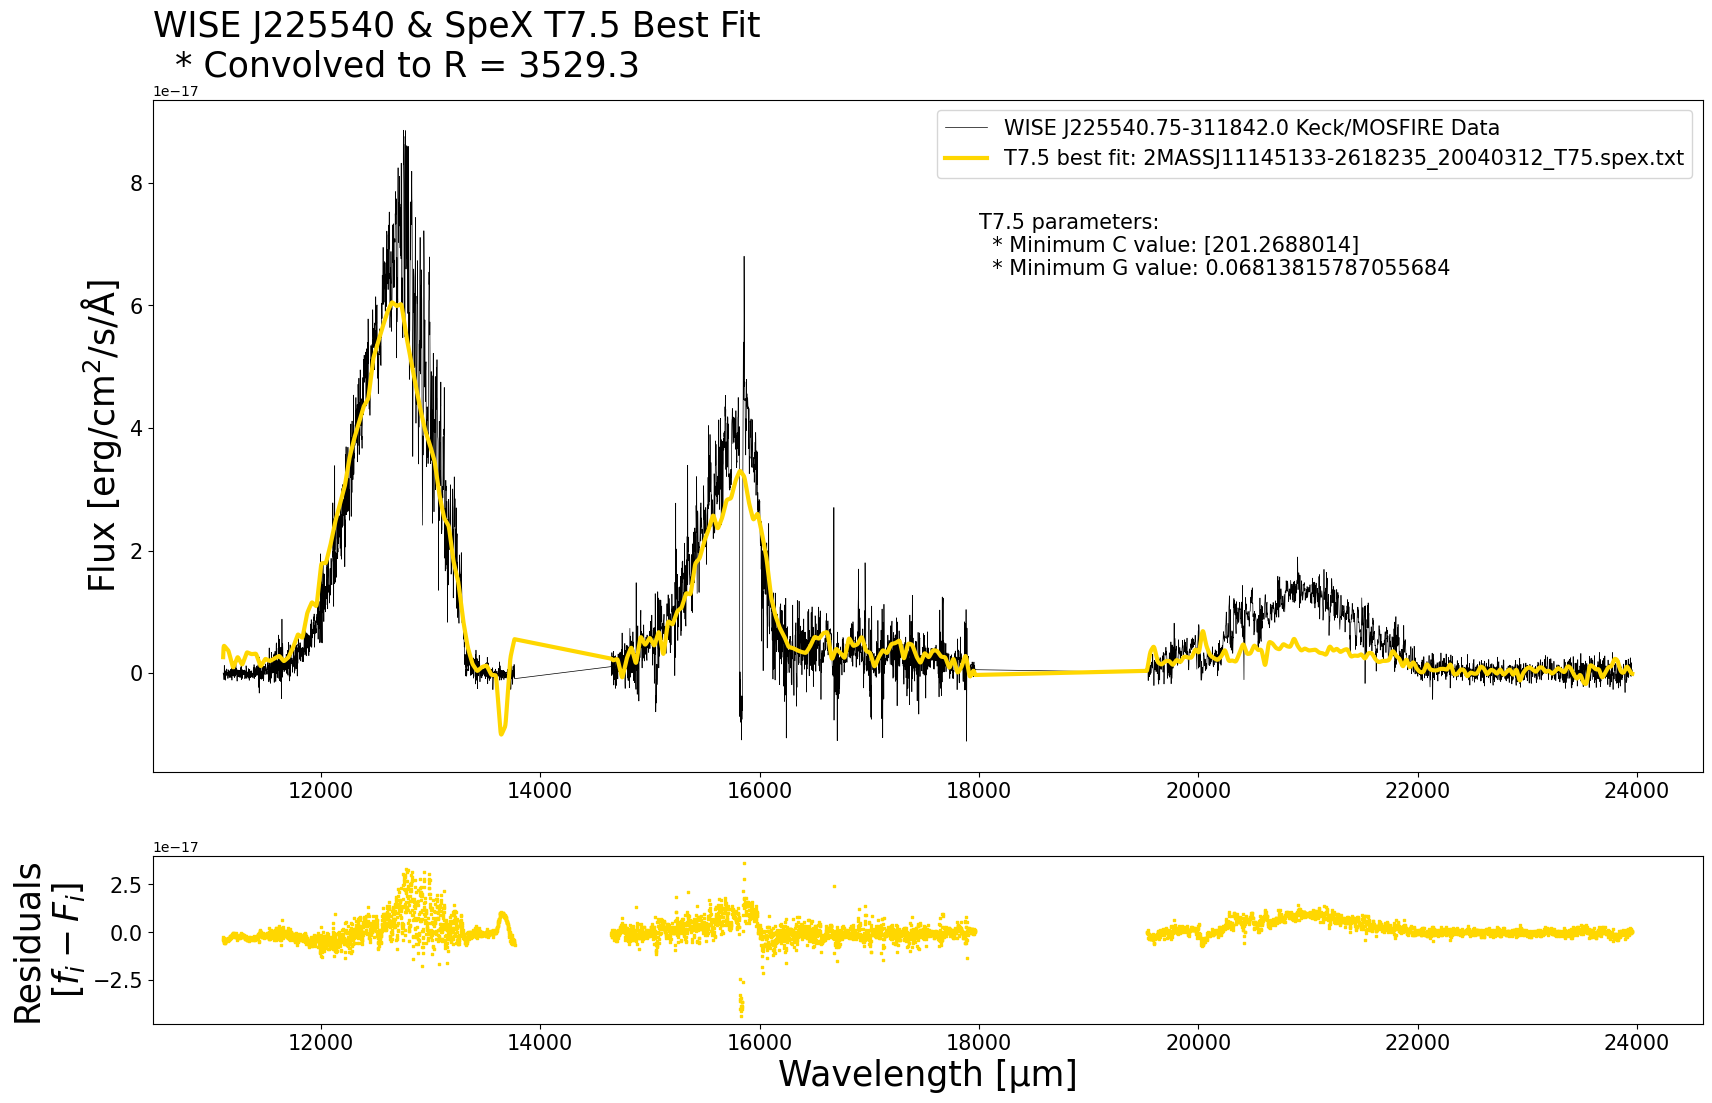

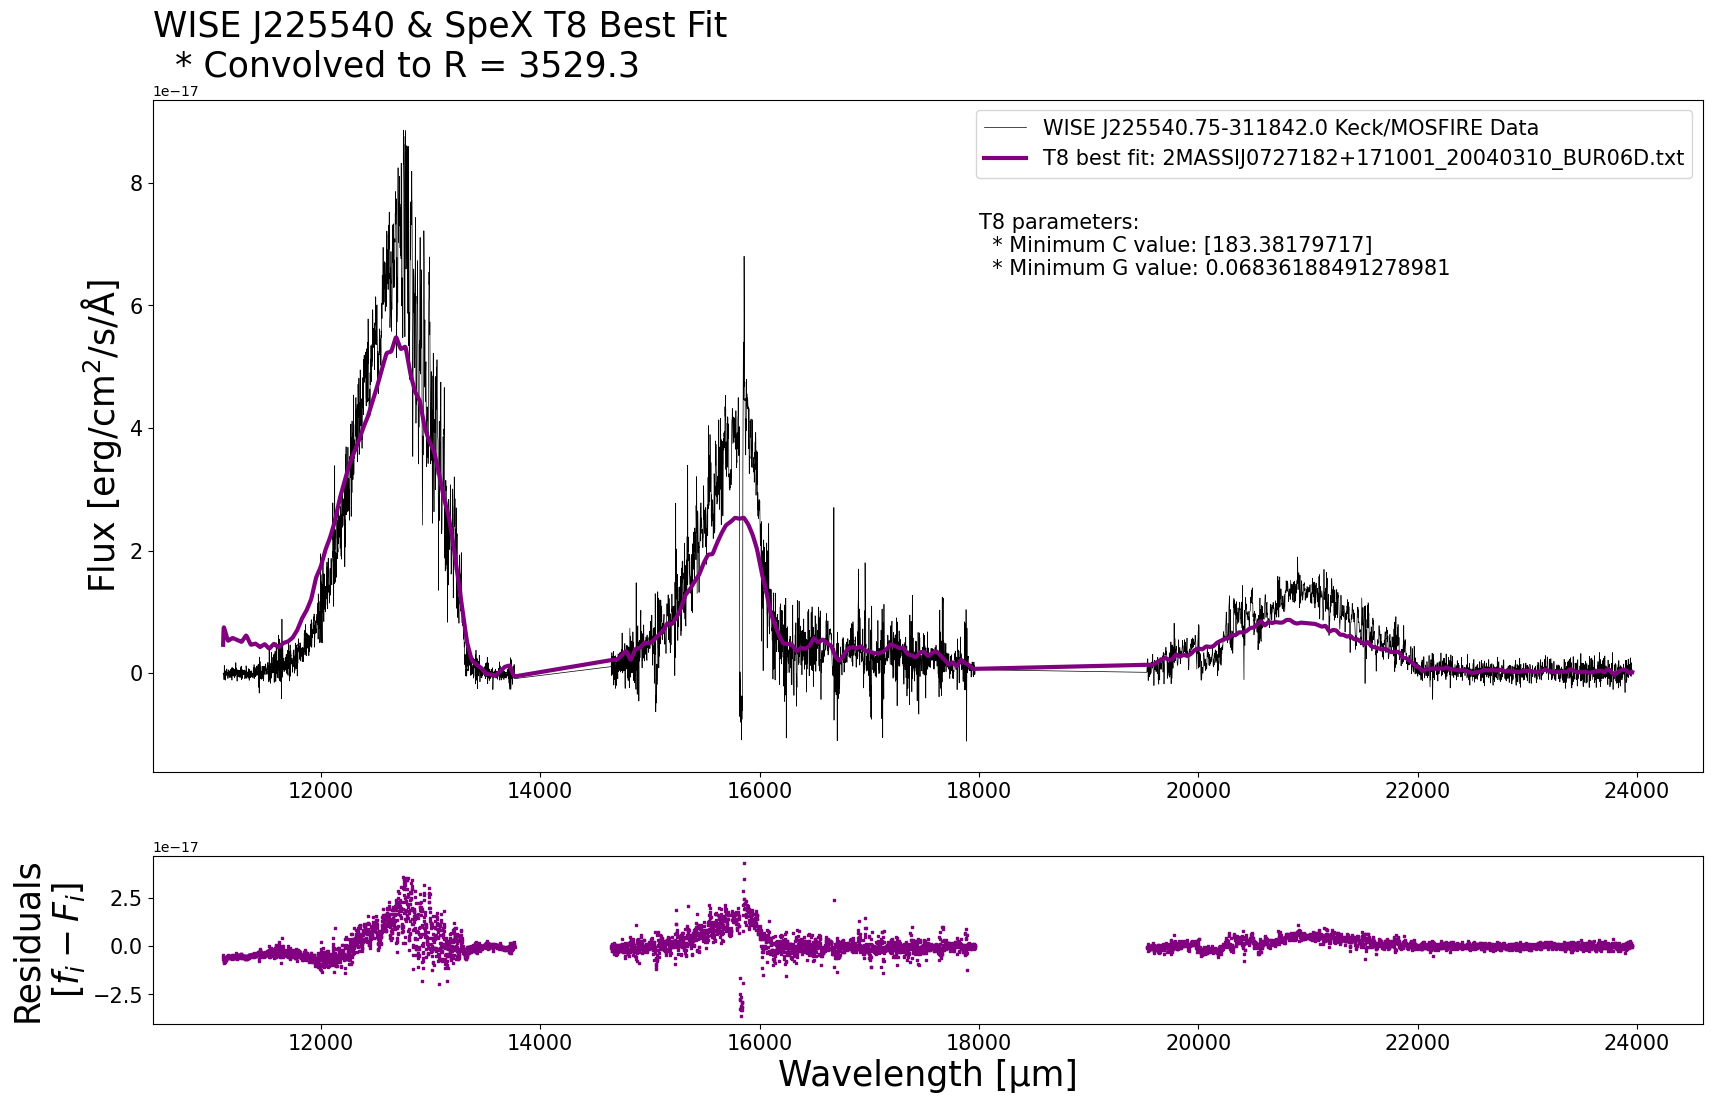

In [11]:
def bestfit_spextype(obs_path, mod_path1, mod_path2, mod_path3, mod_path4, mod_path5, t, res, modelname):
    '''
    This function takes the observation file path and the model file path, defines the observation wavelength grid,
    convolves the model wavelengths onto that grid, finds the best fit, and plots the observations and best fit together.
    I wish it was more generally parametized, but C'est la vie.
    * Parameters:
        * obs_path: str - the file path to the observed data (pre-defined)
        * mod_path: str - the file path to the model data (pre-defined)
        * t: str - the given name of the observed target (pre-defined)
        * res: int - the instrument resolution for the models to be convolved to (pre-defined)
        * modelname: int - the given name of the model in use (i.e., BT-Settl, ATMO, etc.)
    * Returns:
        * Cmin: arr - the minimum C value of the fit
        * Gmin: int - the minimum G value of the fit
        * bestmodel: str - the file path for the best fit model
        * plot: plot - observational data and the best fit model plotted together
    * Notes:
        * Built to work in tandem with convolve_v2()
        * Data files should be shaped as (wavelength, flux, uncertainty (optional))
        * bestfit_atmo is written to work with any models[i].dat file and will plot the best fit in green.
        * Needs numpy as np, matplotlib.pyplot as plt, and os, glob from glob
    '''
    ## Read in and sort the observational data, and define the resolution for convolve()
    obs = np.loadtxt(obs_path)
    wave_obs = obs[:, 0]
    flux_obs = obs[:, 1] * 1e-4
    unc_obs = obs[:, 2]

    ####################
    ## mod_path1 (T6) ##
    ####################
    models1 = glob(os.path.join(mod_path1, '*.txt'))
    C1 = np.zeros(len(models1))
    G1 = np.zeros(len(models1))
    low_mod1 = np.zeros((len(models1), 2, (len(wave_obs))))
    for i in range(len(models1)):
        data = np.loadtxt(models1[i])
        wl = data[:, 0] * 1e4
        flux = data[:, 1] * scale_A
        interp_flux = np.interp(wave_obs, wl, flux)
        range_data = np.vstack([wave_obs, interp_flux])
        low_mod1[i, :, :] = convolve_v2(range_data, R, 1)
        C1[i] = (np.nansum((low_mod1[i, 1, :] * flux_obs) / unc_obs ** 2)) / (np.nansum(low_mod1[i, 1, :] ** 2 / unc_obs ** 2))
        G1[i] = np.nansum(((flux_obs[i] - C1[i] * low_mod1[i, 1, :]) / unc_obs[i]) ** 2)
    G1min = np.min(G1)
    where_G1min = np.where(G1 == G1min)
    C1min = C1[where_G1min]
    modindex1 = int(where_G1min[0])
    bestfit1 = np.loadtxt(models1[modindex1])
    bestmodel1 = models1[modindex1]
    residuals1 = flux_obs - low_mod1[modindex1, 1, :] * C1min
    outfile1 = f'SpeX_T6_data[{modindex1}].txt'
    outfile2 = f'SpeX_T6_minCG[{modindex1}].txt'
    np.savetxt(outfile1, [low_mod1[modindex1, 0, :], low_mod1[modindex1, 1, :] * C1min, residuals1])
    np.savetxt(outfile2, [C1min[0], G1min])

    ######################
    ## mod_path2 (T6.5) ##
    ######################
    models2 = glob(os.path.join(mod_path2, '*.txt'))
    C2 = np.zeros(len(models2))
    G2 = np.zeros(len(models2))
    low_mod2 = np.zeros((len(models2), 2, (len(wave_obs))))
    for i in range(len(models2)):
        data = np.loadtxt(models2[i])
        wl = data[:, 0] * 1e4
        flux = data[:, 1] * scale_A
        interp_flux = np.interp(wave_obs, wl, flux)
        range_data = np.vstack([wave_obs, interp_flux])
        low_mod2[i, :, :] = convolve_v2(range_data, R, 1)
        C2[i] = (np.nansum((low_mod2[i, 1, :] * flux_obs) / unc_obs ** 2)) / (np.nansum(low_mod2[i, 1, :] ** 2 / unc_obs ** 2))
        G2[i] = np.nansum(((flux_obs[i] - C2[i] * low_mod2[i, 1, :]) / unc_obs[i]) ** 2)
    G2min = np.min(G2)
    where_G2min = np.where(G2 == G2min)
    C2min = C2[where_G2min]
    modindex2 = int(where_G2min[0])
    bestfit2 = np.loadtxt(models2[modindex2])
    bestmodel2 = models2[modindex2]
    residuals2 = flux_obs - low_mod2[modindex2, 1, :] * C2min
    outfile3 = f'SpeX_T65_data[{modindex2}].txt'
    outfile4 = f'SpeX_T65_minCG[{modindex2}].txt'
    np.savetxt(outfile3, [low_mod2[modindex2, 0, :], low_mod2[modindex2, 1, :] * C2min, residuals2])
    np.savetxt(outfile4, [C2min[0], G2min])

    ####################
    ## mod_path3 (T7) ##
    ####################
    models3 = glob(os.path.join(mod_path3, '*.txt'))
    C3 = np.zeros(len(models3))
    G3 = np.zeros(len(models3))
    low_mod3 = np.zeros((len(models3), 2, (len(wave_obs))))
    for i in range(len(models3)):
        data = np.loadtxt(models3[i])
        wl = data[:, 0] * 1e4
        flux = data[:, 1] * scale_A
        interp_flux = np.interp(wave_obs, wl, flux)
        range_data = np.vstack([wave_obs, interp_flux])
        low_mod3[i, :, :] = convolve_v2(range_data, R, 1)
        C3[i] = (np.nansum((low_mod3[i, 1, :] * flux_obs) / unc_obs ** 2)) / (np.nansum(low_mod3[i, 1, :] ** 2 / unc_obs ** 2))
        G3[i] = np.nansum(((flux_obs[i] - C3[i] * low_mod3[i, 1, :]) / unc_obs[i]) ** 2)
    G3min = np.min(G3)
    where_G3min = np.where(G3 == G3min)
    C3min = C3[where_G3min]
    modindex3 = int(where_G3min[0])
    bestfit3 = np.loadtxt(models3[modindex3])
    bestmodel3 = models3[modindex3]
    residuals3 = flux_obs - low_mod3[modindex3, 1, :] * C3min
    outfile5 = f'SpeX_T7_data[{modindex3}].txt'
    outfile6 = f'SpeX_T7_minCG[{modindex3}].txt'
    np.savetxt(outfile5, [low_mod3[modindex3, 0, :], low_mod3[modindex3, 1, :] * C3min, residuals3])
    np.savetxt(outfile6, [C3min[0], G3min])

    ######################
    ## mod_path4 (T7.5) ##
    ######################
    models4 = glob(os.path.join(mod_path4, '*.txt'))
    C4 = np.zeros(len(models4))
    G4 = np.zeros(len(models4))
    low_mod4 = np.zeros((len(models4), 2, (len(wave_obs))))
    for i in range(len(models4)):
        data = np.loadtxt(models4[i])
        wl = data[:, 0] * 1e4
        flux = data[:, 1] * scale_A
        interp_flux = np.interp(wave_obs, wl, flux)
        range_data = np.vstack([wave_obs, interp_flux])
        low_mod4[i, :, :] = convolve_v2(range_data, R, 1)
        C4[i] = (np.nansum((low_mod4[i, 1, :] * flux_obs) / unc_obs ** 2)) / (np.nansum(low_mod4[i, 1, :] ** 2 / unc_obs ** 2))
        G4[i] = np.nansum(((flux_obs[i] - C4[i] * low_mod4[i, 1, :]) / unc_obs[i]) ** 2)
    G4min = np.min(G4)
    where_G4min = np.where(G4 == G4min)
    C4min = C4[where_G4min]
    modindex4 = int(where_G4min[0])
    bestfit4 = np.loadtxt(models4[modindex4])
    bestmodel4 = models4[modindex4]
    residuals4 = flux_obs - low_mod4[modindex4, 1, :] * C4min
    outfile7 = f'SpeX_T75_data[{modindex4}].txt'
    outfile8 = f'SpeX_T75_minCG[{modindex4}].txt'
    np.savetxt(outfile7, [low_mod4[modindex4, 0, :], low_mod4[modindex4, 1, :] * C4min, residuals4])
    np.savetxt(outfile8, [C4min[0], G4min])

    ####################
    ## mod_path5 (T8) ##
    ####################
    models5 = glob(os.path.join(mod_path5, '*.txt'))
    C5 = np.zeros(len(models5))
    G5 = np.zeros(len(models5))
    low_mod5 = np.zeros((len(models5), 2, (len(wave_obs))))
    for i in range(len(models5)):
        data = np.loadtxt(models5[i])
        wl = data[:, 0] * 1e4
        flux = data[:, 1] * scale_A
        interp_flux = np.interp(wave_obs, wl, flux)
        range_data = np.vstack([wave_obs, interp_flux])
        low_mod5[i, :, :] = convolve_v2(range_data, R, 1)
        C5[i] = (np.nansum((low_mod5[i, 1, :] * flux_obs) / unc_obs ** 2)) / (np.nansum(low_mod5[i, 1, :] ** 2 / unc_obs ** 2))
        G5[i] = np.nansum(((flux_obs[i] - C5[i] * low_mod5[i, 1, :]) / unc_obs[i]) ** 2)
    G5min = np.min(G5)
    where_G5min = np.where(G5 == G5min)
    C5min = C5[where_G5min]
    modindex5 = int(where_G5min[0])
    bestfit5 = np.loadtxt(models5[modindex5])
    bestmodel5 = models5[modindex5]
    residuals5 = flux_obs - low_mod5[modindex5, 1, :] * C5min
    outfile9 = f'SpeX_T8_data[{modindex5}].txt'
    outfile10 = f'SpeX_T8_minCG[{modindex5}].txt'
    np.savetxt(outfile9, [low_mod5[modindex5, 0, :], low_mod5[modindex5, 1, :] * C5min, residuals5])
    np.savetxt(outfile10, [C5min[0], G5min])

    ## Plot the best fit model with the observational data
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (20, 12), gridspec_kw = {'height_ratios': [4, 1]})
    ax1.plot(wave_obs, flux_obs, color = 'black', linewidth = 0.5, label = f'{target} Keck/MOSFIRE Data')
    ax1.plot(low_mod1[modindex1, 0, :], low_mod1[modindex1, 1, :] * C1min, color = 'blue', linewidth = 3, label = f'T6 best fit:    {bestmodel1[79:]}')
    ax1.plot(low_mod2[modindex2, 0, :], low_mod2[modindex2, 1, :] * C2min, color = 'red', linewidth = 3, label = f'T6.5 best fit: {bestmodel2[81:]}')
    ax1.plot(low_mod3[modindex3, 0, :], low_mod3[modindex3, 1, :] * C3min, color = 'green', linewidth = 3, label = f'T7 best fit:    {bestmodel3[79:]}')
    ax1.plot(low_mod4[modindex4, 0, :], low_mod4[modindex4, 1, :] * C4min, color = 'gold', linewidth = 3, label = f'T7.5 best fit: {bestmodel4[81:]}')
    ax1.plot(low_mod5[modindex5, 0, :], low_mod5[modindex5, 1, :] * C5min, color = 'purple', linewidth = 3, label = f'T8 best fit:    {bestmodel5[68:]}')      
    ax1.set_title(t + f' & {modelname} Best Fits\n  * Convolved to R = {np.round(R, 1)}', loc = 'left', fontsize = 25)
    ax1.set_ylabel('Flux [erg/cm$^2$/s/Å]', fontsize = 25)
    ax1.tick_params(axis = 'both', which = 'major', labelsize = 15)
    ax1.legend(loc = 'upper right', fontsize = 15, fancybox = True)    
    ax1.set_title(t + f' & {modelname} T6 Best Fits\n  * Convolved to R = {np.round(R, 1)}', loc = 'left', fontsize = 25)
    ax1.set_ylabel('Flux [erg/cm$^2$/s/Å]', fontsize = 25)
    ax1.tick_params(axis = 'both', which = 'major', labelsize = 15)
    ax1.legend(loc = 'upper right', fontsize = 15, fancybox = True)
    ax1.annotate(f'T6 parameters:\n  * Minimum C value: {C1min}\n  * Minimum G value: {G1min}\n\nT6.5 parameters:\n  * Minimum C value: {C2min}\n  * Minimum G value: {G2min}\n\nT7 parameters:\n  * Minimum C value: {C3min}\n  * Minimum G value: {G3min}\n\nT7.5 parameters:\n  * Minimum C value: {C4min}\n  * Minimum G value: {G4min}\n\nT8 parameters:\n  * Minimum C value: {C5min}\n  * Minimum G value: {G5min}', (18000, 0.2e-16), fontsize = 8)
    ax2.scatter(wave_obs, residuals1, color = 'blue', marker = ',', s = 1)
    ax2.scatter(wave_obs, residuals2, color = 'red', marker = ',', s = 1)
    ax2.scatter(wave_obs, residuals3, color = 'green', marker = ',', s = 1)
    ax2.scatter(wave_obs, residuals4, color = 'gold', marker = ',', s = 1)
    ax2.scatter(wave_obs, residuals5, color = 'purple', marker = ',', s = 1)
    ax2.set_xlabel('Wavelength [µm]', fontsize = 25)
    ax2.set_ylabel(f'Residuals\n'r'$[f_i - F_i]$', fontsize=25)
    ax2.tick_params(axis = 'both', which = 'major', labelsize = 15)
    plt.savefig('aWISE + SpeX (type) Best Fits')

    fig, (ax3, ax4) = plt.subplots(2, 1, figsize = (20, 12), gridspec_kw = {'height_ratios': [4, 1]})
    ax3.plot(wave_obs, flux_obs, color = 'black', linewidth = 0.5, label = f'{target} Keck/MOSFIRE Data')
    ax3.plot(low_mod1[modindex1, 0, :], low_mod1[modindex1, 1, :] * C1min, color = 'blue', linewidth = 3, label = f'T6 best fit: {bestmodel1[79:]}')
    ax3.set_title(t + f' & {modelname} T6 Best Fit\n  * Convolved to R = {np.round(R, 1)}', loc = 'left', fontsize = 25)
    ax3.set_ylabel('Flux [erg/cm$^2$/s/Å]', fontsize = 25)
    ax3.tick_params(axis = 'both', which = 'major', labelsize = 15)
    ax3.legend(loc = 'upper right', fontsize = 15, fancybox = True)
    ax3.annotate(f'T6 parameters:\n  * Minimum C value: {C1min}\n  * Minimum G value: {G1min}', (18000, 6.5e-17), fontsize = 15)
    ax4.scatter(wave_obs, residuals1, color = 'blue', marker = ',', s = 1, label = 'Residuals')
    ax4.set_xlabel('Wavelength [µm]', fontsize = 25)
    ax4.set_ylabel(f'Residuals\n'r'$[f_i - F_i]$', fontsize=25)
    ax4.tick_params(axis = 'both', which = 'major', labelsize = 15)
    plt.savefig('aWISE + SpeX T6 Best Fits')

    fig, (ax5, ax6) = plt.subplots(2, 1, figsize = (20, 12), gridspec_kw = {'height_ratios': [4, 1]})
    ax5.plot(wave_obs, flux_obs, color = 'black', linewidth = 0.5, label = f'{target} Keck/MOSFIRE Data')
    ax5.plot(low_mod2[modindex2, 0, :], low_mod2[modindex2, 1, :] * C2min, color = 'red', linewidth = 3, label = f'T6.5 best fit: {bestmodel2[81:]}')
    ax5.set_title(t + f' & {modelname} T6.5 Best Fit\n  * Convolved to R = {np.round(R, 1)}', loc = 'left', fontsize = 25)
    ax5.set_ylabel('Flux [erg/cm$^2$/s/Å]', fontsize = 25)
    ax5.tick_params(axis = 'both', which = 'major', labelsize = 15)
    ax5.legend(loc = 'upper right', fontsize = 15, fancybox = True)
    ax5.annotate(f'T6.5 parameters:\n  * Minimum C value: {C2min}\n  * Minimum G value: {G2min}', (18000, 6.5e-17), fontsize = 15)
    ax6.scatter(wave_obs, residuals2, color = 'red', marker = ',', s = 1, label = 'Residuals')
    ax6.set_xlabel('Wavelength [µm]', fontsize = 25)
    ax6.set_ylabel(f'Residuals\n'r'$[f_i - F_i]$', fontsize=25)
    ax6.tick_params(axis = 'both', which = 'major', labelsize = 15)
    plt.savefig('aWISE + SpeX T65 Best Fits')

    fig, (ax7, ax8) = plt.subplots(2, 1, figsize = (20, 12), gridspec_kw = {'height_ratios': [4, 1]})
    ax7.plot(wave_obs, flux_obs, color = 'black', linewidth = 0.5, label = f'{target} Keck/MOSFIRE Data')
    ax7.plot(low_mod3[modindex3, 0, :], low_mod3[modindex3, 1, :] * C3min, color = 'green', linewidth = 3, label = f'T7 best fit: {bestmodel3[79:]}')
    ax7.set_title(t + f' & {modelname} T7 Best Fit\n  * Convolved to R = {np.round(R, 1)}', loc = 'left', fontsize = 25)
    ax7.set_ylabel('Flux [erg/cm$^2$/s/Å]', fontsize = 25)
    ax7.tick_params(axis = 'both', which = 'major', labelsize = 15)
    ax7.legend(loc = 'upper right', fontsize = 15, fancybox = True)
    ax7.annotate(f'T7 parameters:\n  * Minimum C value: {C3min}\n  * Minimum G value: {G3min}', (18000, 6.5e-17), fontsize = 15)
    ax8.scatter(wave_obs, residuals3, color = 'green', marker = ',', s = 1, label = 'Residuals')
    ax8.set_xlabel('Wavelength [µm]', fontsize = 25)
    ax8.set_ylabel(f'Residuals\n'r'$[f_i - F_i]$', fontsize=25)
    ax8.tick_params(axis = 'both', which = 'major', labelsize = 15)
    plt.savefig('aWISE + SpeX T7 Best Fits')

    fig, (ax9, ax10) = plt.subplots(2, 1, figsize = (20, 12), gridspec_kw = {'height_ratios': [4, 1]})
    ax9.plot(wave_obs, flux_obs, color = 'black', linewidth = 0.5, label = f'{target} Keck/MOSFIRE Data')
    ax9.plot(low_mod4[modindex4, 0, :], low_mod4[modindex4, 1, :] * C4min, color = 'gold', linewidth = 3, label = f'T7.5 best fit: {bestmodel4[81:]}')
    ax9.set_title(t + f' & {modelname} T7.5 Best Fit\n  * Convolved to R = {np.round(R, 1)}', loc = 'left', fontsize = 25)
    ax9.set_ylabel('Flux [erg/cm$^2$/s/Å]', fontsize = 25)
    ax9.tick_params(axis = 'both', which = 'major', labelsize = 15)
    ax9.legend(loc = 'upper right', fontsize = 15, fancybox = True)
    ax9.annotate(f'T7.5 parameters:\n  * Minimum C value: {C4min}\n  * Minimum G value: {G4min}', (18000, 6.5e-17), fontsize = 15)
    ax10.scatter(wave_obs, residuals4, color = 'gold', marker = ',', s = 1, label = 'Residuals')
    ax10.set_xlabel('Wavelength [µm]', fontsize = 25)
    ax10.set_ylabel(f'Residuals\n'r'$[f_i - F_i]$', fontsize=25)
    ax10.tick_params(axis = 'both', which = 'major', labelsize = 15)
    plt.savefig('aWISE + SpeX T75 Best Fits')

    fig, (ax11, ax12) = plt.subplots(2, 1, figsize = (20, 12), gridspec_kw = {'height_ratios': [4, 1]})
    ax11.plot(wave_obs, flux_obs, color = 'black', linewidth = 0.5, label = f'{target} Keck/MOSFIRE Data')
    ax11.plot(low_mod5[modindex5, 0, :], low_mod5[modindex5, 1, :] * C5min, color = 'purple', linewidth = 3, label = f'T8 best fit: {bestmodel5[68:]}')
    ax11.set_title(t + f' & {modelname} T8 Best Fit\n  * Convolved to R = {np.round(R, 1)}', loc = 'left', fontsize = 25)
    ax11.set_ylabel('Flux [erg/cm$^2$/s/Å]', fontsize = 25)
    ax11.tick_params(axis = 'both', which = 'major', labelsize = 15)
    ax11.legend(loc = 'upper right', fontsize = 15, fancybox = True)
    ax11.annotate(f'T8 parameters:\n  * Minimum C value: {C5min}\n  * Minimum G value: {G5min}', (18000, 6.5e-17), fontsize = 15)
    ax12.scatter(wave_obs, residuals5, color = 'purple', marker = ',', s = 1, label = 'Residuals')
    ax12.set_xlabel('Wavelength [µm]', fontsize = 25)
    ax12.set_ylabel(f'Residuals\n'r'$[f_i - F_i]$', fontsize=25)
    ax12.tick_params(axis = 'both', which = 'major', labelsize = 15)
    plt.savefig('aWISE + SpeX T8 Best Fits')
    
    return

bestfit_spextype(file_name, spex_T6_path, spex_T65_path, spex_T7_path, spex_T75_path, spex_T8_path, target_short, R, 'SpeX')

/var/folders/36/1_bs4p6d4t73n8bdrm6msfsr0005tr/T/ipykernel_84913/671237992.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  modindex = int(where_Gmin[0])


Minimum C value:     [4.67087164e+18]
Minimum G value:     0.07001984344658284
Best fit All ATMO model: /Users/bseamons/Documents/Research/atmo_models/spec_jwst_t500_g5.5_p0_kg_g1.25.dat


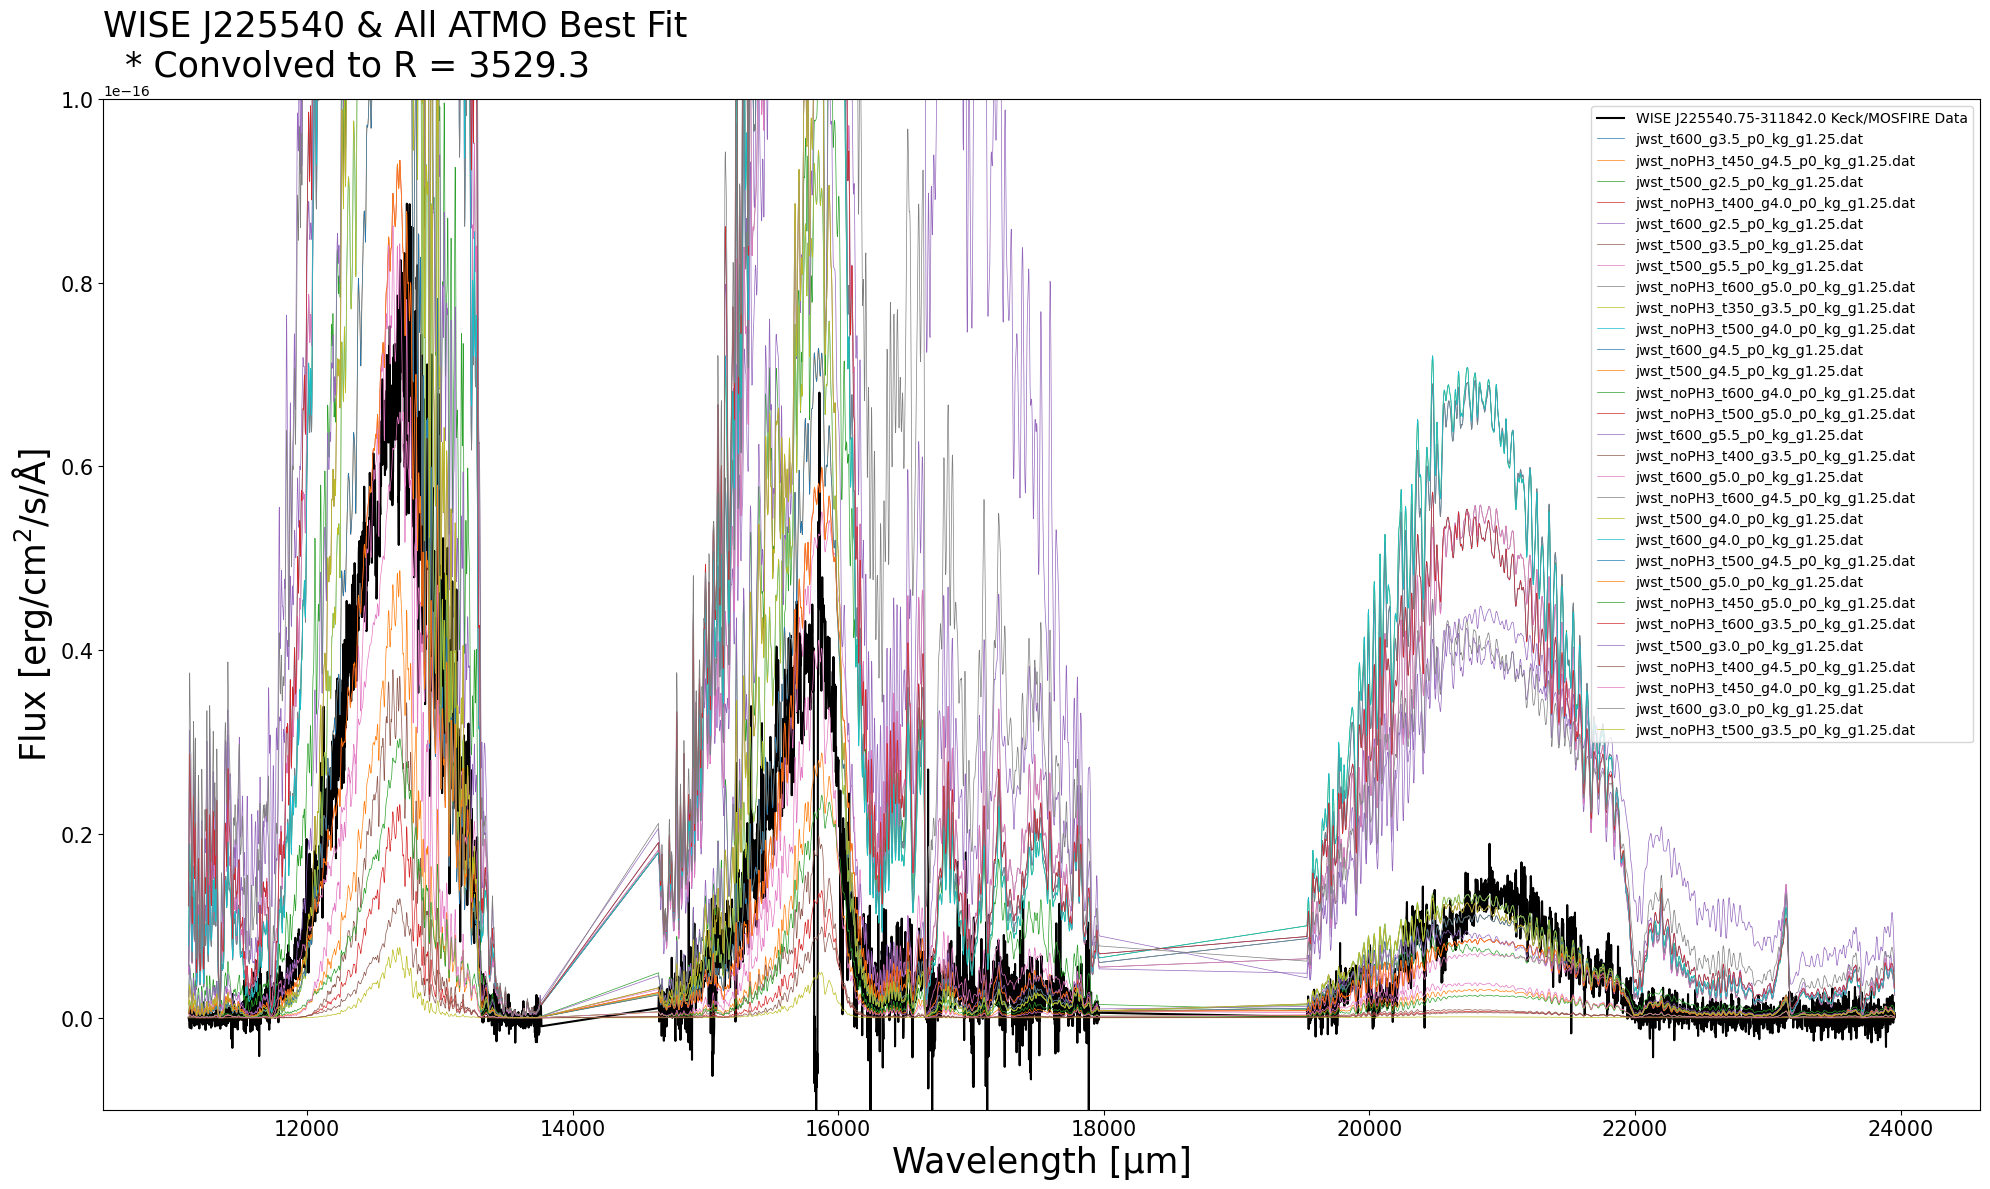

In [12]:
def bestfit_atmoall(obs_path, mod_path, t, res, modelname):
    '''
    This function takes the observation file path and the model file path, defines the observation wavelength grid,
    convolves the model wavelengths onto that grid, finds the best fit, and plots the observations and best fit together.
    I wish it was more generally parametized, but C'est la vie.
    * Parameters:
        * obs_path: str - the file path to the observed data (pre-defined)
        * mod_path: str - the file path to the model data (pre-defined)
        * t: str - the given name of the observed target (pre-defined)
        * res: int - the instrument resolution for the models to be convolved to (pre-defined)
        * modelname: int - the given name of the model in use (i.e., BT-Settl, ATMO, etc.)
    * Returns:
        * Cmin: arr - the minimum C value of the fit
        * Gmin: int - the minimum G value of the fit
        * bestmodel: str - the file path for the best fit model
        * plot: plot - observational data and the best fit model plotted together
    * Notes:
        * Built to work in tandem with convolve_v2()
        * Data files should be shaped as (wavelength, flux, uncertainty (optional))
        * bestfit_atmo is written to work with any models[i].dat file and will plot the best fit in green.
        * Needs numpy as np, matplotlib.pyplot as plt, and os, glob from glob
    '''
    ## Read in and sort the observational data, and define the resolution for convolve()
    obs = np.loadtxt(obs_path)
    wave_obs = obs[:, 0]
    flux_obs = obs[:, 1] * 1e-4
    unc_obs = obs[:, 2]

    ## Define the full file path to the models
    models = glob(os.path.join(mod_path, '*.dat'))
    spec = models

    ## Define the C and G grids and loop through the models to interpolate and convolve them
    C = np.zeros(len(models))
    G = np.zeros(len(models))
    low_mod = np.zeros((len(models), 2, (len(wave_obs))))
    
    output_files = []
    for i in range(len(models)):
        data = np.loadtxt(models[i])

        wl = data[:, 0] * 1e4
        #flux = data[:,1] * 1e4
        flux = data[:, 1] * scale_A

        interp_flux = np.interp(wave_obs, wl, flux)
        range_data = np.vstack([wave_obs, interp_flux])
        low_mod[i, :, :] = convolve_v2(range_data, R, 1)

        C[i] = (np.nansum((low_mod[i, 1, :] * flux_obs) / unc_obs ** 2)) / (np.nansum(low_mod[i, 1, :] ** 2 / unc_obs ** 2))
        G[i] = np.nansum(((flux_obs[i] - C[i] * low_mod[i, 1, :]) / unc_obs[i]) ** 2)

    ## Calculate the minima in C and G
    Gmin = np.min(G)
    where_Gmin = np.where(G == Gmin)
    Cmin = C[where_Gmin]

    ## Index minG to the correct model
    modindex = int(where_Gmin[0])
    bestfit = np.loadtxt(models[modindex])
    bestmodel = models[modindex]

    ## Print the minimum C and G values and the best fit model
    print(f'Minimum C value:     {Cmin}')
    print(f'Minimum G value:     {Gmin}')
    print(f'Best fit {modelname} model: {bestmodel}')

    ## Write the best-fit data to a .txt file
    outfile1 = f'{modelname}_data{[modindex]}.txt'
    outfile2 = f'{modelname}_minC&G{[modindex]}.txt'
    np.savetxt(outfile1, [low_mod[modindex, 0, :], low_mod[modindex, 1, :] * Cmin])
    np.savetxt(outfile2, [Cmin[0], Gmin])

    ## Plot the best fit model with the observational data
    plt.figure(figsize = (20, 12))
    
    plt.plot(wave_obs, flux_obs, color = 'black', label = f'{target} Keck/MOSFIRE Data')
    for i in range(len(models)):
        plt.plot(low_mod[i, 0, :], low_mod[i, 1, :] * Cmin, linewidth = 0.5, label = f'{atmo_models[i][52:]}')

    plt.title(t + f' & {modelname} Best Fit\n  * Convolved to R = {np.round(R, 1)}', loc = 'left', fontsize = 25)
    plt.xlabel('Wavelength [µm]', fontsize = 25)
    plt.ylabel('Flux [erg/cm$^2$/s/Å]', fontsize = 25)
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)
    plt.legend(loc = 'upper right', fontsize = 10, fancybox = True)
    plt.ylim(-1e-17, 1e-16)
    #plt.annotate(f'{bestmodel[52:]}:\n  * t$_e$$_f$$_f$ = 400 K\n  * logg = 4.5\n\n  * Minimum C value: {Cmin}\n  * Minimum G value: {Gmin}', (18000, 2.5e-17), fontsize = 25)
    plt.tight_layout()
    #plt.savefig('WISE + ATMO Best Fit')

    return

atmopath = '/Users/bseamons/Documents/Research/atmo_models/'
atmomodels = glob(os.path.join(atmopath, '*.dat'))

bestfit_atmoall(file_name, atmopath, target_short, R, 'All ATMO')

In [13]:
def convolve_v3(spec, R, sample):
    '''
    This will convolve a model spectrum with a gaussian kernel to the given resolution of the observations [R].
    * Parameters:
        * spec: source spectrum (the object that will be convolved)
        * R: int (the resolution (dL/L) to convolve to)
        * sample: int (oversampling factor for smoothing)
    * Returns:
        * smooth_spec: the convolved spectrum (and possibly the original grid)
    * Notes:
        * Built to work in tandem with bestfit_[model]()
        * Needs numpy as np and convolve_fft, Gaussian1DKernel from astropy.convolution
    '''
    ## Define the model wavelength and flux grids
    obs = np.loadtxt(spec)
    w_grid = obs[0, :]
    f_grid = obs[1, :]

    ## Define a logarithmic wavelength grid
    w_logmin = np.log10(np.nanmin(w_grid))
    w_logmax = np.log10(np.nanmax(w_grid))
    N = np.size(w_grid) * sample
    w_loggrid = np.logspace(w_logmin, w_logmax, num = N)

    ## Calculate the standard deviation of the Gaussian kernel
    R_grid = (w_loggrid[1:-1] + w_loggrid[0:-2]) / (w_loggrid[1:-1] - w_loggrid[0:-2]) / 2
    sigma = np.median(R_grid) / R
    if sigma < 1:
        sigma = 1

    ## Interpolate the models onto the log grid, convolve them, and interpolate the results onto the original grid
    f_log = np.interp(w_loggrid, w_grid, f_grid)
    gauss = Gaussian1DKernel(stddev = sigma)
    f_conv = convolve_fft(f_log, gauss)
    f_smooth = np.interp(w_grid, w_loggrid, f_conv)
    smooth_spec = np.vstack([w_grid, f_smooth])
    print(np.shape(w_grid), np.shape(f_smooth))
    print(np.shape(smooth_spec))

    return smooth_spec

convolve_v3(file_name, 120, 1)

(3,) (3,)
(2, 3)


array([[1.11100000e+04, 6.93496000e-17, 5.49197000e-15],
       [5.99911614e+02, 4.43278057e+03, 4.43278056e+03]])

In [14]:
obs = np.loadtxt(file_name)
w = obs[:, 0]
f = obs[:, 1]
u = obs[:, 2]

w_min = np.log10(np.nanmin(w))
w_max = np.log10(np.nanmax(w))
N = np.size(w)
w_grid = np.logspace(w_min, w_max, num = N)

R_grid = (w_grid[1:-1] + w_grid[0:-2]) / (w_grid[1:-1] - w_grid[0:-2]) / 2
sigma = np.median(R_grid) / 120
if sigma < 1:
    sigma = 1

f_log = np.interp(w_grid, w, f)
g = Gaussian1DKernel(stddev = sigma)
fcon = convolve_fft(f_log, g)
fsmooth = np.interp(w, w_grid, fcon)
smooth_spec = np.vstack([w, fsmooth]).T

w_smooth = smooth_spec[:, 0]
f_smooth = smooth_spec[:, 1]

/var/folders/36/1_bs4p6d4t73n8bdrm6msfsr0005tr/T/ipykernel_84913/3656697688.py:53: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  modindex1 = int(where_G1min[0])
/var/folders/36/1_bs4p6d4t73n8bdrm6msfsr0005tr/T/ipykernel_84913/3656697688.py:78: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  modindex2 = int(where_G2min[0])
/var/folders/36/1_bs4p6d4t73n8bdrm6msfsr0005tr/T/ipykernel_84913/3656697688.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  modindex3 = int(w

2.4950496161028847e-18
1.832936783726733e-18
1.6428966892264484e-18
1.2386787505517415e-18
1.119795258237855e-18


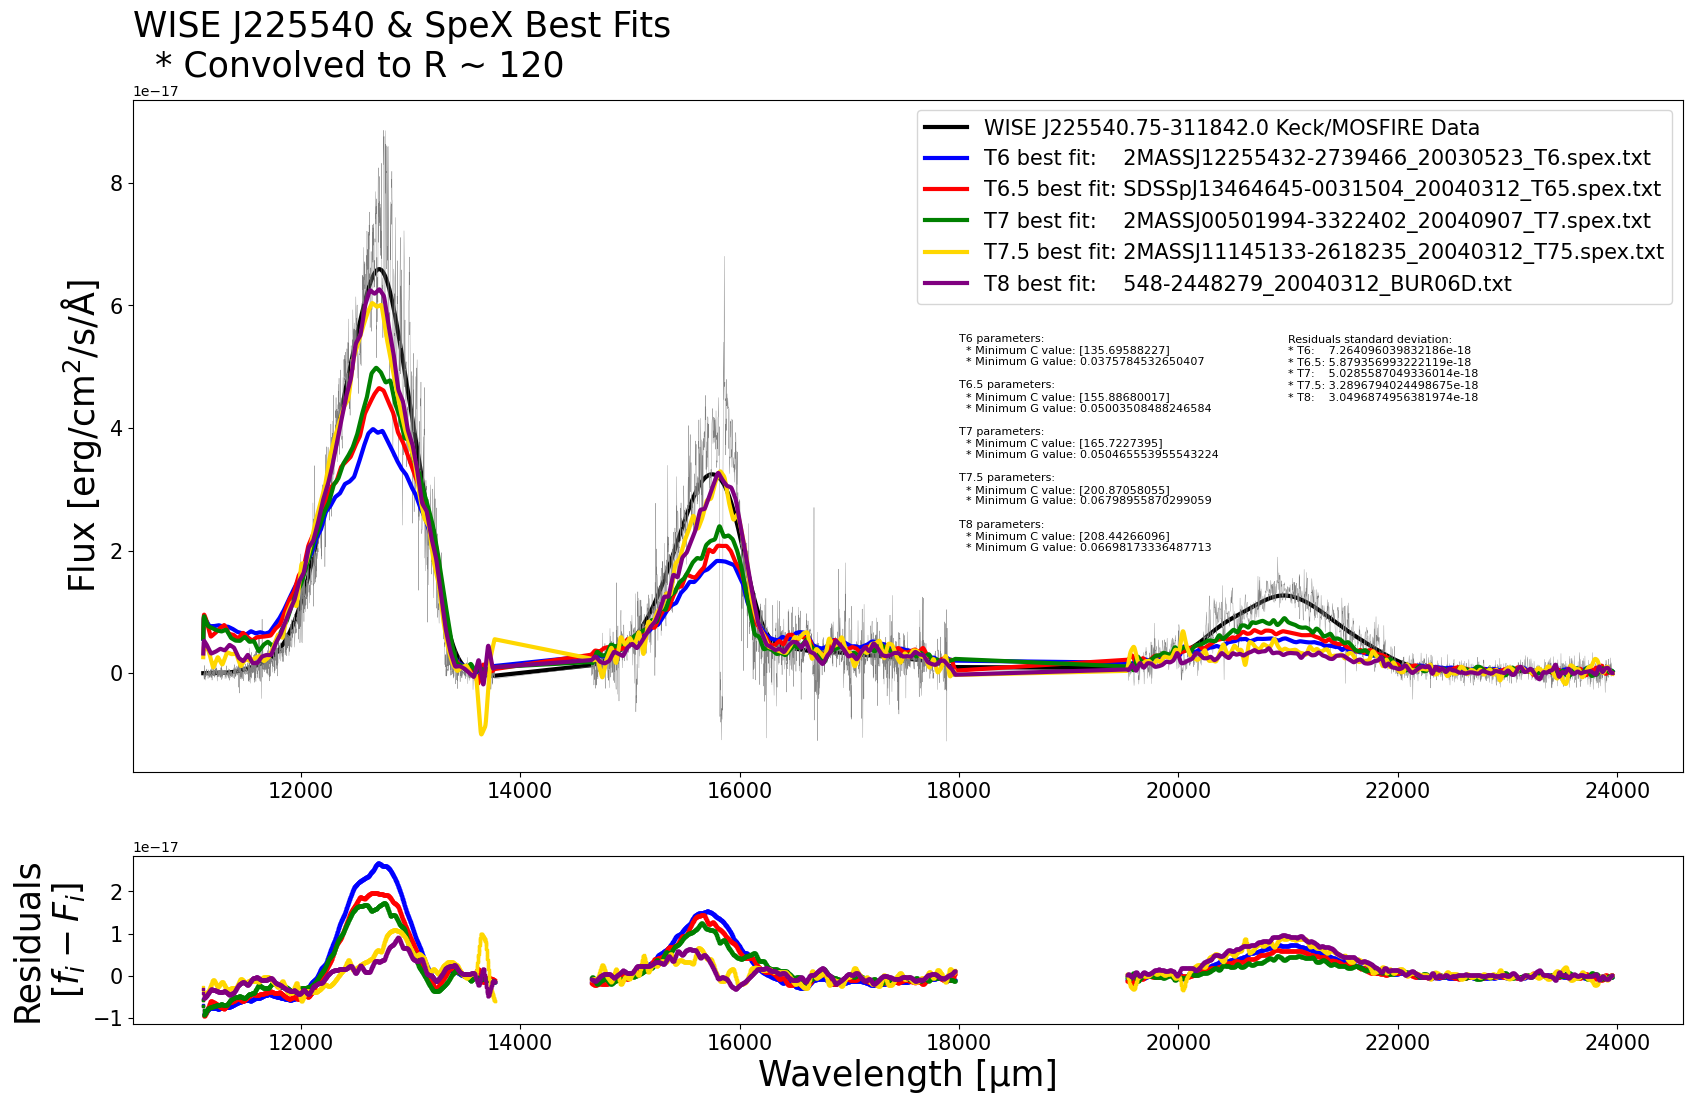

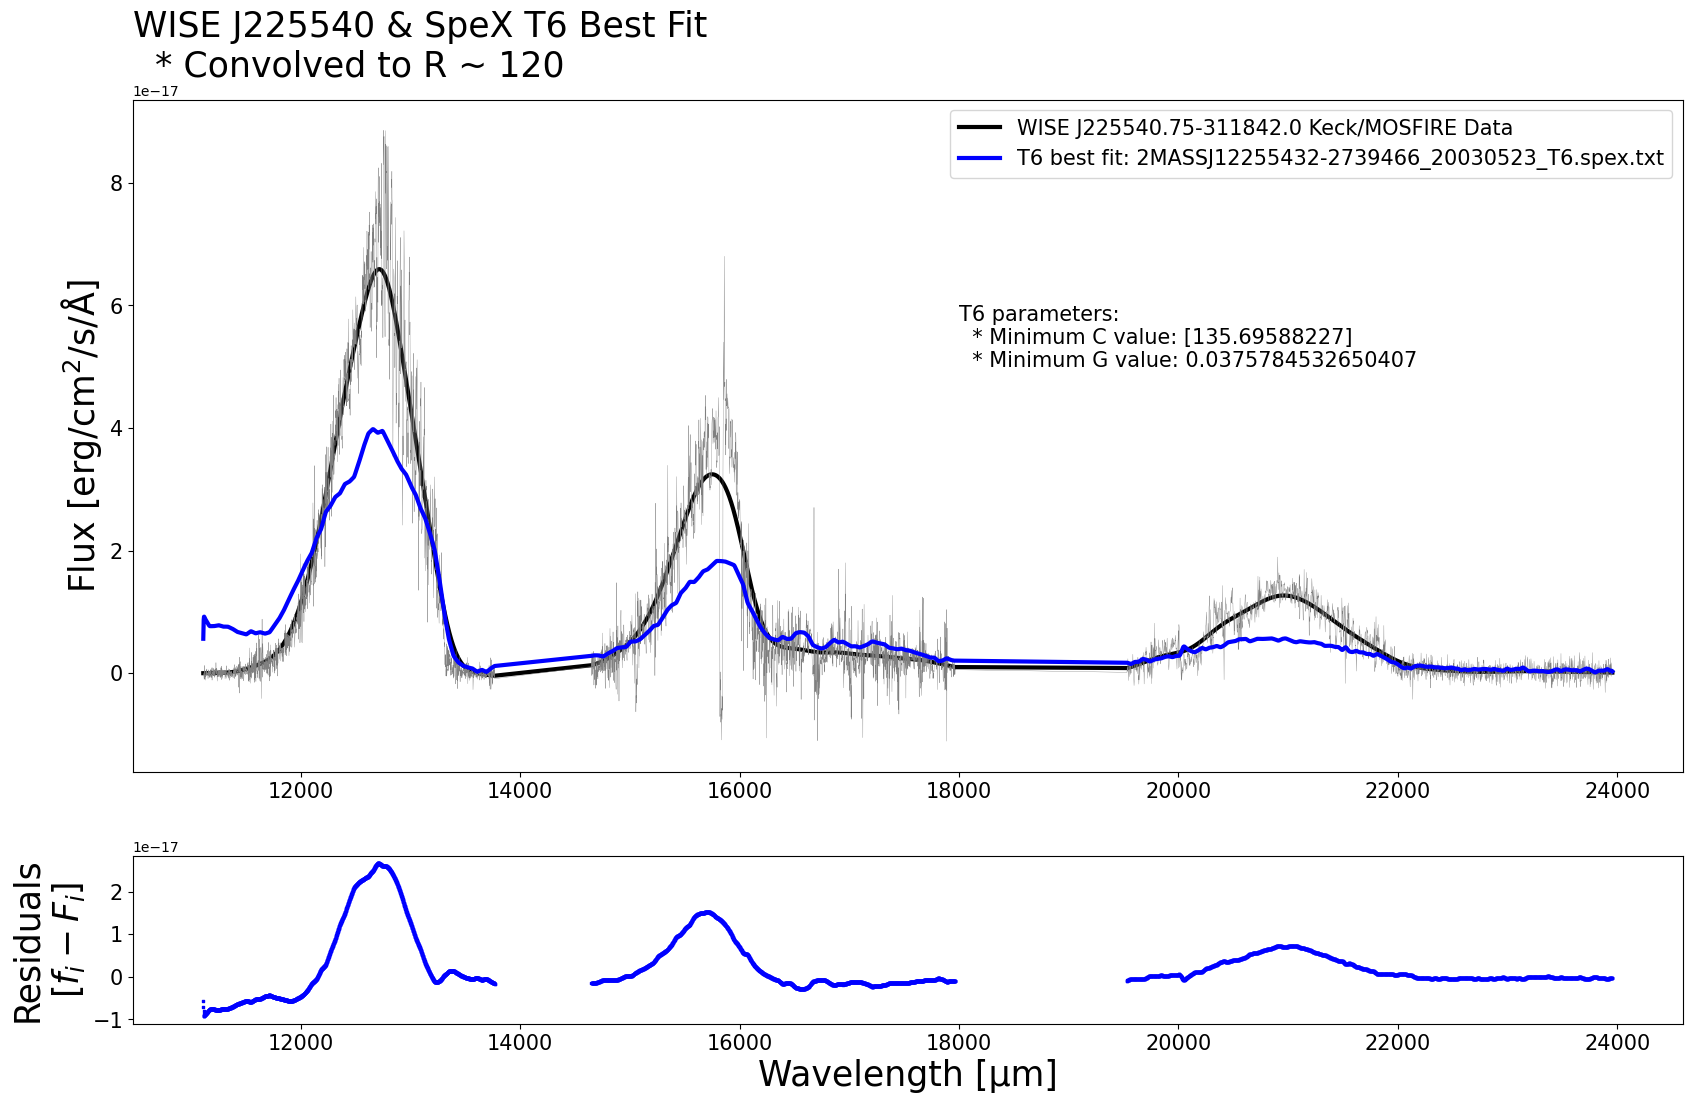

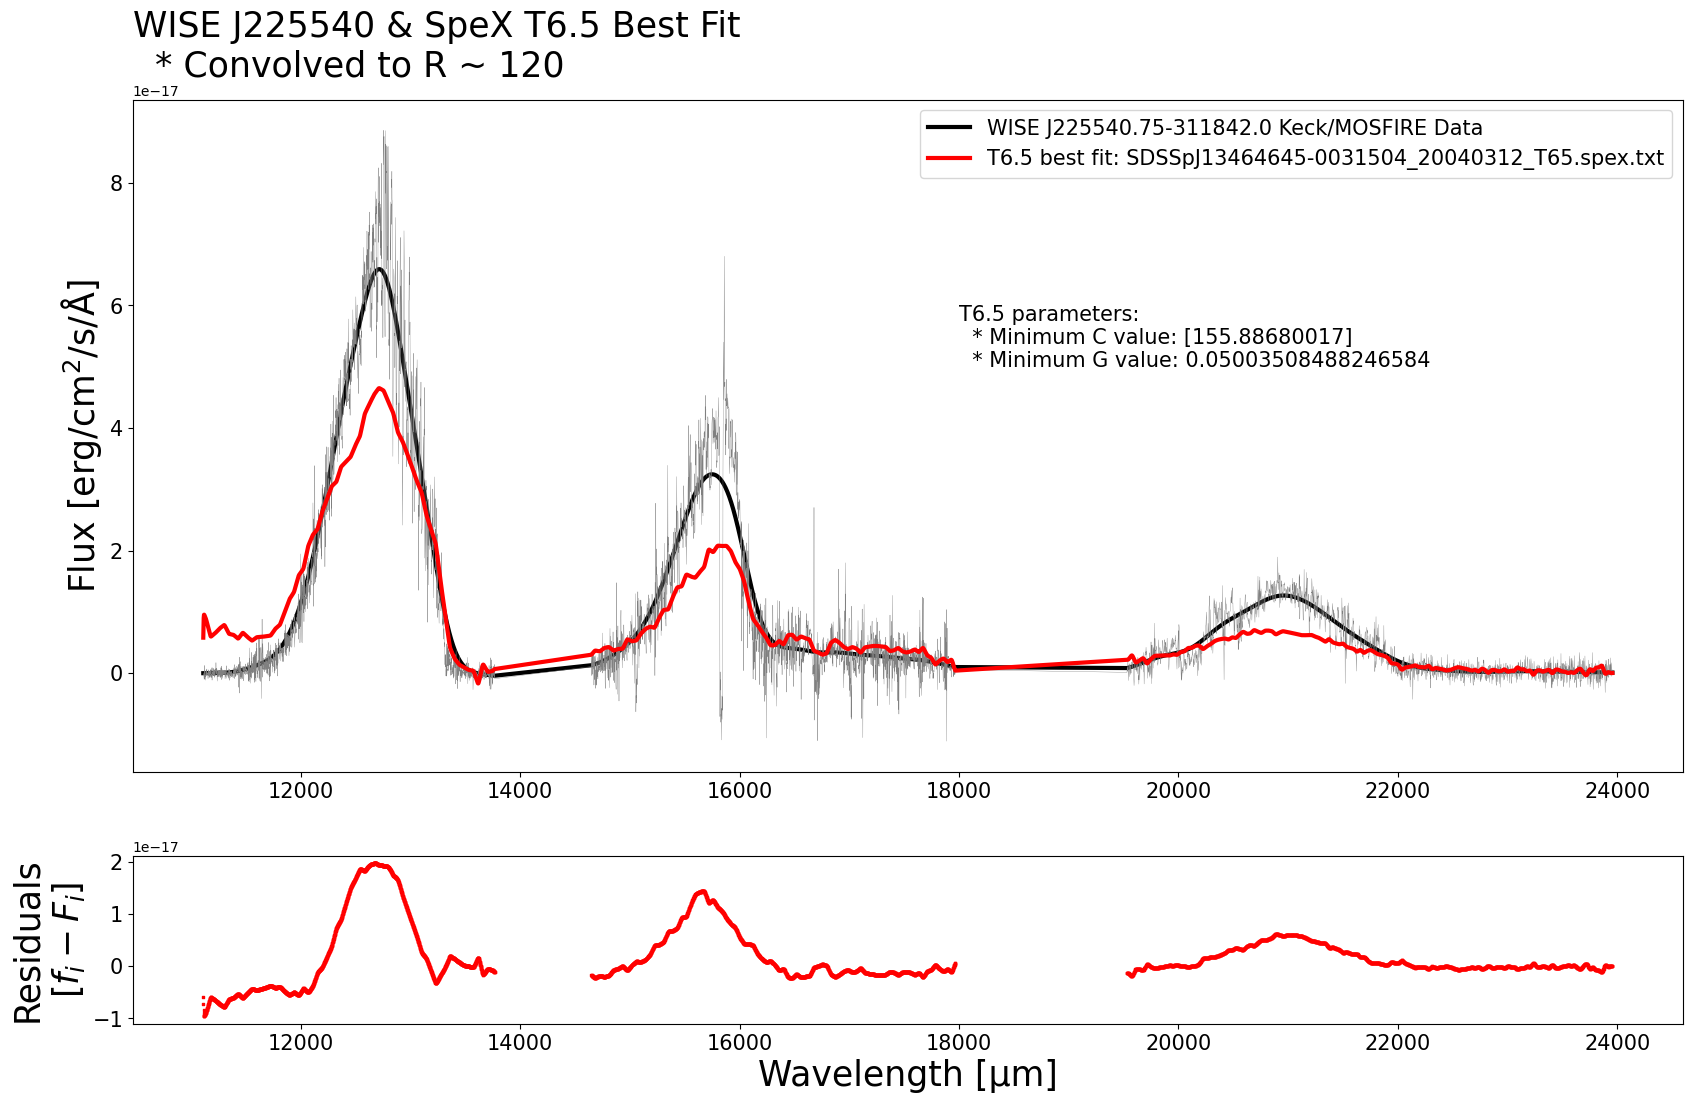

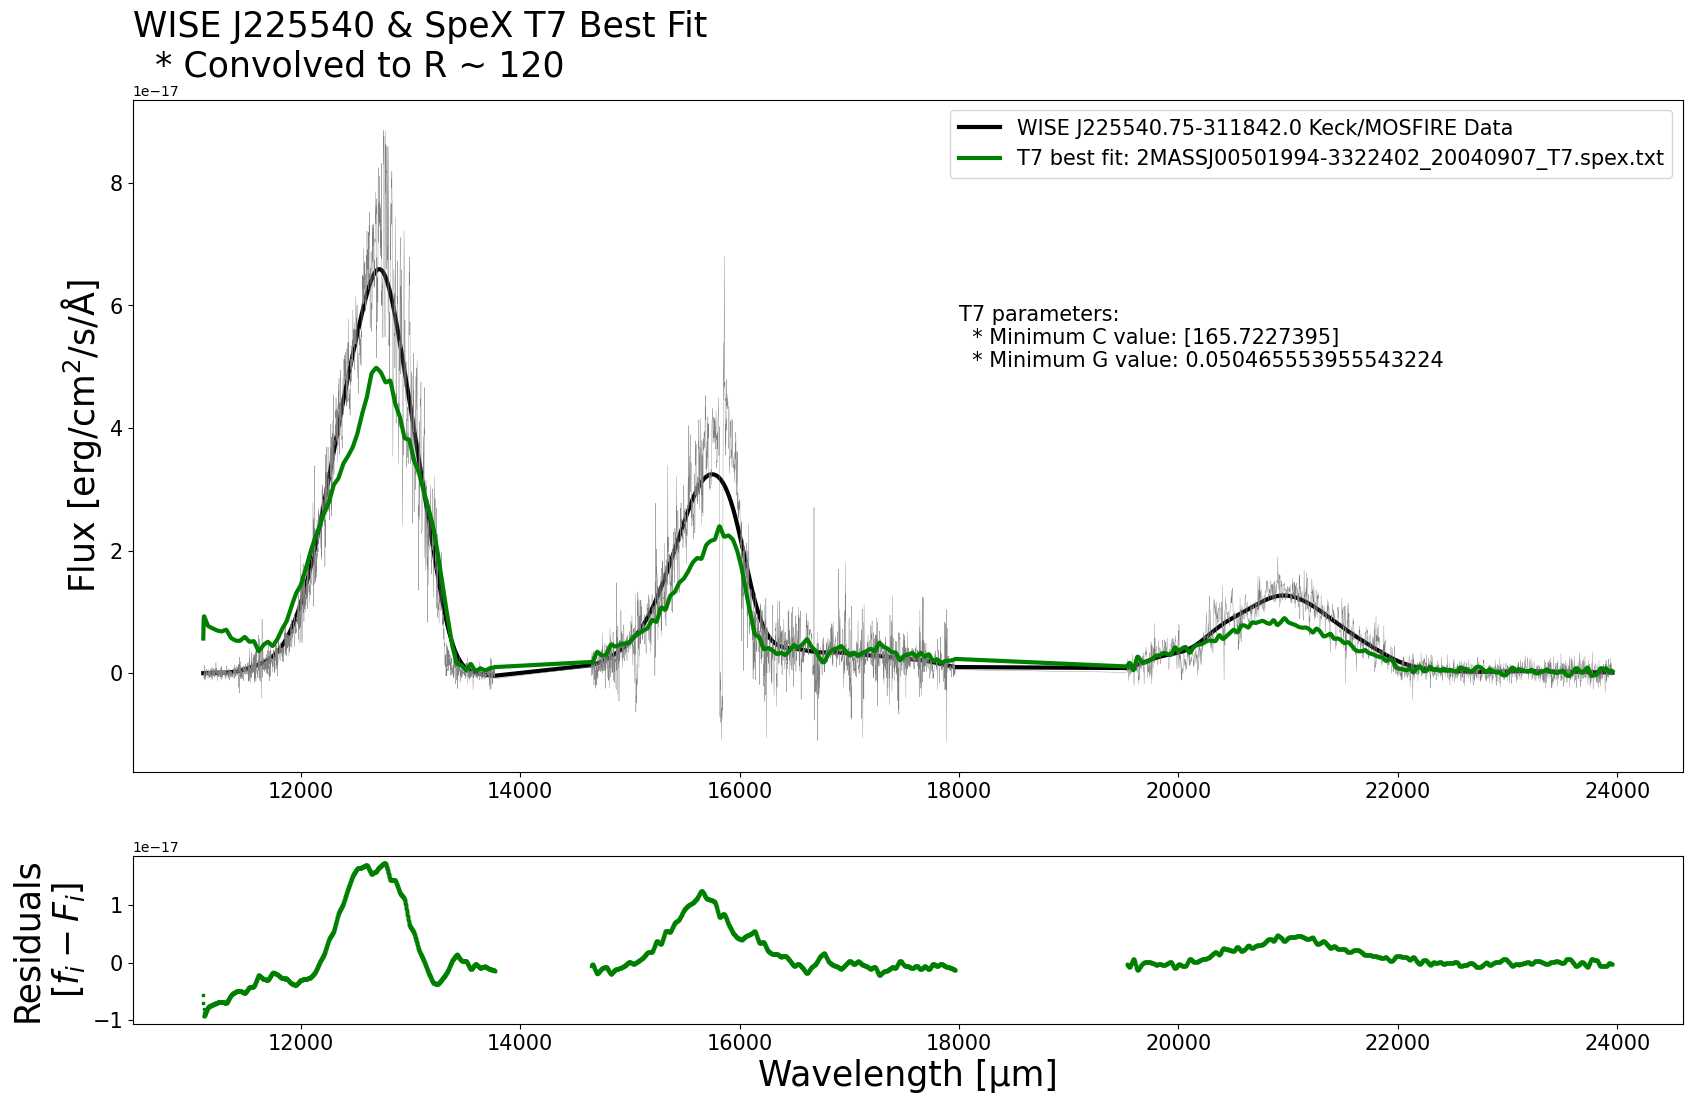

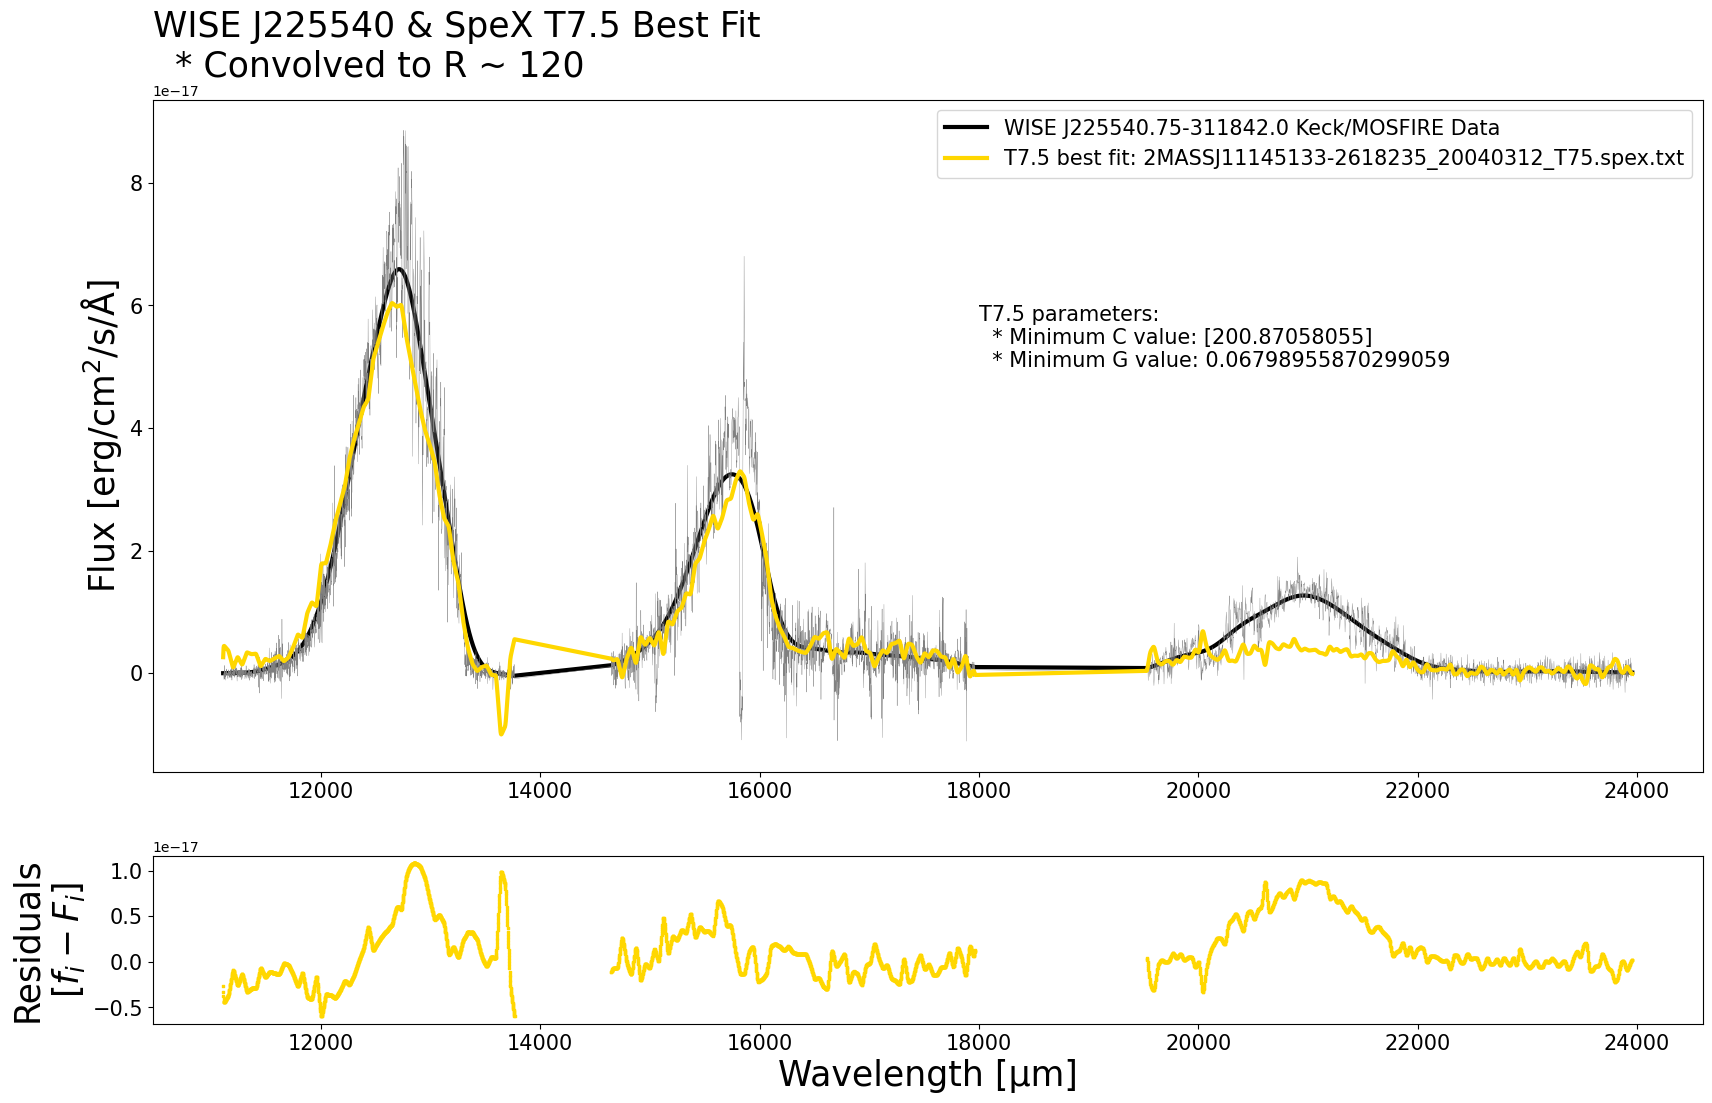

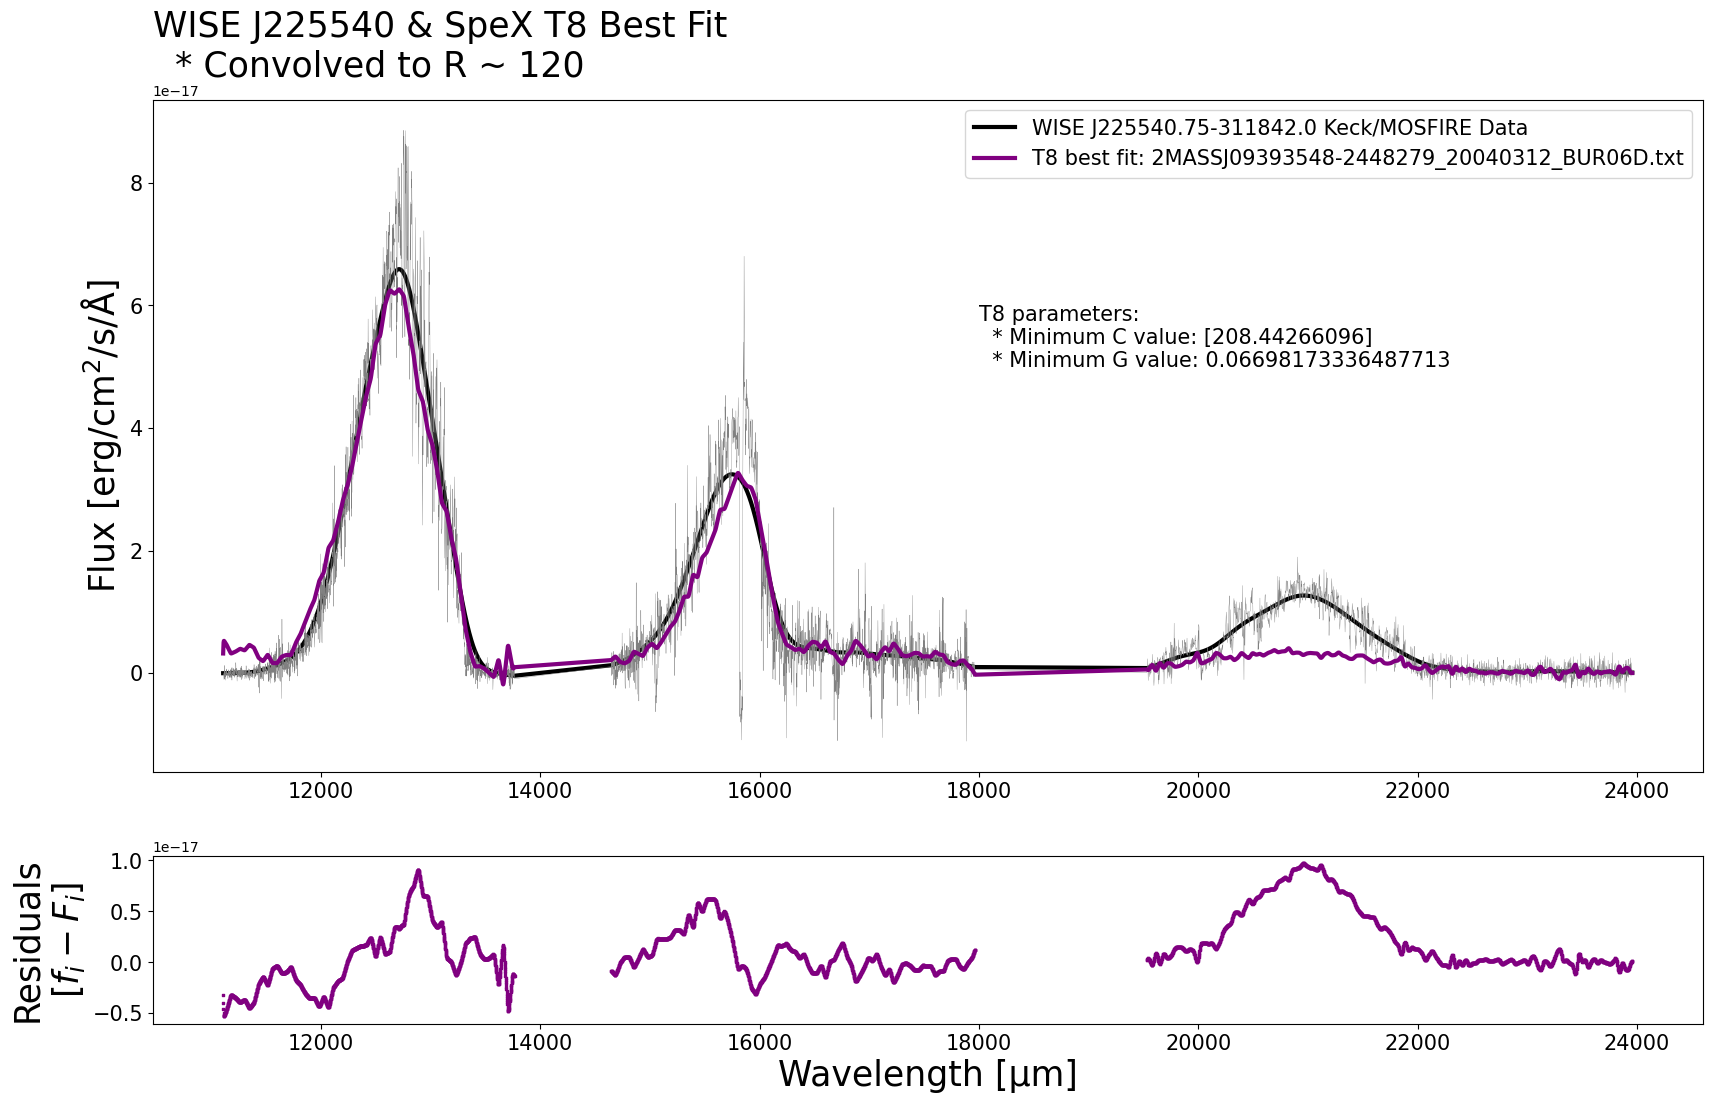

In [15]:
def bestfit_mosfire_to_spex(obs_path, file, mod_path1, mod_path2, mod_path3, mod_path4, mod_path5, t, res, modelname):
    '''
    This function takes the observation file path and the model file path, defines the observation wavelength grid,
    convolves the model wavelengths onto that grid, finds the best fit, and plots the observations and best fit together.
    I wish it was more generally parametized, but C'est la vie.
    * Parameters:
        * obs_path: str - the file path to the observed data (pre-defined)
        * mod_path: str - the file path to the model data (pre-defined)
        * t: str - the given name of the observed target (pre-defined)
        * res: int - the instrument resolution for the models to be convolved to (pre-defined)
        * modelname: int - the given name of the model in use (i.e., BT-Settl, ATMO, etc.)
    * Returns:
        * Cmin: arr - the minimum C value of the fit
        * Gmin: int - the minimum G value of the fit
        * bestmodel: str - the file path for the best fit model
        * plot: plot - observational data and the best fit model plotted together
    * Notes:
        * Built to work in tandem with convolve_v2()
        * Data files should be shaped as (wavelength, flux, uncertainty (optional))
        * bestfit_atmo is written to work with any models[i].dat file and will plot the best fit in green.
        * Needs numpy as np, matplotlib.pyplot as plt, and os, glob from glob
    '''
    ## Read in and sort the observational data, and define the resolution for convolve()
    #obs = np.loadtxt(obs_path)
    wave_obs = obs_path[:, 0]
    flux_obs = obs_path[:, 1] * 1e-4
    #unc_obs = err

    keck = np.loadtxt(file)
    wave_k = keck[:, 0]
    flux_k = keck[:, 1] * 1e-4
    unc_obs = keck[:, 2]

    ####################
    ## mod_path1 (T6) ##
    ####################
    models1 = glob(os.path.join(mod_path1, '*.txt'))
    C1 = np.zeros(len(models1))
    G1 = np.zeros(len(models1))
    low_mod1 = np.zeros((len(models1), 2, (len(wave_obs))))
    for i in range(len(models1)):
        data = np.loadtxt(models1[i])
        wl = data[:, 0] * 1e4
        flux = data[:, 1] * scale_A
        interp_flux = np.interp(wave_obs, wl, flux)
        range_data = np.vstack([wave_obs, interp_flux])
        low_mod1[i, :, :] = convolve_v2(range_data, R, 1)
        C1[i] = (np.nansum((low_mod1[i, 1, :] * flux_obs) / unc_obs ** 2)) / (np.nansum(low_mod1[i, 1, :] ** 2 / unc_obs ** 2))
        G1[i] = np.nansum(((flux_obs[i] - C1[i] * low_mod1[i, 1, :]) / unc_obs[i]) ** 2)
    G1min = np.min(G1)
    where_G1min = np.where(G1 == G1min)
    C1min = C1[where_G1min]
    modindex1 = int(where_G1min[0])
    bestfit1 = np.loadtxt(models1[modindex1])
    bestmodel1 = models1[modindex1]
    residuals1 = flux_obs - low_mod1[modindex1, 1, :] * C1min
    print(np.average(residuals1))

    ######################
    ## mod_path2 (T6.5) ##
    ######################
    models2 = glob(os.path.join(mod_path2, '*.txt'))
    C2 = np.zeros(len(models2))
    G2 = np.zeros(len(models2))
    low_mod2 = np.zeros((len(models2), 2, (len(wave_obs))))
    for i in range(len(models2)):
        data = np.loadtxt(models2[i])
        wl = data[:, 0] * 1e4
        flux = data[:, 1] * scale_A
        interp_flux = np.interp(wave_obs, wl, flux)
        range_data = np.vstack([wave_obs, interp_flux])
        low_mod2[i, :, :] = convolve_v2(range_data, R, 1)
        C2[i] = (np.nansum((low_mod2[i, 1, :] * flux_obs) / unc_obs ** 2)) / (np.nansum(low_mod2[i, 1, :] ** 2 / unc_obs ** 2))
        G2[i] = np.nansum(((flux_obs[i] - C2[i] * low_mod2[i, 1, :]) / unc_obs[i]) ** 2)
    G2min = np.min(G2)
    where_G2min = np.where(G2 == G2min)
    C2min = C2[where_G2min]
    modindex2 = int(where_G2min[0])
    bestfit2 = np.loadtxt(models2[modindex2])
    bestmodel2 = models2[modindex2]
    residuals2 = flux_obs - low_mod2[modindex2, 1, :] * C2min
    print(np.average(residuals2))

    ####################
    ## mod_path3 (T7) ##
    ####################
    models3 = glob(os.path.join(mod_path3, '*.txt'))
    C3 = np.zeros(len(models3))
    G3 = np.zeros(len(models3))
    low_mod3 = np.zeros((len(models3), 2, (len(wave_obs))))
    for i in range(len(models3)):
        data = np.loadtxt(models3[i])
        wl = data[:, 0] * 1e4
        flux = data[:, 1] * scale_A
        interp_flux = np.interp(wave_obs, wl, flux)
        range_data = np.vstack([wave_obs, interp_flux])
        low_mod3[i, :, :] = convolve_v2(range_data, R, 1)
        C3[i] = (np.nansum((low_mod3[i, 1, :] * flux_obs) / unc_obs ** 2)) / (np.nansum(low_mod3[i, 1, :] ** 2 / unc_obs ** 2))
        G3[i] = np.nansum(((flux_obs[i] - C3[i] * low_mod3[i, 1, :]) / unc_obs[i]) ** 2)
    G3min = np.min(G3)
    where_G3min = np.where(G3 == G3min)
    C3min = C3[where_G3min]
    modindex3 = int(where_G3min[0])
    bestfit3 = np.loadtxt(models3[modindex3])
    bestmodel3 = models3[modindex3]
    residuals3 = flux_obs - low_mod3[modindex3, 1, :] * C3min
    print(np.average(residuals3))

    ######################
    ## mod_path4 (T7.5) ##
    ######################
    models4 = glob(os.path.join(mod_path4, '*.txt'))
    C4 = np.zeros(len(models4))
    G4 = np.zeros(len(models4))
    low_mod4 = np.zeros((len(models4), 2, (len(wave_obs))))
    for i in range(len(models4)):
        data = np.loadtxt(models4[i])
        wl = data[:, 0] * 1e4
        flux = data[:, 1] * scale_A
        interp_flux = np.interp(wave_obs, wl, flux)
        range_data = np.vstack([wave_obs, interp_flux])
        low_mod4[i, :, :] = convolve_v2(range_data, R, 1)
        C4[i] = (np.nansum((low_mod4[i, 1, :] * flux_obs) / unc_obs ** 2)) / (np.nansum(low_mod4[i, 1, :] ** 2 / unc_obs ** 2))
        G4[i] = np.nansum(((flux_obs[i] - C4[i] * low_mod4[i, 1, :]) / unc_obs[i]) ** 2)
    G4min = np.min(G4)
    where_G4min = np.where(G4 == G4min)
    C4min = C4[where_G4min]
    modindex4 = int(where_G4min[0])
    bestfit4 = np.loadtxt(models4[modindex4])
    bestmodel4 = models4[modindex4]
    residuals4 = flux_obs - low_mod4[modindex4, 1, :] * C4min
    print(np.average(residuals4))


    ####################
    ## mod_path5 (T8) ##
    ####################
    models5 = glob(os.path.join(mod_path5, '*.txt'))
    C5 = np.zeros(len(models5))
    G5 = np.zeros(len(models5))
    low_mod5 = np.zeros((len(models5), 2, (len(wave_obs))))
    for i in range(len(models5)):
        data = np.loadtxt(models5[i])
        wl = data[:, 0] * 1e4
        flux = data[:, 1] * scale_A
        interp_flux = np.interp(wave_obs, wl, flux)
        range_data = np.vstack([wave_obs, interp_flux])
        low_mod5[i, :, :] = convolve_v2(range_data, R, 1)
        C5[i] = (np.nansum((low_mod5[i, 1, :] * flux_obs) / unc_obs ** 2)) / (np.nansum(low_mod5[i, 1, :] ** 2 / unc_obs ** 2))
        G5[i] = np.nansum(((flux_obs[i] - C5[i] * low_mod5[i, 1, :]) / unc_obs[i]) ** 2)
    G5min = np.min(G5)
    where_G5min = np.where(G5 == G5min)
    C5min = C5[where_G5min]
    modindex5 = int(where_G5min[0])
    bestfit5 = np.loadtxt(models5[modindex5])
    bestmodel5 = models5[modindex5]
    residuals5 = flux_obs - low_mod5[modindex5, 1, :] * C5min
    print(np.average(residuals5))

    ## Plot the best fit model with the observational data
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (20, 12), gridspec_kw = {'height_ratios': [4, 1]})
    ax1.plot(wave_obs, flux_obs, color = 'black', linewidth = 3, label = f'{target} Keck/MOSFIRE Data')
    ax1.plot(wave_k, flux_k, color = 'gray', linewidth = 0.25)
    ax1.plot(low_mod1[modindex1, 0, :], low_mod1[modindex1, 1, :] * C1min, color = 'blue', linewidth = 3, label = f'T6 best fit:    {bestmodel1[79:]}')
    ax1.plot(low_mod2[modindex2, 0, :], low_mod2[modindex2, 1, :] * C2min, color = 'red', linewidth = 3, label = f'T6.5 best fit: {bestmodel2[81:]}')
    ax1.plot(low_mod3[modindex3, 0, :], low_mod3[modindex3, 1, :] * C3min, color = 'green', linewidth = 3, label = f'T7 best fit:    {bestmodel3[79:]}')
    ax1.plot(low_mod4[modindex4, 0, :], low_mod4[modindex4, 1, :] * C4min, color = 'gold', linewidth = 3, label = f'T7.5 best fit: {bestmodel4[81:]}')
    ax1.plot(low_mod5[modindex5, 0, :], low_mod5[modindex5, 1, :] * C5min, color = 'purple', linewidth = 3, label = f'T8 best fit:    {bestmodel5[79:]}')      
    ax1.set_title(t + f' & {modelname} Best Fits\n  * Convolved to R ~ 120', loc = 'left', fontsize = 25)
    ax1.set_ylabel('Flux [erg/cm$^2$/s/Å]', fontsize = 25)
    ax1.tick_params(axis = 'both', which = 'major', labelsize = 15)
    ax1.legend(loc = 'upper right', fontsize = 15, fancybox = True)    
    #ax1.set_title(t + f' & {modelname} Best Fits\n  * Convolved to R = {np.round(R, 1)}', loc = 'left', fontsize = 25)
    #ax1.set_ylabel('Flux [erg/cm$^2$/s/Å]', fontsize = 25)
    #ax1.tick_params(axis = 'both', which = 'major', labelsize = 15)
    #ax1.legend(loc = 'upper right', fontsize = 15, fancybox = True)
    ax1.annotate(f'T6 parameters:\n  * Minimum C value: {C1min}\n  * Minimum G value: {G1min}\n\nT6.5 parameters:\n  * Minimum C value: {C2min}\n  * Minimum G value: {G2min}\n\nT7 parameters:\n  * Minimum C value: {C3min}\n  * Minimum G value: {G3min}\n\nT7.5 parameters:\n  * Minimum C value: {C4min}\n  * Minimum G value: {G4min}\n\nT8 parameters:\n  * Minimum C value: {C5min}\n  * Minimum G value: {G5min}', (18000, 2e-17), fontsize = 8)
    ax1.annotate(f'Residuals standard deviation:\n* T6:    {np.std(residuals1)}\n* T6.5: {np.std(residuals2)}\n* T7:    {np.std(residuals3)}\n* T7.5: {np.std(residuals4)}\n* T8:    {np.std(residuals5)}', (21000, 4.45e-17), fontsize = 8)
    ax2.scatter(wave_obs, residuals1, color = 'blue', marker = ',', s = 1)
    ax2.scatter(wave_obs, residuals2, color = 'red', marker = ',', s = 1)
    ax2.scatter(wave_obs, residuals3, color = 'green', marker = ',', s = 1)
    ax2.scatter(wave_obs, residuals4, color = 'gold', marker = ',', s = 1)
    ax2.scatter(wave_obs, residuals5, color = 'purple', marker = ',', s = 1)
    ax2.set_xlabel('Wavelength [µm]', fontsize = 25)
    ax2.set_ylabel(f'Residuals\n'r'$[f_i - F_i]$', fontsize=25)
    ax2.tick_params(axis = 'both', which = 'major', labelsize = 15)
    plt.savefig('aWISE + SpeX (type) Best Fits [MOSFIRE convolved to SpeX]')

    fig, (ax3, ax4) = plt.subplots(2, 1, figsize = (20, 12), gridspec_kw = {'height_ratios': [4, 1]})
    ax3.plot(wave_obs, flux_obs, color = 'black', linewidth = 3, label = f'{target} Keck/MOSFIRE Data')
    ax3.plot(wave_k, flux_k, color = 'gray', linewidth = 0.25)
    ax3.plot(low_mod1[modindex1, 0, :], low_mod1[modindex1, 1, :] * C1min, color = 'blue', linewidth = 3, label = f'T6 best fit: {bestmodel1[79:]}')
    ax3.set_title(t + f' & {modelname} T6 Best Fit\n  * Convolved to R ~ 120', loc = 'left', fontsize = 25)
    ax3.set_ylabel('Flux [erg/cm$^2$/s/Å]', fontsize = 25)
    ax3.tick_params(axis = 'both', which = 'major', labelsize = 15)
    ax3.legend(loc = 'upper right', fontsize = 15, fancybox = True)
    ax3.annotate(f'T6 parameters:\n  * Minimum C value: {C1min}\n  * Minimum G value: {G1min}', (18000, 5e-17), fontsize = 15)
    ax4.scatter(wave_obs, residuals1, color = 'blue', marker = ',', s = 1, label = 'Residuals')
    ax4.set_xlabel('Wavelength [µm]', fontsize = 25)
    ax4.set_ylabel(f'Residuals\n'r'$[f_i - F_i]$', fontsize=25)
    ax4.tick_params(axis = 'both', which = 'major', labelsize = 15)
    plt.savefig('aWISE + SpeX T6 Best Fits [MOSFIRE convolved to SpeX]')

    fig, (ax5, ax6) = plt.subplots(2, 1, figsize = (20, 12), gridspec_kw = {'height_ratios': [4, 1]})
    ax5.plot(wave_obs, flux_obs, color = 'black', linewidth = 3, label = f'{target} Keck/MOSFIRE Data')
    ax5.plot(wave_k, flux_k, color = 'gray', linewidth = 0.25)
    ax5.plot(low_mod2[modindex2, 0, :], low_mod2[modindex2, 1, :] * C2min, color = 'red', linewidth = 3, label = f'T6.5 best fit: {bestmodel2[81:]}')
    ax5.set_title(t + f' & {modelname} T6.5 Best Fit\n  * Convolved to R ~ 120', loc = 'left', fontsize = 25)
    ax5.set_ylabel('Flux [erg/cm$^2$/s/Å]', fontsize = 25)
    ax5.tick_params(axis = 'both', which = 'major', labelsize = 15)
    ax5.legend(loc = 'upper right', fontsize = 15, fancybox = True)
    ax5.annotate(f'T6.5 parameters:\n  * Minimum C value: {C2min}\n  * Minimum G value: {G2min}', (18000, 5e-17), fontsize = 15)
    ax6.scatter(wave_obs, residuals2, color = 'red', marker = ',', s = 1, label = 'Residuals')
    ax6.set_xlabel('Wavelength [µm]', fontsize = 25)
    ax6.set_ylabel(f'Residuals\n'r'$[f_i - F_i]$', fontsize=25)
    ax6.tick_params(axis = 'both', which = 'major', labelsize = 15)
    plt.savefig('aWISE + SpeX T65 Best Fits [MOSFIRE convolved to SpeX]')

    fig, (ax7, ax8) = plt.subplots(2, 1, figsize = (20, 12), gridspec_kw = {'height_ratios': [4, 1]})
    ax7.plot(wave_obs, flux_obs, color = 'black', linewidth = 3, label = f'{target} Keck/MOSFIRE Data')
    ax7.plot(wave_k, flux_k, color = 'gray', linewidth = 0.25)
    ax7.plot(low_mod3[modindex3, 0, :], low_mod3[modindex3, 1, :] * C3min, color = 'green', linewidth = 3, label = f'T7 best fit: {bestmodel3[79:]}')
    ax7.set_title(t + f' & {modelname} T7 Best Fit\n  * Convolved to R ~ 120', loc = 'left', fontsize = 25)
    ax7.set_ylabel('Flux [erg/cm$^2$/s/Å]', fontsize = 25)
    ax7.tick_params(axis = 'both', which = 'major', labelsize = 15)
    ax7.legend(loc = 'upper right', fontsize = 15, fancybox = True)
    ax7.annotate(f'T7 parameters:\n  * Minimum C value: {C3min}\n  * Minimum G value: {G3min}', (18000, 5e-17), fontsize = 15)
    ax8.scatter(wave_obs, residuals3, color = 'green', marker = ',', s = 1, label = 'Residuals')
    ax8.set_xlabel('Wavelength [µm]', fontsize = 25)
    ax8.set_ylabel(f'Residuals\n'r'$[f_i - F_i]$', fontsize=25)
    ax8.tick_params(axis = 'both', which = 'major', labelsize = 15)
    plt.savefig('aWISE + SpeX T7 Best Fits [MOSFIRE convolved to SpeX]')

    fig, (ax9, ax10) = plt.subplots(2, 1, figsize = (20, 12), gridspec_kw = {'height_ratios': [4, 1]})
    ax9.plot(wave_obs, flux_obs, color = 'black', linewidth = 3, label = f'{target} Keck/MOSFIRE Data')
    ax9.plot(wave_k, flux_k, color = 'gray', linewidth = 0.25)
    ax9.plot(low_mod4[modindex4, 0, :], low_mod4[modindex4, 1, :] * C4min, color = 'gold', linewidth = 3, label = f'T7.5 best fit: {bestmodel4[81:]}')
    ax9.set_title(t + f' & {modelname} T7.5 Best Fit\n  * Convolved to R ~ 120', loc = 'left', fontsize = 25)
    ax9.set_ylabel('Flux [erg/cm$^2$/s/Å]', fontsize = 25)
    ax9.tick_params(axis = 'both', which = 'major', labelsize = 15)
    ax9.legend(loc = 'upper right', fontsize = 15, fancybox = True)
    ax9.annotate(f'T7.5 parameters:\n  * Minimum C value: {C4min}\n  * Minimum G value: {G4min}', (18000, 5e-17), fontsize = 15)
    ax10.scatter(wave_obs, residuals4, color = 'gold', marker = ',', s = 1, label = 'Residuals')
    ax10.set_xlabel('Wavelength [µm]', fontsize = 25)
    ax10.set_ylabel(f'Residuals\n'r'$[f_i - F_i]$', fontsize=25)
    ax10.tick_params(axis = 'both', which = 'major', labelsize = 15)
    plt.savefig('aWISE + SpeX T75 Best Fits [MOSFIRE convolved to SpeX]')

    fig, (ax11, ax12) = plt.subplots(2, 1, figsize = (20, 12), gridspec_kw = {'height_ratios': [4, 1]})
    ax11.plot(wave_obs, flux_obs, color = 'black', linewidth = 3, label = f'{target} Keck/MOSFIRE Data')
    ax11.plot(wave_k, flux_k, color = 'gray', linewidth = 0.25)
    ax11.plot(low_mod5[modindex5, 0, :], low_mod5[modindex5, 1, :] * C5min, color = 'purple', linewidth = 3, label = f'T8 best fit: {bestmodel5[68:]}')
    ax11.set_title(t + f' & {modelname} T8 Best Fit\n  * Convolved to R ~ 120', loc = 'left', fontsize = 25)
    ax11.set_ylabel('Flux [erg/cm$^2$/s/Å]', fontsize = 25)
    ax11.tick_params(axis = 'both', which = 'major', labelsize = 15)
    ax11.legend(loc = 'upper right', fontsize = 15, fancybox = True)
    ax11.annotate(f'T8 parameters:\n  * Minimum C value: {C5min}\n  * Minimum G value: {G5min}', (18000, 5e-17), fontsize = 15)
    ax12.scatter(wave_obs, residuals5, color = 'purple', marker = ',', s = 1, label = 'Residuals')
    ax12.set_xlabel('Wavelength [µm]', fontsize = 25)
    ax12.set_ylabel(f'Residuals\n'r'$[f_i - F_i]$', fontsize=25)
    ax12.tick_params(axis = 'both', which = 'major', labelsize = 15)
    plt.savefig('aWISE + SpeX T8 Best Fits [MOSFIRE convolved to SpeX]')
    
    return

bestfit_mosfire_to_spex(smooth_spec, file_name, spex_T6_path, spex_T65_path, spex_T7_path, spex_T75_path, spex_T8_path, target_short, R, 'SpeX')

In [16]:
spex_T8new_path = '/Users/bseamons/Documents/Research/SpeX_archived_spectra/Grouped/T8_new/'
spex_T8new = glob(os.path.join(spex_T8_path, '*.txt'))

In [20]:
def spexT8(obs_path, file, mod_path1, t, res, modelname):
    '''
    This function takes the observation file path and the model file path, defines the observation wavelength grid,
    convolves the model wavelengths onto that grid, finds the best fit, and plots the observations and best fit together.
    I wish it was more generally parametized, but C'est la vie.
    * Parameters:
        * obs_path: str - the file path to the observed data (pre-defined)
        * mod_path: str - the file path to the model data (pre-defined)
        * t: str - the given name of the observed target (pre-defined)
        * res: int - the instrument resolution for the models to be convolved to (pre-defined)
        * modelname: int - the given name of the model in use (i.e., BT-Settl, ATMO, etc.)
    * Returns:
        * Cmin: arr - the minimum C value of the fit
        * Gmin: int - the minimum G value of the fit
        * bestmodel: str - the file path for the best fit model
        * plot: plot - observational data and the best fit model plotted together
    * Notes:
        * Built to work in tandem with convolve_v2()
        * Data files should be shaped as (wavelength, flux, uncertainty (optional))
        * bestfit_atmo is written to work with any models[i].dat file and will plot the best fit in green.
        * Needs numpy as np, matplotlib.pyplot as plt, and os, glob from glob
    '''
    ## Read in and sort the observational data, and define the resolution for convolve()
    #obs = np.loadtxt(obs_path)
    wave_obs = obs_path[:, 0]
    flux_obs = obs_path[:, 1] * 1e-4
    #unc_obs = err

    keck = np.loadtxt(file)
    wave_k = keck[:, 0]
    flux_k = keck[:, 1] * 1e-4
    unc_obs = keck[:, 2]

    ####################
    ## mod_path1 (T6) ##
    ####################
    models1 = glob(os.path.join(mod_path1, '*.txt'))
    C1 = np.zeros(len(models1))
    G1 = np.zeros(len(models1))
    low_mod1 = np.zeros((len(models1), 2, (len(wave_obs))))
    for i in range(len(models1)):
        data = np.loadtxt(models1[i])
        wl = data[:, 0] * 1e4
        flux = data[:, 1]
        interp_flux = np.interp(wave_obs, wl, flux)
        range_data = np.vstack([wave_obs, interp_flux])
        low_mod1[i, :, :] = convolve_v2(range_data, R, 1)
        C1[i] = (np.nansum((low_mod1[i, 1, :] * flux_obs) / unc_obs ** 2)) / (np.nansum(low_mod1[i, 1, :] ** 2 / unc_obs ** 2))
        G1[i] = np.nansum(((flux_obs[i] - C1[i] * low_mod1[i, 1, :]) / unc_obs[i]) ** 2)
    G1min = np.min(G1)
    where_G1min = np.where(G1 == G1min)
    C1min = C1[where_G1min]
    modindex1 = int(where_G1min[0])
    bestfit1 = np.loadtxt(models1[modindex1])
    bestmodel1 = models1[modindex1]
    residuals1 = flux_obs - low_mod1[modindex1, 1, :] * C1min

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (20, 12), gridspec_kw = {'height_ratios': [4, 1]})
    ax1.plot(wave_obs, flux_obs, color = 'black', linewidth = 3, label = f'{target} Keck/MOSFIRE Data')
    ax1.plot(wave_k, flux_k, color = 'gray', linewidth = 0.25)
    ax1.plot(low_mod1[modindex1, 0, :], low_mod1[modindex1, 1, :] * C1min, color = 'blue', linewidth = 3, label = f'T8 best fit: {bestmodel1[72:]}')
    ax1.set_title(t + f' & {modelname} T8 (new) Best Fit\n  * Convolved to R ~ 120', loc = 'left', fontsize = 25)
    ax1.set_ylabel('Flux [erg/cm$^2$/s/Å]', fontsize = 25)
    ax1.tick_params(axis = 'both', which = 'major', labelsize = 15)
    ax1.legend(loc = 'upper right', fontsize = 15, fancybox = True)
    ax1.annotate(f'T8 (new) parameters:\n  * Minimum C value: {C1min}\n  * Minimum G value: {G1min}', (18000, 5e-17), fontsize = 15)
    ax2.scatter(wave_obs, residuals1, color = 'blue', marker = ',', s = 1, label = 'Residuals')
    ax2.set_xlabel('Wavelength [µm]', fontsize = 25)
    ax2.set_ylabel(f'Residuals\n'r'$[f_i - F_i]$', fontsize=25)
    ax2.tick_params(axis = 'both', which = 'major', labelsize = 15)
    #plt.savefig('aWISE + SpeX T8 Best Fits (new) [MOSFIRE convolved to SpeX]')

/var/folders/36/1_bs4p6d4t73n8bdrm6msfsr0005tr/T/ipykernel_84913/1579748255.py:53: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  modindex1 = int(where_G1min[0])


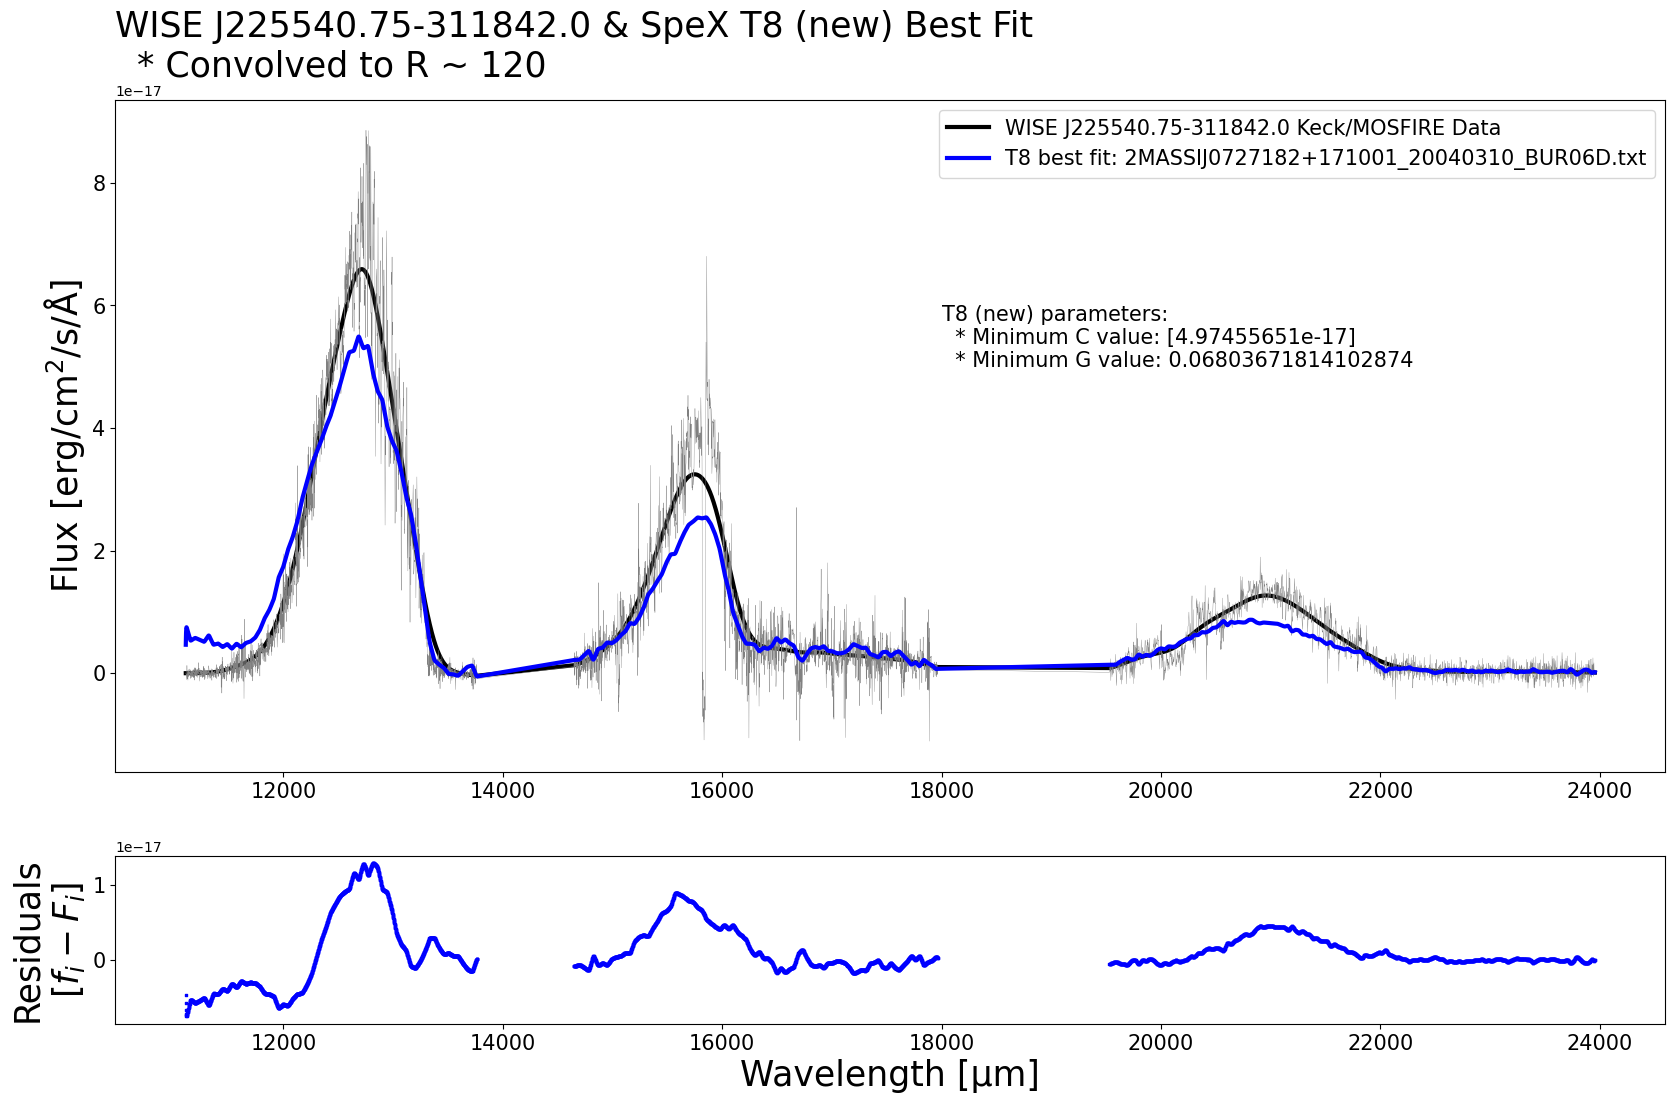

In [21]:
## Only pulling from T8_new

spexT8(smooth_spec, file_name, spex_T8new_path, target, 120, 'SpeX')

/var/folders/36/1_bs4p6d4t73n8bdrm6msfsr0005tr/T/ipykernel_84913/1579748255.py:53: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  modindex1 = int(where_G1min[0])


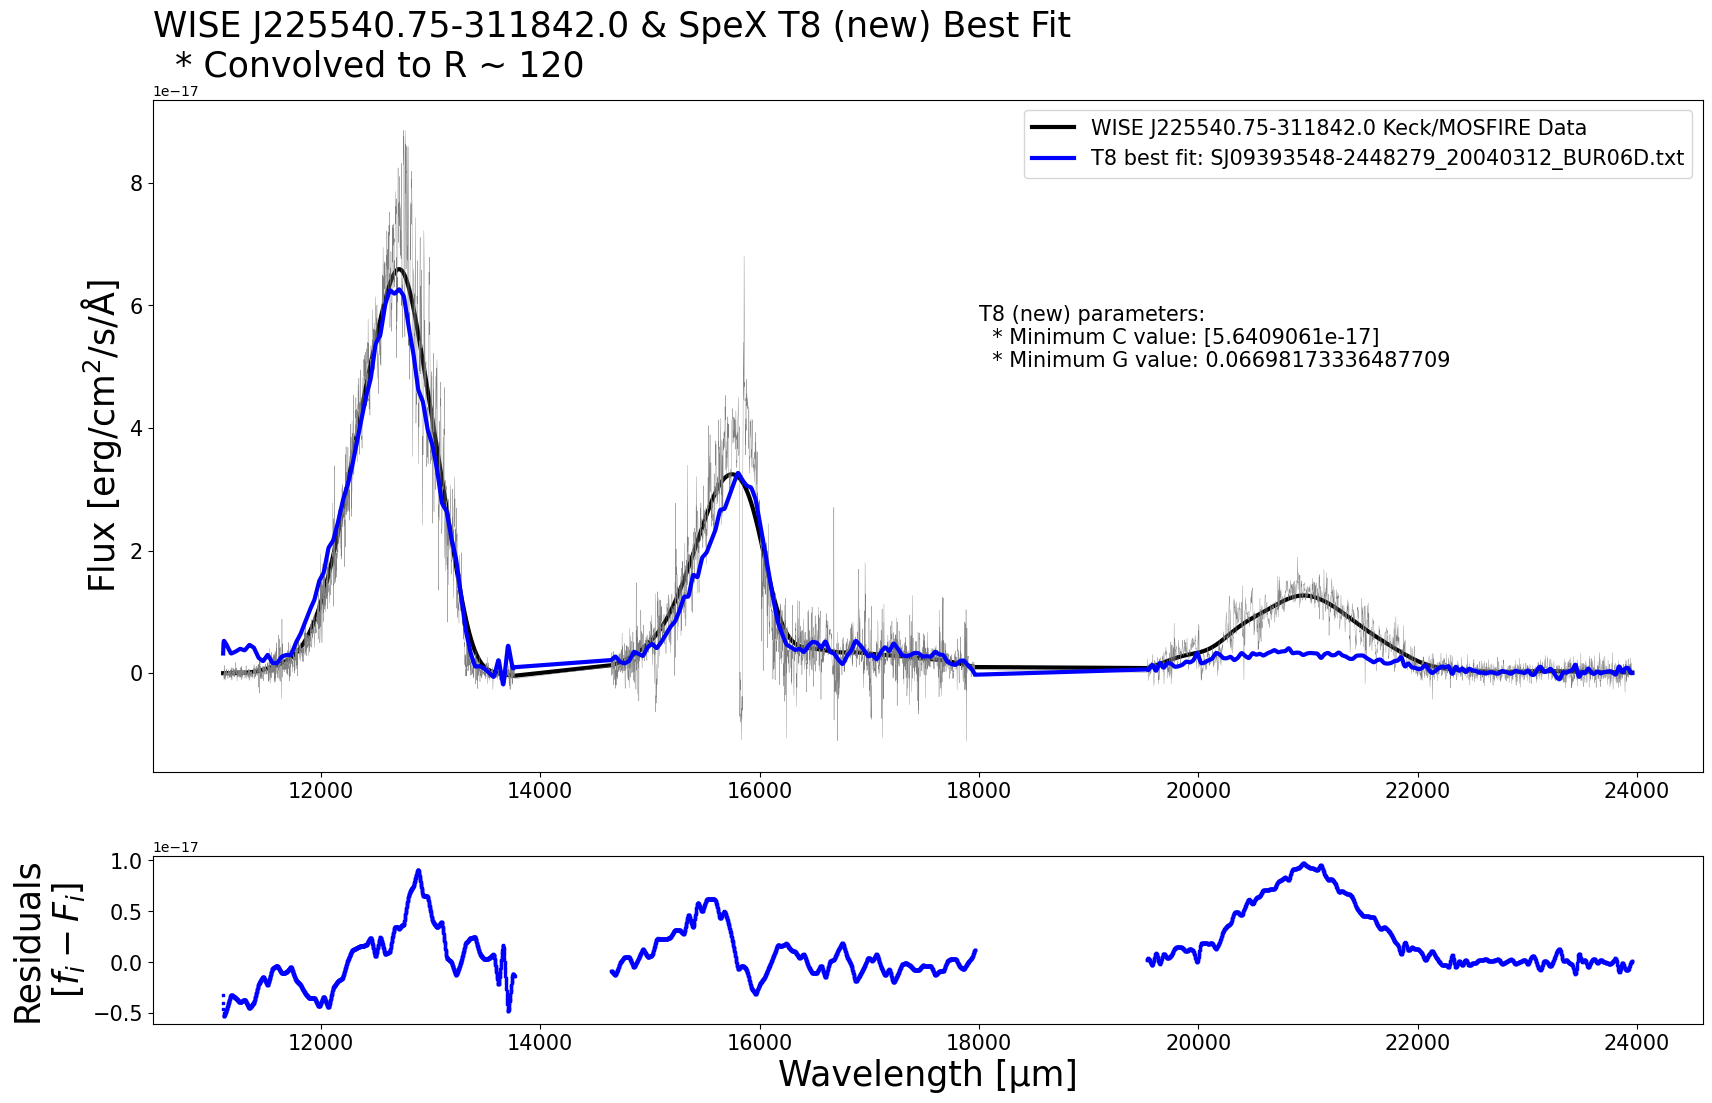

In [22]:
## Pulling from the full T8

spexT8(smooth_spec, file_name, spex_T8_path, target, 120, 'SpeX')

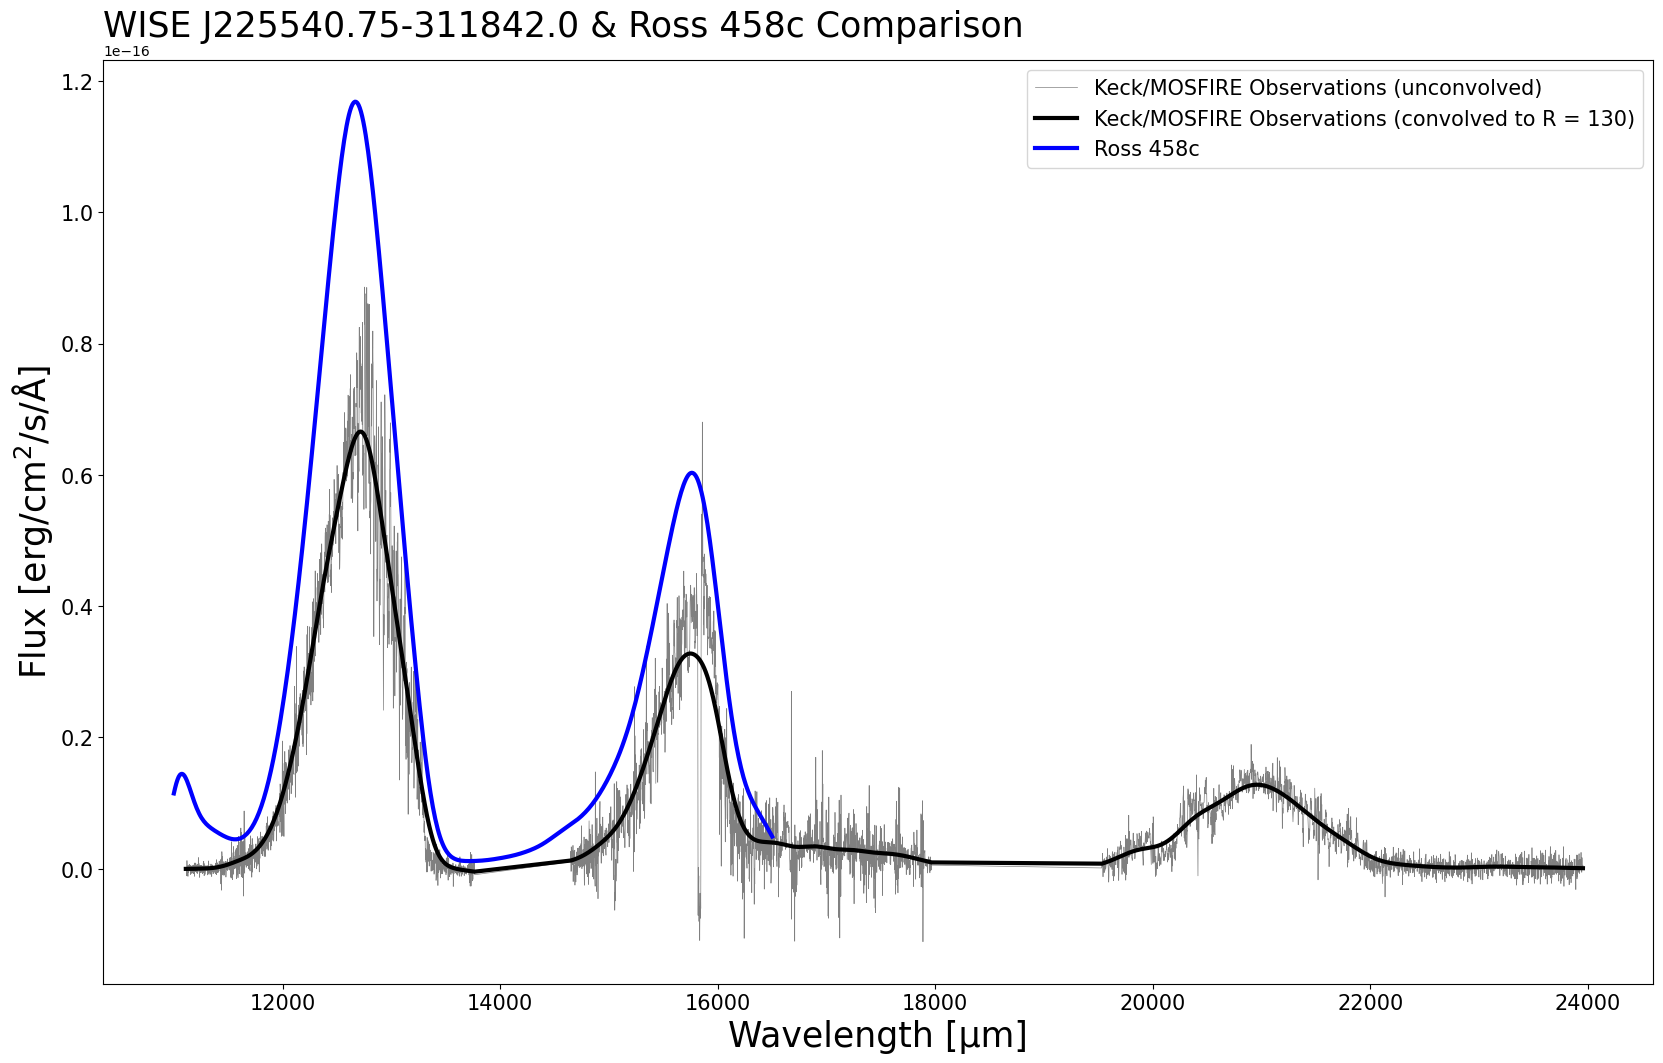

In [24]:
obs = np.loadtxt(file_name)
w = obs[:, 0]
f = obs[:, 1]
u = obs[:, 2]

w_min = np.log10(np.nanmin(w))
w_max = np.log10(np.nanmax(w))
N = np.size(w)
w_grid = np.logspace(w_min, w_max, num = N)

R_grid = (w_grid[1:-1] + w_grid[0:-2]) / (w_grid[1:-1] - w_grid[0:-2]) / 2
sigma = np.median(R_grid) / 130
if sigma < 1:
    sigma = 1

f_log = np.interp(w_grid, w, f)
g = Gaussian1DKernel(stddev = sigma)
fcon = convolve_fft(f_log, g)
fsmooth = np.interp(w, w_grid, fcon)
smooth_spec = np.vstack([w, fsmooth]).T

w_smooth = smooth_spec[:, 0]
f_smooth = smooth_spec[:, 1] * 1e-4

ross = np.genfromtxt('spectra_0_ROSS458C.csv', delimiter = ',')
wr = ross[:, 0] * 1e4
fr = ross[:, 1]
ur = ross[:, 2]

wr_min = np.log10(np.nanmin(wr))
wr_max = np.log10(np.nanmax(wr))
N = np.size(wr)
wr_grid = np.logspace(wr_min, wr_max, num = N)

Rr_grid = (wr_grid[1:-1] + wr_grid[0:-2]) / (wr_grid[1:-1] - wr_grid[0:-2]) / 2
sigmar = np.median(Rr_grid) / 130
if sigmar < 1:
    sigmar = 1

fr_log = np.interp(wr_grid, wr, fr)
gr = Gaussian1DKernel(stddev = sigmar)
frcon = convolve_fft(fr_log, gr)
frsmooth = np.interp(wr, wr_grid, frcon)
smooth_specr = np.vstack([wr, frsmooth]).T

wr_smooth = smooth_specr[:, 0]
fr_smooth = smooth_specr[:, 1]

plt.figure(figsize = (20, 12))
plt.plot(wave, flux * 1e-4, color = 'gray', linewidth = 0.5, label = 'Keck/MOSFIRE Observations (unconvolved)')
plt.plot(w_smooth, f_smooth, color = 'black', linewidth = 3, label = 'Keck/MOSFIRE Observations (convolved to R = 130)')
plt.plot(wr_smooth, fr_smooth, color = 'blue', linewidth = 3, label = 'Ross 458c')
#plt.plot(wr_smooth, fr_smooth, color = 'lightblue', linewidth = 3, label = 'Ross 458c (convolved to R = 130)')

plt.title(f'{target} & Ross 458c Comparison', loc = 'left', fontsize = 25)
plt.xlabel('Wavelength [µm]', fontsize = 25)
plt.ylabel('Flux [erg/cm$^2$/s/Å]', fontsize = 25)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(loc = 'upper right', fontsize = 15, fancybox = True)
plt.savefig('WISE J225540 and Ross 458c Comparison 1')